In [1]:
# Autoreload possibly interferes with IntelliJ debugging
# %reload_ext autoreload
# %autoreload 2
import logging
from datetime import datetime
# class FlushHandler(logging.StreamHandler):
#     def emit(self, record):e
#         super().emit(record)
#         self.flush()
import io
import sys
import contextlib
import traceback
from tqdm.auto import tqdm

from importlib import reload

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# log = lambda msg: logging.info(msg)
log = lambda msg: print(f"{datetime.today()} {msg}")

#assert False
global_force = False

import pandas as pd
import os

input_dir = "C:\\dev\\play\\brainwave-data"
stats_df = pd.read_csv(input_dir + os.path.sep + "stats.csv")

c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Find Brainflow files that haven't been copied over

In [3]:
import pytz
from tqdm import tqdm
import paramiko
import re
from datetime import datetime, timedelta
import os
import dotenv
dotenv.load_dotenv()

# Define the time window
time_window = timedelta(minutes=10)

# Define the remote server details
hostname = os.getenv('SSH_HOST')
username = os.getenv('SSH_USERNAME')
password = os.getenv('SSH_PASSWORD')
remote_dir = '/home/graham/dev/Brainwave-Data'
local_dir = input_dir

# Create an SSH client
ssh = paramiko.SSHClient()
ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
ssh.connect(hostname, username=username, password=password, compress=True)

# List files in the remote directory
stdin, stdout, stderr = ssh.exec_command(f'find {remote_dir} -name "*.brainflow.csv" -size +200M -printf "%f\\n"')
remote_brainflow_files = stdout.read().decode().splitlines()


2025-04-22 07:07:37,897 - INFO - Connected (version 2.0, client OpenSSH_9.6)
2025-04-22 07:07:38,078 - INFO - Authentication (password) successful!


In [4]:
remote_brainflow_files

['2024-09-30-21-27-49.brainflow.csv',
 '2024-10-01-21-36-11.brainflow.csv',
 '2024-10-02-21-21-15.brainflow.csv',
 '2024-10-04-21-13-39.brainflow.csv',
 '2024-10-05-21-09-47.brainflow.csv',
 '2024-10-06-21-29-18.brainflow.csv',
 '2024-10-07-21-35-18.brainflow.csv',
 '2024-10-08-21-21-34.brainflow.csv',
 '2024-10-09-21-22-04.brainflow.csv',
 '2024-10-11-21-16-27.brainflow.csv',
 '2024-10-15-22-01-52.brainflow.csv',
 '2024-10-21-21-30-19.brainflow.csv',
 '2024-10-23-21-24-03.brainflow.csv',
 '2024-10-24-21-35-33.brainflow.csv',
 '2024-10-29-20-42-12.brainflow.csv',
 '2024-10-30-21-26-55.brainflow.csv',
 '2024-11-01-21-32-22.brainflow.csv',
 '2024-11-02-21-29-03.brainflow.csv',
 '2024-11-04-21-20-51.brainflow.csv',
 '2024-11-05-21-34-15.brainflow.csv',
 '2024-11-07-21-26-18.brainflow.csv',
 '2024-11-08-21-16-53.brainflow.csv',
 '2024-11-09-21-27-51.brainflow.csv',
 '2024-11-12-21-11-43.brainflow.csv',
 '2024-11-16-21-54-46.brainflow.csv',
 '2024-11-19-21-29-04.brainflow.csv',
 '2024-11-20

In [5]:
files_to_copy = remote_brainflow_files.copy()


for root, dirs, files in os.walk(input_dir):
    #for idx, file_name in enumerate(tqdm(dirs, desc="Converting Brainflow to FIF")):
    for idx, file_name in enumerate(files):
        full_input_filename = os.path.join(root, file_name)
        if ".brainflow.csv.bz2" in full_input_filename:
            #print(f"Processing {full_input_filename}")
            file_name_without_bz2 = file_name.removesuffix(".bz2")
            already_have = file_name_without_bz2 in remote_brainflow_files
            print(f"Already have {full_input_filename}: {already_have}")
            if already_have:
                files_to_copy.remove(file_name_without_bz2)



Already have C:\dev\play\brainwave-data\08-07-2024--22-51-16\08-07-2024--22-51-16.brainflow.csv.bz2: False
Already have C:\dev\play\brainwave-data\09-07-2024--22-52-25\09-07-2024--22-52-25.brainflow.csv.bz2: False
Already have C:\dev\play\brainwave-data\2024-07-15-09-10-07\2024-07-15-09-10-07.brainflow.csv.bz2: False
Already have C:\dev\play\brainwave-data\2024-07-16-23-14-52\2024-07-16-23-14-52.brainflow.csv.bz2: False
Already have C:\dev\play\brainwave-data\2024-07-24-18-57-03\2024-07-24-18-57-03.brainflow.csv.bz2: False
Already have C:\dev\play\brainwave-data\2024-09-03-21-10-58\2024-09-03-21-10-58.brainflow.csv.bz2: False
Already have C:\dev\play\brainwave-data\2024-09-04-21-44-08\2024-09-04-21-44-08.brainflow.csv.bz2: False
Already have C:\dev\play\brainwave-data\2024-09-08-21-01-39\2024-09-08-21-01-39.brainflow.csv.bz2: False
Already have C:\dev\play\brainwave-data\2024-09-10-21-22-21\2024-09-10-21-22-21.brainflow.csv.bz2: False
Already have C:\dev\play\brainwave-data\2024-09-11-

In [6]:
files_to_copy

['2025-04-21-21-33-06.brainflow.csv']

In [7]:
import os
import bz2
from tqdm import tqdm

sftp = ssh.open_sftp()
for file in files_to_copy:
    remote_file_path = remote_dir + "/" + file
    local_file_path = os.path.join(input_dir, file)
    log(f"Copying Brainflow backup remote:{remote_file_path} to {local_file_path}")

    # Get the file size
    remote_file_size = sftp.stat(remote_file_path).st_size

    with tqdm(total=remote_file_size, unit='B', unit_scale=True, desc=file, ascii=True) as pbar:
        local_file_path = os.path.join(input_dir, file)
    
        def callback(transferred_so_far, total_to_transfer):
            pbar.update(transferred_so_far - pbar.n)
    
        # Create a file-like object that writes to the local file
        with open(local_file_path, 'wb') as local_file:
            sftp.getfo(remote_file_path, local_file, callback=callback)
sftp.close()
ssh.close()


2025-04-22 07:07:39,683 - INFO - [chan 1] Opened sftp connection (server version 3)


2025-04-22 07:07:39.684680 Copying Brainflow backup remote:/home/graham/dev/Brainwave-Data/2025-04-21-21-33-06.brainflow.csv to C:\dev\play\brainwave-data\2025-04-21-21-33-06.brainflow.csv


2025-04-21-21-33-06.brainflow.csv: 100%|##########| 1.96G/1.96G [00:25<00:00, 75.9MB/s]
2025-04-22 07:08:05,535 - INFO - [chan 1] sftp session closed.


## Convert Brainflow files to FIF

In [8]:
def get_brainflow_compressed_filename(full_input_filename: str) -> str:
    full_output_dirname = webserver.output_dirname(full_input_filename)
    compressed_full_output_filename = str(os.path.join(full_output_dirname, os.path.basename(full_input_filename))) + '.bz2'
    return compressed_full_output_filename

In [16]:
from datetime import datetime

import webserver
import convert
# import zstandard as zstd
import os
import bz2
import time
import shutil

errors = []
processed = []

from sample_rates import real_sample_rate

# Could get these working later
skip_list = ['2024-09-10-21-22-21']

def compress_bz2(input_file, output_file):
    start_time = time.time()
    with open(input_file, 'rb') as f_in:
        with bz2.open(output_file, 'wb', compresslevel=9) as f_out:
            shutil.copyfileobj(f_in, f_out)
    end_time = time.time()
    return end_time - start_time, os.path.getsize(output_file)

for root, dirs, files in os.walk(input_dir):
    #for idx, file_name in enumerate(tqdm(dirs, desc="Converting Brainflow to FIF")):
    for idx, file_name in enumerate(files):
        full_input_filename = os.path.join(root, file_name)
        try:
            if full_input_filename.endswith(".brainflow.csv"):
                full_output_dirname = webserver.output_dirname(full_input_filename)
                full_output_filename = str(os.path.join(full_output_dirname, 'raw.fif'))
                
                compressed_full_output_filename = get_brainflow_compressed_filename(full_input_filename)
                
                if not os.path.exists(compressed_full_output_filename):
                    log(f"Compressing file {full_input_filename} to " + compressed_full_output_filename)
                    processed.append("Compressing " + full_input_filename)
                    try:
                        os.mkdir(os.path.dirname(compressed_full_output_filename))
                    except:
                        pass
                    compress_bz2(full_input_filename, compressed_full_output_filename) 
                    
                if os.path.exists(full_output_filename):
                    log(f"Skipping file {full_input_filename} as {full_output_filename} and {compressed_full_output_filename} already exist")
                    continue
                should_skip = False
                for s in skip_list:
                    if s in full_input_filename:
                        log(f"Skipping file {full_input_filename}")
                        should_skip = True
                if not should_skip:
                    log(f"Processing file {full_input_filename}")
                    processed.append("Processing " + full_input_filename)
                    channels = None
                    date_time_str = os.path.basename(full_input_filename).removesuffix(".brainflow.csv")
                    date_time_obj = datetime.strptime(date_time_str, '%Y-%m-%d-%H-%M-%S')
                    log(f"Date time obj: {date_time_obj} {date_time_obj > datetime(2025, 3, 12, 0, 0, 0)} {date_time_str}")
                    if (date_time_obj > datetime(2025, 3, 12, 0, 0, 0) and date_time_obj < datetime(2025, 3, 14, 0, 0, 0)):
                        channels = ['Fpz-M1', 'O2-M1']
                    elif (date_time_obj > datetime(2024, 9, 1, 0, 0, 0)):
                        channels = ['Fpz-M1']
        
                    if channels is not None:
                        log(f"Processing file {full_input_filename} with channels {channels}")
                        # Changing to gap-filling on 30th Nov '24
                        # Fixing sample rate on 21st Mar '25
                        convert.convert_and_save_brainflow_file_with_gap_filling(log, full_input_filename, full_output_filename, channels, real_sample_rate)

        except Exception as e:
            msg = "Error processing file: " + full_input_filename
            log(msg)
            log(e)
            errors.append(msg)


2025-04-22 07:25:41.561056 Skipping file C:\dev\play\brainwave-data\2024-12-28-21-33-53.brainflow.csv as C:\dev\play\brainwave-data\2024-12-28-21-33-53\raw.fif and C:\dev\play\brainwave-data\2024-12-28-21-33-53\2024-12-28-21-33-53.brainflow.csv.bz2 already exist
2025-04-22 07:25:41.561364 Skipping file C:\dev\play\brainwave-data\2024-12-29-21-15-24.brainflow.csv as C:\dev\play\brainwave-data\2024-12-29-21-15-24\raw.fif and C:\dev\play\brainwave-data\2024-12-29-21-15-24\2024-12-29-21-15-24.brainflow.csv.bz2 already exist
2025-04-22 07:25:41.561461 Skipping file C:\dev\play\brainwave-data\2024-12-30-21-34-52.brainflow.csv as C:\dev\play\brainwave-data\2024-12-30-21-34-52\raw.fif and C:\dev\play\brainwave-data\2024-12-30-21-34-52\2024-12-30-21-34-52.brainflow.csv.bz2 already exist
2025-04-22 07:25:41.561538 Skipping file C:\dev\play\brainwave-data\2024-12-31-21-12-28.brainflow.csv as C:\dev\play\brainwave-data\2024-12-31-21-12-28\raw.fif and C:\dev\play\brainwave-data\2024-12-31-21-12-28\

c:\dev\Brainwave-Processor\convert.py:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idx_and_eeg_channels_and_timestamp['datetime'] = pd.to_datetime(idx_and_eeg_channels_and_timestamp['timestamp'],unit="s").dt.tz_localize('UTC')
Processing rows: 100%|██████████| 8156133/8156133 [00:02<00:00, 3274098.28it/s]


Gaps:  datetime
False    8147529
True          32
Name: count, dtype: int64


Processing rows:   5%|▌         | 429287/8147560 [00:01<00:21, 354461.79it/s]

Gap 352565 start time:  2025-04-21 20:56:34.258784055+00:00
Gap 352565 end time:  2025-04-21 20:56:35.154676914+00:00
Gap 352605 start time:  2025-04-21 20:56:35.554447889+00:00
Gap 352605 end time:  2025-04-21 20:56:36.357337952+00:00
Gap 355321 start time:  2025-04-21 20:56:47.347744942+00:00
Gap 355321 end time:  2025-04-21 20:56:48.192625999+00:00


Processing rows:   8%|▊         | 641584/8147560 [00:03<01:21, 92156.20it/s] 

Gap 643646 start time:  2025-04-21 21:15:59.724458933+00:00
Gap 643646 end time:  2025-04-21 21:16:18.424668074+00:00
Gap 643647 start time:  2025-04-21 21:16:18.424668074+00:00
Gap 643647 end time:  2025-04-21 21:16:36.418163061+00:00


Processing rows:   8%|▊         | 650803/8147560 [00:03<02:41, 46407.91it/s]

Gap 643778 start time:  2025-04-21 21:16:37.074431896+00:00
Gap 643778 end time:  2025-04-21 21:16:37.975779057+00:00
Gap 644034 start time:  2025-04-21 21:16:39.038248062+00:00
Gap 644034 end time:  2025-04-21 21:16:40.047713995+00:00
Gap 644162 start time:  2025-04-21 21:16:40.719504118+00:00
Gap 644162 end time:  2025-04-21 21:16:42.630362034+00:00
Gap 644313 start time:  2025-04-21 21:16:43.418168068+00:00
Gap 644313 end time:  2025-04-21 21:16:44.180023909+00:00


Processing rows:  13%|█▎        | 1074039/8147560 [00:08<01:19, 89480.49it/s]

Gap 1058702 start time:  2025-04-21 21:44:19.386857033+00:00
Gap 1058702 end time:  2025-04-21 21:44:20.407208920+00:00


Processing rows:  26%|██▋       | 2152673/8147560 [00:20<01:02, 95347.59it/s]

Gap 2133979 start time:  2025-04-21 22:55:54.327977896+00:00
Gap 2133979 end time:  2025-04-21 22:55:55.348119020+00:00


Processing rows:  40%|███▉      | 3226479/8147560 [00:31<00:54, 91081.12it/s] 

Gap 3209252 start time:  2025-04-22 00:07:29.265360117+00:00
Gap 3209252 end time:  2025-04-22 00:07:30.285533905+00:00


Processing rows:  50%|█████     | 4099431/8147560 [00:41<00:47, 85852.42it/s] 

Gap 4085242 start time:  2025-04-22 01:05:48.375477076+00:00
Gap 4085242 end time:  2025-04-22 01:05:49.396423101+00:00


Processing rows:  53%|█████▎    | 4302236/8147560 [00:44<00:44, 86285.44it/s]

Gap 4284287 start time:  2025-04-22 01:19:04.249787092+00:00
Gap 4284287 end time:  2025-04-22 01:19:05.269390106+00:00


Processing rows:  57%|█████▋    | 4627099/8147560 [00:48<00:36, 96248.94it/s] 

Gap 4634284 start time:  2025-04-22 01:42:23.118295908+00:00
Gap 4634284 end time:  2025-04-22 01:42:43.500164986+00:00
Gap 4634285 start time:  2025-04-22 01:42:43.500164986+00:00
Gap 4634285 end time:  2025-04-22 01:43:04.941204071+00:00
Gap 4634286 start time:  2025-04-22 01:43:04.941204071+00:00
Gap 4634286 end time:  2025-04-22 01:43:06.154273033+00:00
Gap 4634287 start time:  2025-04-22 01:43:06.154273033+00:00
Gap 4634287 end time:  2025-04-22 01:43:07.032947063+00:00
Gap 4634288 start time:  2025-04-22 01:43:07.032947063+00:00
Gap 4634288 end time:  2025-04-22 01:43:09.200485945+00:00
Gap 4634289 start time:  2025-04-22 01:43:09.200485945+00:00
Gap 4634289 end time:  2025-04-22 01:43:12.262476920+00:00
Gap 4634290 start time:  2025-04-22 01:43:12.262476920+00:00
Gap 4634290 end time:  2025-04-22 01:43:16.227890015+00:00
Gap 4634291 start time:  2025-04-22 01:43:16.227890015+00:00
Gap 4634291 end time:  2025-04-22 01:43:18.266556978+00:00
Gap 4634292 start time:  2025-04-22 01:4

Processing rows:  57%|█████▋    | 4644885/8147560 [00:48<01:25, 41084.13it/s]

Gap 4634295 start time:  2025-04-22 01:43:32.543644905+00:00
Gap 4634295 end time:  2025-04-22 01:43:33.724049091+00:00
Gap 4634296 start time:  2025-04-22 01:43:33.724049091+00:00
Gap 4634296 end time:  2025-04-22 01:43:34.529057026+00:00
Gap 4634374 start time:  2025-04-22 01:43:34.926279068+00:00
Gap 4634374 end time:  2025-04-22 01:43:35.884198904+00:00
Gap 4634637 start time:  2025-04-22 01:43:36.973098993+00:00
Gap 4634637 end time:  2025-04-22 01:43:37.899357080+00:00


Processing rows:  66%|██████▌   | 5353756/8147560 [00:56<00:47, 58589.33it/s]

Gap 5341137 start time:  2025-04-22 02:30:39.214242935+00:00
Gap 5341137 end time:  2025-04-22 02:30:40.234272957+00:00


Processing rows:  79%|███████▉  | 6428346/8147560 [01:08<00:23, 73355.77it/s] 

Gap 6416458 start time:  2025-04-22 03:42:14.138766050+00:00
Gap 6416458 end time:  2025-04-22 03:42:15.160543919+00:00


Processing rows:  93%|█████████▎| 7560137/8147560 [01:19<00:01, 339702.05it/s]

Gap 7491809 start time:  2025-04-22 04:53:49.126204014+00:00
Gap 7491809 end time:  2025-04-22 04:53:50.147222042+00:00


Processing rows: 100%|██████████| 8147560/8147560 [01:21<00:00, 100033.44it/s]
c:\dev\Brainwave-Processor\convert.py:153: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  copied.fillna('', inplace=True)


2025-04-22 07:32:18.096917 Initial timestamp: 2025-04-21 20:33:06.530083895+00:00 from 1745267586.530084
2025-04-22 07:32:18.138739 Info <Info | 7 non-empty values
 bads: []
 ch_names: Fpz-M1
 chs: 1 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.2 Hz
 meas_date: 2025-04-21 20:33:06 UTC
 nchan: 1
 projs: []
 sfreq: 250.4 Hz
>
2025-04-22 07:32:18.246154 Memory Usage: 2596.26 MB GC to 2596.26 MB
2025-04-22 07:32:18.246812 Saving to C:\dev\play\brainwave-data\2025-04-21-21-33-06\raw.fif


In [17]:
errors

[]

In [18]:
processed

['Compressing C:\\dev\\play\\brainwave-data\\2025-04-21-21-33-06.brainflow.csv',
 'Processing C:\\dev\\play\\brainwave-data\\2025-04-21-21-33-06.brainflow.csv']

## Run YASA pipeline on FIF files

("2025-04-22 07:32:19.469734 Processing file: C:\\dev\\play\\brainwave-data\\2024-09-19-21-29-42\\raw.fif\n2025-04-22 07:32:19.469870 Loading cached file C:\\dev\\play\\brainwave-data\\2024-09-19-21-29-42\\raw.yasa.csv\n2025-04-22 07:32:19.473902 Forced rebuild\n2025-04-22 07:32:19.473933 Loading MNE file C:\\dev\\play\\brainwave-data\\2024-09-19-21-29-42\\raw.fif\n2025-04-22 07:32:19.473938 Reading file C:\\dev\\play\\brainwave-data\\2024-09-19-21-29-42\\raw.fif\n2025-04-22 07:32:20.035142 Finished reading file C:\\dev\\play\\brainwave-data\\2024-09-19-21-29-42\\raw.fif\n2025-04-22 07:32:20.861371 Start date: 2024-09-19 20:29:51.950311+00:00 channels: ['Fpz-M1'] sfreq: 250.0\n2025-04-22 07:32:20.986059 Memory Usage: 507.88 MB GC to 507.88 MB\n2025-04-22 07:32:20.986078 Saving as EDF\nSaved metadata to C:\\dev\\play\\brainwave-data\\2024-09-19-21-29-42\\raw.json\nSaved recording data to C:\\dev\\play\\brainwave-data\\2024-09-19-21-29-42\\raw.bin\nFile size: 16.87 MB\n2025-04-22 07:32:2

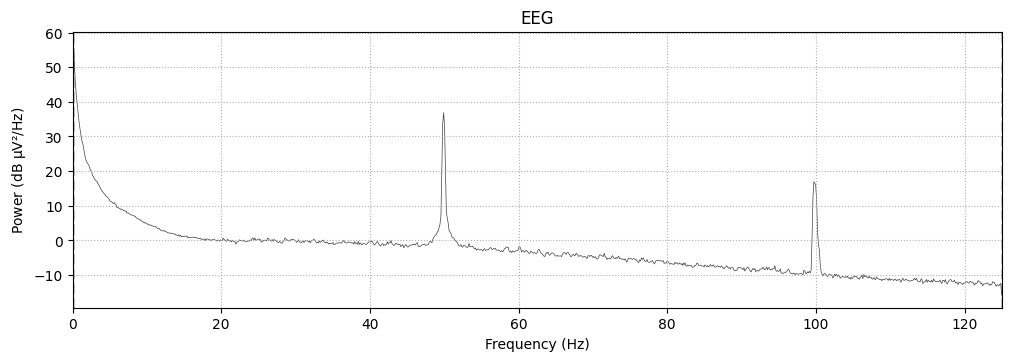

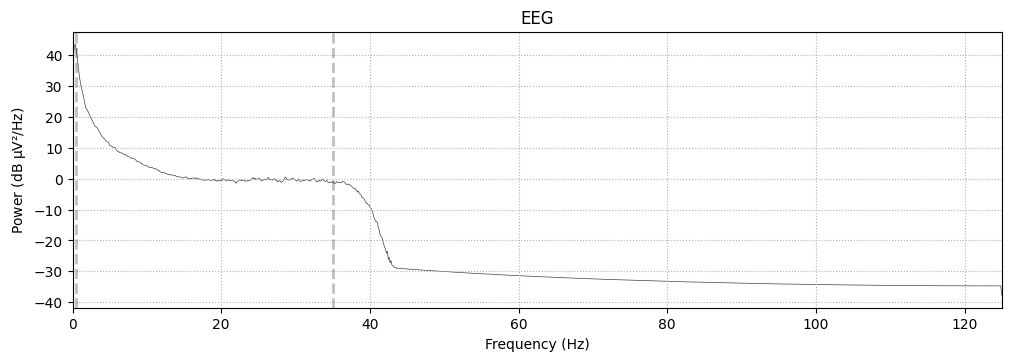

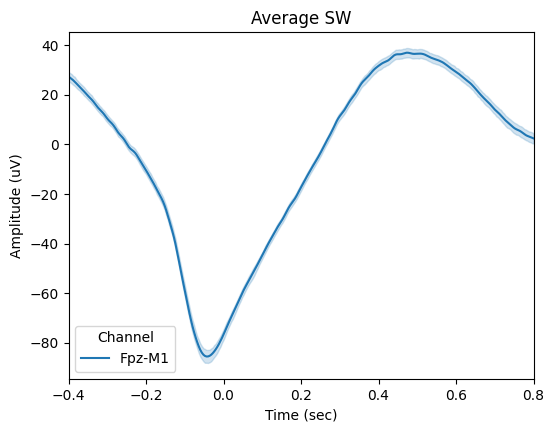

In [19]:
import pandas as pd
import run_feature_pipeline
import os
from concurrent.futures import ThreadPoolExecutor, as_completed

errors = []
dataframes = []

# Could get these working later
skip_list = ['2024-07-23-22-40-25', '2024-07-28-22-29-49', '2024-09-18-21-25-08', '2024-09-18-21-28-11']
import io
import sys
import contextlib
import traceback
from importlib import reload

import convert
reload(convert)

reload(run_feature_pipeline)

import run_yasa
reload(run_yasa)

def process_file(root, dir_name, force=False):
    output_buffer = io.StringIO()
    with contextlib.redirect_stdout(output_buffer), contextlib.redirect_stderr(output_buffer):

        try:
            input_file = os.path.join(root, dir_name, "raw.fif")
            if dir_name in skip_list:
                log(f"Skipping {dir_name}: {input_file}")
                return None, False, output_buffer.getvalue(), "Skipped"

            log(f"Processing file: {input_file}")
            if os.path.exists(input_file):
                yasa_df, cached = run_feature_pipeline.cached_pipeline(log, input_file, force or global_force)
                return yasa_df, cached, output_buffer.getvalue(), True
            else:
                log(f"File not found: {input_file}")
                return None, False, output_buffer.getvalue(), "File not found"

        except Exception as e:
            traceback.print_exc()
            msg = f"Error processing file: {input_file} - {e}"
            log(msg)
            errors.append(msg)
            return None, False, output_buffer.getvalue(), "Error: " + str(e)

# Testing
yasa_df, cached, stdout, success_or_msg = process_file("C:\\dev\\play\\brainwave-data", "2024-09-19-21-29-42", True)
stdout, success_or_msg

In [20]:
results = pd.DataFrame(columns=['dir_name', 'cached', 'stdout', 'success_or_msg'])

from tqdm.auto import tqdm

dirs = next(os.walk(input_dir))[1]
for idx, dir_name in enumerate(tqdm(dirs, desc="YASA pipeline")):
    yasa_df, cached, stdout, success_or_msg = process_file(input_dir, dir_name)
    results.loc[len(results)] = [dir_name, cached, stdout, success_or_msg]

results

YASA pipeline: 100%|██████████| 169/169 [00:14<00:00, 11.97it/s] 


,dir_name,cached,stdout,success_or_msg
0,08-07-2024--22-51-16,False,2025-04-22 07:32:37.943564 Processing file: C:...,File not found
1,09-07-2024--22-52-25,False,2025-04-22 07:32:37.944081 Processing file: C:...,File not found
2,2024-07-08-22-51-16,True,2025-04-22 07:32:37.945706 Processing file: C:...,True
3,2024-07-11-22-46-18,True,2025-04-22 07:32:37.950285 Processing file: C:...,True
4,2024-07-12-22-38-58,True,2025-04-22 07:32:37.956040 Processing file: C:...,True
...,...,...,...,...
164,2025-04-04-20-56-30,True,2025-04-22 07:32:38.598735 Processing file: C:...,True
165,2025-04-11-21-07-33,True,2025-04-22 07:32:38.602891 Processing file: C:...,True
166,2025-04-21-21-33-06,False,2025-04-22 07:32:38.607095 Processing file: C:...,True
167,compressed_files,False,2025-04-22 07:32:52.056362 Processing file: C:...,File not found


# Artifacts

In [21]:
import os
import io

from importlib import reload
import notebooks.EEGArtifacts.eeg_artifacts
reload(notebooks.EEGArtifacts.eeg_artifacts)


# Testing
artifacts_df, cached, stdout, success_or_msg = notebooks.EEGArtifacts.eeg_artifacts.process_artifacts("C:\\dev\\play\\brainwave-data", "2025-02-12-20-34-56", False)
stdout, success_or_msg

('Processing file: C:\\dev\\play\\brainwave-data\\2025-02-12-20-34-56\\raw.fif\n',
 True)

In [22]:
from importlib import reload
import notebooks.EEGArtifacts.eeg_artifacts
reload(notebooks.EEGArtifacts.eeg_artifacts)

results = pd.DataFrame(columns=['dir_name', 'cached', 'stdout', 'success_or_msg'])

dirs = next(os.walk(input_dir))[1]
for idx, dir_name in enumerate(tqdm(dirs, desc="Artifacts pipeline")):
# for idx, dir_name in enumerate(dirs):
    # print(dir_name)
    artifacts_df, cached, stdout, success_or_msg = notebooks.EEGArtifacts.eeg_artifacts.process_artifacts(input_dir, dir_name, global_force)
    results.loc[len(results)] = [dir_name, cached, stdout, success_or_msg]

results

Artifacts pipeline: 100%|██████████| 169/169 [00:02<00:00, 71.76it/s] 


,dir_name,cached,stdout,success_or_msg
0,08-07-2024--22-51-16,False,Processing file: C:\dev\play\brainwave-data\08...,File not found C:\dev\play\brainwave-data\08-0...
1,09-07-2024--22-52-25,False,Processing file: C:\dev\play\brainwave-data\09...,File not found C:\dev\play\brainwave-data\09-0...
2,2024-07-08-22-51-16,True,Processing file: C:\dev\play\brainwave-data\20...,True
3,2024-07-11-22-46-18,True,Processing file: C:\dev\play\brainwave-data\20...,True
4,2024-07-12-22-38-58,True,Processing file: C:\dev\play\brainwave-data\20...,True
...,...,...,...,...
164,2025-04-04-20-56-30,True,Processing file: C:\dev\play\brainwave-data\20...,True
165,2025-04-11-21-07-33,True,Processing file: C:\dev\play\brainwave-data\20...,True
166,2025-04-21-21-33-06,False,Processing file: C:\dev\play\brainwave-data\20...,True
167,compressed_files,False,Processing file: C:\dev\play\brainwave-data\co...,File not found C:\dev\play\brainwave-data\comp...


# Physiological pipeline

In [ ]:
import traceback
import os

from importlib import reload
import run_physical_features_pipeline
reload(run_physical_features_pipeline)
import io
import contextlib
from datetime import datetime, timedelta


def process_file_for_physical(root, dir_name, force=False):
    output_buffer = io.StringIO()
    with contextlib.redirect_stdout(output_buffer), contextlib.redirect_stderr(output_buffer):
        input_fif_file = os.path.join(root, dir_name, "raw.fif")
        input_csv_file = os.path.join(root, dir_name, "raw.yasa.csv")
    #     try:
        if os.path.exists(input_csv_file):
            yasa_df = pd.read_csv(input_csv_file)
            physical_features_df_30s, physical_features_df_1s, cached = run_physical_features_pipeline.cached_physical_features_pipeline(log, input_fif_file, yasa_df, force or global_force)
            return physical_features_df_30s, physical_features_df_1s, cached, output_buffer.getvalue(), True
        else:
            log(f"File not found: {input_fif_file} or {input_csv_file}")
            return None, None, False, output_buffer.getvalue(), "File not found"
        # except Exception as e:
        #     return None, False, output_buffer.getvalue(), (str(e) + " " + traceback.format_exc())

# Testing
# physical_features_df_30s, physical_features_df_1s, cached, stdout, success_or_msg = process_file_for_physical("C:\\dev\\play\\brainwave-data", "2025-03-20-21-22-08", True)
# # display(stdout)
# display(success_or_msg)
# # display(physical_features_df_30s)

In [25]:
from tqdm.auto import tqdm

results = pd.DataFrame(columns=['dir_name', 'cached', 'stdout', 'success_or_msg'])

dirs = next(os.walk(input_dir))[1]
for idx, dir_name in enumerate(tqdm(dirs, desc="Physiological pipeline")):
    _, _, cached, stdout, success_or_msg = process_file_for_physical(input_dir, dir_name)
    results.loc[len(results)] = [dir_name, cached, stdout, success_or_msg]

results

Physiological pipeline: 100%|██████████| 169/169 [00:06<00:00, 25.37it/s]


,dir_name,cached,stdout,success_or_msg
0,08-07-2024--22-51-16,False,2025-04-22 07:41:21.598559 File not found: C:\...,File not found
1,09-07-2024--22-52-25,False,2025-04-22 07:41:21.599081 File not found: C:\...,File not found
2,2024-07-08-22-51-16,True,2025-04-22 07:41:21.601721 Loading cached 30s ...,True
3,2024-07-11-22-46-18,True,2025-04-22 07:41:21.608225 Loading cached 30s ...,True
4,2024-07-12-22-38-58,True,2025-04-22 07:41:21.614138 Loading cached 30s ...,True
...,...,...,...,...
164,2025-04-04-20-56-30,True,2025-04-22 07:41:25.688046 Loading cached 30s ...,True
165,2025-04-11-21-07-33,True,2025-04-22 07:41:25.713931 Loading cached 30s ...,True
166,2025-04-21-21-33-06,False,2025-04-22 07:41:25.737410 Generating 30s data...,True
167,compressed_files,False,2025-04-22 07:41:28.258212 File not found: C:\...,File not found


# Post-YASA pipeline

In [26]:
import traceback
import os

from importlib import reload
import run_post_yasa_pipeline
reload(run_post_yasa_pipeline)
import yasa_features
reload(yasa_features)


def process_file_for_post_yasa(root, dir_name, force=False):
    output_buffer = io.StringIO()
    # with contextlib.redirect_stdout(output_buffer), contextlib.redirect_stderr(output_buffer):

    input_fif_file = os.path.join(root, dir_name, "raw.fif")
    input_csv_file = os.path.join(root, dir_name, "raw.yasa.csv")
    artifacts_csv_path = os.path.join(root, dir_name, "raw.artifacts.csv")

    try:
        log(f"Processing file: " + input_fif_file)
        if os.path.exists(input_fif_file) and os.path.exists(input_csv_file) and os.path.exists(artifacts_csv_path):
            yasa_df = pd.read_csv(input_csv_file)
            artifacts_df = pd.read_csv(artifacts_csv_path)
            post_yasa_df, cached = run_post_yasa_pipeline.cached_post_yasa_pipeline(log, input_fif_file, yasa_df, stats_df, artifacts_df, force or global_force)
            return post_yasa_df, cached, output_buffer.getvalue(), True
        else:
            log(f"File not found: {input_fif_file} or {input_csv_file}")
            return None, False, output_buffer.getvalue(), "File not found"
    except Exception as e:
        traceback.print_exc()
        return None, False, output_buffer.getvalue(), e

# Testing
# post_yasa_df, cached, stdout, success_or_msg = process_file_for_post_yasa("C:\\dev\\play\\brainwave-data", "2024-09-19-21-29-42", True)
# display(stdout)
# display(success_or_msg)

In [27]:
results = pd.DataFrame(columns=['dir_name', 'cached', 'stdout', 'success_or_msg'])

all_post_yasa_dfs = []

dirs = next(os.walk(input_dir))[1]
for idx, dir_name in enumerate(tqdm(dirs, desc="Post YASA pipeline")):
    post_yasa_df, cached, stdout, success_or_msg = process_file_for_post_yasa(input_dir, dir_name)
    all_post_yasa_dfs.append(post_yasa_df)
    results.loc[len(results)] = [dir_name, cached, stdout, success_or_msg]
    # error_count = len(results[results['success_or_msg'] != True])
    # if (error_count > 5):
    #     log(f"Stopping due to {error_count} errors")
    #     break

results


Post YASA pipeline:   2%|▏         | 3/169 [00:00<00:08, 18.93it/s]

2025-04-22 07:41:28.293591 Processing file: C:\dev\play\brainwave-data\08-07-2024--22-51-16\raw.fif
2025-04-22 07:41:28.293686 File not found: C:\dev\play\brainwave-data\08-07-2024--22-51-16\raw.fif or C:\dev\play\brainwave-data\08-07-2024--22-51-16\raw.yasa.csv
2025-04-22 07:41:28.294212 Processing file: C:\dev\play\brainwave-data\09-07-2024--22-52-25\raw.fif
2025-04-22 07:41:28.294264 File not found: C:\dev\play\brainwave-data\09-07-2024--22-52-25\raw.fif or C:\dev\play\brainwave-data\09-07-2024--22-52-25\raw.yasa.csv
2025-04-22 07:41:28.294834 Processing file: C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.artifacts.csv
2025-04-22 07:41:28.298094 Loading cached file C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.post_yasa.csv
2025-04-22 07:41:28.452731 Processing file: C:\dev\play\brainwave-data\2024-07-11-22-46-18\raw.fif
YASA file: C

Post YASA pipeline:   3%|▎         | 5/169 [00:00<00:35,  4.67it/s]

2025-04-22 07:41:29.220320 Processing file: C:\dev\play\brainwave-data\2024-07-13-21-41-55\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-07-13-21-41-55\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-07-13-21-41-55\raw.artifacts.csv
2025-04-22 07:41:29.224261 Loading cached file C:\dev\play\brainwave-data\2024-07-13-21-41-55\raw.post_yasa.csv


Post YASA pipeline:   4%|▎         | 6/169 [00:01<00:39,  4.11it/s]

2025-04-22 07:41:29.547835 Processing file: C:\dev\play\brainwave-data\2024-07-14-22-27-26\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-07-14-22-27-26\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-07-14-22-27-26\raw.artifacts.csv
2025-04-22 07:41:29.551956 Loading cached file C:\dev\play\brainwave-data\2024-07-14-22-27-26\raw.post_yasa.csv


Post YASA pipeline:   4%|▍         | 7/169 [00:01<00:44,  3.61it/s]

2025-04-22 07:41:29.916624 Processing file: C:\dev\play\brainwave-data\2024-07-15-09-10-07\raw.fif
2025-04-22 07:41:29.916706 File not found: C:\dev\play\brainwave-data\2024-07-15-09-10-07\raw.fif or C:\dev\play\brainwave-data\2024-07-15-09-10-07\raw.yasa.csv
2025-04-22 07:41:29.917300 Processing file: C:\dev\play\brainwave-data\2024-07-15-22-33-27\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-07-15-22-33-27\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-07-15-22-33-27\raw.artifacts.csv
2025-04-22 07:41:29.921421 Loading cached file C:\dev\play\brainwave-data\2024-07-15-22-33-27\raw.post_yasa.csv


Post YASA pipeline:   6%|▌         | 10/169 [00:02<00:35,  4.54it/s]

2025-04-22 07:41:30.253057 Processing file: C:\dev\play\brainwave-data\2024-07-16-23-14-52\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-07-16-23-14-52\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-07-16-23-14-52\raw.artifacts.csv
2025-04-22 07:41:30.256951 Loading cached file C:\dev\play\brainwave-data\2024-07-16-23-14-52\raw.post_yasa.csv
2025-04-22 07:41:30.442833 Processing file: C:\dev\play\brainwave-data\2024-07-17-22-48-49\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-07-17-22-48-49\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-07-17-22-48-49\raw.artifacts.csv
2025-04-22 07:41:30.447443 Loading cached file C:\dev\play\brainwave-data\2024-07-17-22-48-49\raw.post_yasa.csv


Post YASA pipeline:   7%|▋         | 12/169 [00:02<00:34,  4.61it/s]

2025-04-22 07:41:30.813785 Processing file: C:\dev\play\brainwave-data\2024-07-21-22-22-16\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-07-21-22-22-16\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-07-21-22-22-16\raw.artifacts.csv
2025-04-22 07:41:30.817591 Loading cached file C:\dev\play\brainwave-data\2024-07-21-22-22-16\raw.post_yasa.csv
2025-04-22 07:41:30.915003 Processing file: C:\dev\play\brainwave-data\2024-07-22-22-24-06\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-07-22-22-24-06\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-07-22-22-24-06\raw.artifacts.csv
2025-04-22 07:41:30.918876 Loading cached file C:\dev\play\brainwave-data\2024-07-22-22-24-06\raw.post_yasa.csv


Post YASA pipeline:   9%|▉         | 16/169 [00:03<00:21,  7.17it/s]

2025-04-22 07:41:31.291660 Processing file: C:\dev\play\brainwave-data\2024-07-23-22-40-25\raw.fif
2025-04-22 07:41:31.291770 File not found: C:\dev\play\brainwave-data\2024-07-23-22-40-25\raw.fif or C:\dev\play\brainwave-data\2024-07-23-22-40-25\raw.yasa.csv
2025-04-22 07:41:31.292339 Processing file: C:\dev\play\brainwave-data\2024-07-24-18-57-03\raw.fif
2025-04-22 07:41:31.292506 File not found: C:\dev\play\brainwave-data\2024-07-24-18-57-03\raw.fif or C:\dev\play\brainwave-data\2024-07-24-18-57-03\raw.yasa.csv
2025-04-22 07:41:31.293099 Processing file: C:\dev\play\brainwave-data\2024-07-24-22-42-26\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-07-24-22-42-26\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-07-24-22-42-26\raw.artifacts.csv
2025-04-22 07:41:31.297455 Loading cached file C:\dev\play\brainwave-data\2024-07-24-22-42-26\raw.post_yasa.csv
2025-04-22 07:41:31.401716 Processing file: C:\dev\play\brainwave-data\2024-07-26-22-36-26\raw.fif
YASA file: C:\dev\

Post YASA pipeline:  12%|█▏        | 20/169 [00:04<00:27,  5.44it/s]

2025-04-22 07:41:32.193360 Processing file: C:\dev\play\brainwave-data\2024-07-28-22-29-49\raw.fif
2025-04-22 07:41:32.193687 File not found: C:\dev\play\brainwave-data\2024-07-28-22-29-49\raw.fif or C:\dev\play\brainwave-data\2024-07-28-22-29-49\raw.yasa.csv
2025-04-22 07:41:32.194277 Processing file: C:\dev\play\brainwave-data\2024-08-03-22-57-15\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-08-03-22-57-15\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-08-03-22-57-15\raw.artifacts.csv
2025-04-22 07:41:32.198126 Loading cached file C:\dev\play\brainwave-data\2024-08-03-22-57-15\raw.post_yasa.csv
2025-04-22 07:41:32.384593 Processing file: C:\dev\play\brainwave-data\2024-08-18-21-33-07\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-08-18-21-33-07\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-08-18-21-33-07\raw.artifacts.csv
2025-04-22 07:41:32.388925 Loading cached file C:\dev\play\brainwave-data\2024-08-18-21-33-07\raw.post_yasa.csv


Post YASA pipeline:  12%|█▏        | 21/169 [00:04<00:32,  4.53it/s]

2025-04-22 07:41:32.763177 Processing file: C:\dev\play\brainwave-data\2024-08-19-21-43-56\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-08-19-21-43-56\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-08-19-21-43-56\raw.artifacts.csv
2025-04-22 07:41:32.769691 Loading cached file C:\dev\play\brainwave-data\2024-08-19-21-43-56\raw.post_yasa.csv


Post YASA pipeline:  13%|█▎        | 22/169 [00:04<00:35,  4.09it/s]

2025-04-22 07:41:33.094484 Processing file: C:\dev\play\brainwave-data\2024-08-20-21-17-32\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-08-20-21-17-32\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-08-20-21-17-32\raw.artifacts.csv
2025-04-22 07:41:33.100981 Loading cached file C:\dev\play\brainwave-data\2024-08-20-21-17-32\raw.post_yasa.csv


Post YASA pipeline:  14%|█▎        | 23/169 [00:05<00:36,  3.97it/s]

2025-04-22 07:41:33.370703 Processing file: C:\dev\play\brainwave-data\2024-08-21-21-40-16\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-08-21-21-40-16\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-08-21-21-40-16\raw.artifacts.csv
2025-04-22 07:41:33.374747 Loading cached file C:\dev\play\brainwave-data\2024-08-21-21-40-16\raw.post_yasa.csv


Post YASA pipeline:  15%|█▍        | 25/169 [00:05<00:33,  4.33it/s]

2025-04-22 07:41:33.627450 Processing file: C:\dev\play\brainwave-data\2024-08-22-21-26-19\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-08-22-21-26-19\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-08-22-21-26-19\raw.artifacts.csv
2025-04-22 07:41:33.631117 Loading cached file C:\dev\play\brainwave-data\2024-08-22-21-26-19\raw.post_yasa.csv
2025-04-22 07:41:33.796962 Processing file: C:\dev\play\brainwave-data\2024-08-23-21-29-46\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-08-23-21-29-46\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-08-23-21-29-46\raw.artifacts.csv
2025-04-22 07:41:33.801268 Loading cached file C:\dev\play\brainwave-data\2024-08-23-21-29-46\raw.post_yasa.csv


Post YASA pipeline:  15%|█▌        | 26/169 [00:05<00:32,  4.43it/s]

2025-04-22 07:41:34.008200 Processing file: C:\dev\play\brainwave-data\2024-08-24-21-11-51\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-08-24-21-11-51\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-08-24-21-11-51\raw.artifacts.csv
2025-04-22 07:41:34.012608 Loading cached file C:\dev\play\brainwave-data\2024-08-24-21-11-51\raw.post_yasa.csv


Post YASA pipeline:  16%|█▌        | 27/169 [00:05<00:32,  4.38it/s]

2025-04-22 07:41:34.244206 Processing file: C:\dev\play\brainwave-data\2024-08-25-21-25-33\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-08-25-21-25-33\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-08-25-21-25-33\raw.artifacts.csv
2025-04-22 07:41:34.249052 Loading cached file C:\dev\play\brainwave-data\2024-08-25-21-25-33\raw.post_yasa.csv


Post YASA pipeline:  17%|█▋        | 28/169 [00:06<00:32,  4.36it/s]

2025-04-22 07:41:34.474876 Processing file: C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.artifacts.csv
2025-04-22 07:41:34.479983 Loading cached file C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.post_yasa.csv


Post YASA pipeline:  18%|█▊        | 30/169 [00:06<00:32,  4.31it/s]

2025-04-22 07:41:34.897478 Processing file: C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.artifacts.csv
2025-04-22 07:41:34.901897 Loading cached file C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.post_yasa.csv
2025-04-22 07:41:35.001655 Processing file: C:\dev\play\brainwave-data\2024-09-02-21-42-00\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-09-02-21-42-00\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-09-02-21-42-00\raw.artifacts.csv
2025-04-22 07:41:35.005156 Loading cached file C:\dev\play\brainwave-data\2024-09-02-21-42-00\raw.post_yasa.csv


Post YASA pipeline:  19%|█▉        | 32/169 [00:06<00:25,  5.45it/s]

2025-04-22 07:41:35.113558 Processing file: C:\dev\play\brainwave-data\2024-09-03-21-10-58\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-09-03-21-10-58\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-09-03-21-10-58\raw.artifacts.csv
2025-04-22 07:41:35.117841 Loading cached file C:\dev\play\brainwave-data\2024-09-03-21-10-58\raw.post_yasa.csv
2025-04-22 07:41:35.265458 Processing file: C:\dev\play\brainwave-data\2024-09-04-21-44-08\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-09-04-21-44-08\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-09-04-21-44-08\raw.artifacts.csv
2025-04-22 07:41:35.269117 Loading cached file C:\dev\play\brainwave-data\2024-09-04-21-44-08\raw.post_yasa.csv


Post YASA pipeline:  20%|██        | 34/169 [00:07<00:20,  6.73it/s]

2025-04-22 07:41:35.379211 Processing file: C:\dev\play\brainwave-data\2024-09-05-21-32-05\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-09-05-21-32-05\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-09-05-21-32-05\raw.artifacts.csv
2025-04-22 07:41:35.383458 Loading cached file C:\dev\play\brainwave-data\2024-09-05-21-32-05\raw.post_yasa.csv
2025-04-22 07:41:35.494622 Processing file: C:\dev\play\brainwave-data\2024-09-08-21-01-39\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-09-08-21-01-39\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-09-08-21-01-39\raw.artifacts.csv
2025-04-22 07:41:35.498666 Loading cached file C:\dev\play\brainwave-data\2024-09-08-21-01-39\raw.post_yasa.csv


Post YASA pipeline:  22%|██▏       | 37/169 [00:07<00:13,  9.77it/s]

2025-04-22 07:41:35.613823 Processing file: C:\dev\play\brainwave-data\2024-09-10-21-22-21\raw.fif
2025-04-22 07:41:35.614153 File not found: C:\dev\play\brainwave-data\2024-09-10-21-22-21\raw.fif or C:\dev\play\brainwave-data\2024-09-10-21-22-21\raw.yasa.csv
2025-04-22 07:41:35.614823 Processing file: C:\dev\play\brainwave-data\2024-09-11-21-19-21\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-09-11-21-19-21\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-09-11-21-19-21\raw.artifacts.csv
2025-04-22 07:41:35.618224 Loading cached file C:\dev\play\brainwave-data\2024-09-11-21-19-21\raw.post_yasa.csv
2025-04-22 07:41:35.730706 Processing file: C:\dev\play\brainwave-data\2024-09-13-21-24-32\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-09-13-21-24-32\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-09-13-21-24-32\raw.artifacts.csv
2025-04-22 07:41:35.734400 Loading cached file C:\dev\play\brainwave-data\2024-09-13-21-24-32\raw.post_yasa.csv


Post YASA pipeline:  23%|██▎       | 39/169 [00:07<00:14,  9.20it/s]

2025-04-22 07:41:35.844492 Processing file: C:\dev\play\brainwave-data\2024-09-15-21-14-05\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-09-15-21-14-05\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-09-15-21-14-05\raw.artifacts.csv
2025-04-22 07:41:35.848863 Loading cached file C:\dev\play\brainwave-data\2024-09-15-21-14-05\raw.post_yasa.csv
2025-04-22 07:41:35.967365 Processing file: C:\dev\play\brainwave-data\2024-09-16-21-04-27\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-09-16-21-04-27\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-09-16-21-04-27\raw.artifacts.csv
2025-04-22 07:41:35.969609 Loading cached file C:\dev\play\brainwave-data\2024-09-16-21-04-27\raw.post_yasa.csv
2025-04-22 07:41:36.009252 Processing file: C:\dev\play\brainwave-data\2024-09-17-21-33-14\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-09-17-21-33-14\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-09-17-21-33-14\raw.artifacts.csv
2025-04-22 07:41:36.012

Post YASA pipeline:  24%|██▍       | 41/169 [00:07<00:12, 10.07it/s]

2025-04-22 07:41:36.132496 Processing file: C:\dev\play\brainwave-data\2024-09-18-21-28-11\raw.fif
2025-04-22 07:41:36.132719 File not found: C:\dev\play\brainwave-data\2024-09-18-21-28-11\raw.fif or C:\dev\play\brainwave-data\2024-09-18-21-28-11\raw.yasa.csv
2025-04-22 07:41:36.133249 Processing file: C:\dev\play\brainwave-data\2024-09-19-21-29-42\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-09-19-21-29-42\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-09-19-21-29-42\raw.artifacts.csv
2025-04-22 07:41:36.136325 Loading cached file C:\dev\play\brainwave-data\2024-09-19-21-29-42\raw.post_yasa.csv
2025-04-22 07:41:36.193029 YASA file C:\dev\play\brainwave-data\2024-09-19-21-29-42\raw.yasa.csv mod date 2025-04-22 07:32:37.681262 is > 2025-04-12 07:07:00.193066, rebuilding
2025-04-22 07:41:36.193078 Loading MNE file C:\dev\play\brainwave-data\2024-09-19-21-29-42\raw.fif
2025-04-22 07:41:36.193086 Reading file C:\dev\play\brainwave-data\2024-09-19-21-29-42\raw.fif
2025-0

c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\joblib\parallel.py:1847: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
c:\dev\Brainwave-Processor\yasa_features.py:223: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  psd, freqs = psd_array_multitaper(epochs, sf, adaptive=True, normalization='full', verbose=0)
c:\dev\Brainwave-Processor\yasa_features.py:223: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  psd, freqs = psd_array_multitaper(epochs, sf, adaptive=True, normalization='full', verbose=0)


    Using multitaper spectrum estimation with 7 DPSS windows


c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\joblib\parallel.py:1847: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\joblib\parallel.py:1847: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\joblib\parallel.py:1847: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\joblib\parallel.py:1847: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\joblib\parallel.py:1847: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\joblib\parallel.py:1847: RuntimeWarning: Iterative mu

2025-04-22 07:42:02.058890 All done! C:\dev\play\brainwave-data\2024-09-19-21-29-42\raw.fif
2025-04-22 07:42:02.070113 Saving to: C:\dev\play\brainwave-data\2024-09-19-21-29-42\raw.post_yasa.csv


Post YASA pipeline:  26%|██▌       | 44/169 [00:34<07:39,  3.67s/it]

2025-04-22 07:42:02.361070 Processing file: C:\dev\play\brainwave-data\2024-09-20-21-19-28\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-09-20-21-19-28\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-09-20-21-19-28\raw.artifacts.csv
2025-04-22 07:42:02.367866 Loading cached file C:\dev\play\brainwave-data\2024-09-20-21-19-28\raw.post_yasa.csv
2025-04-22 07:42:02.493049 Processing file: C:\dev\play\brainwave-data\2024-09-22-21-30-59\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-09-22-21-30-59\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-09-22-21-30-59\raw.artifacts.csv
2025-04-22 07:42:02.497051 Loading cached file C:\dev\play\brainwave-data\2024-09-22-21-30-59\raw.post_yasa.csv


Post YASA pipeline:  28%|██▊       | 47/169 [00:34<03:26,  1.69s/it]

2025-04-22 07:42:02.602321 Processing file: C:\dev\play\brainwave-data\2024-09-24-22-43-11\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-09-24-22-43-11\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-09-24-22-43-11\raw.artifacts.csv
2025-04-22 07:42:02.605459 Loading cached file C:\dev\play\brainwave-data\2024-09-24-22-43-11\raw.post_yasa.csv
2025-04-22 07:42:02.702638 Processing file: C:\dev\play\brainwave-data\2024-09-24-22-43-12\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-09-24-22-43-12\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-09-24-22-43-12\raw.artifacts.csv
2025-04-22 07:42:02.705388 Loading cached file C:\dev\play\brainwave-data\2024-09-24-22-43-12\raw.post_yasa.csv


Post YASA pipeline:  28%|██▊       | 48/169 [00:34<02:33,  1.27s/it]

2025-04-22 07:42:02.806395 Processing file: C:\dev\play\brainwave-data\2024-09-25-21-57-01\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-09-25-21-57-01\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-09-25-21-57-01\raw.artifacts.csv
2025-04-22 07:42:02.810454 Loading cached file C:\dev\play\brainwave-data\2024-09-25-21-57-01\raw.post_yasa.csv
2025-04-22 07:42:02.920939 Processing file: C:\dev\play\brainwave-data\2024-09-26-21-24-52\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-09-26-21-24-52\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-09-26-21-24-52\raw.artifacts.csv
2025-04-22 07:42:02.924116 Loading cached file C:\dev\play\brainwave-data\2024-09-26-21-24-52\raw.post_yasa.csv


Post YASA pipeline:  30%|██▉       | 50/169 [00:34<01:31,  1.30it/s]

2025-04-22 07:42:03.019713 Processing file: C:\dev\play\brainwave-data\2024-09-28-21-33-28\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-09-28-21-33-28\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-09-28-21-33-28\raw.artifacts.csv
2025-04-22 07:42:03.023082 Loading cached file C:\dev\play\brainwave-data\2024-09-28-21-33-28\raw.post_yasa.csv
2025-04-22 07:42:03.135819 Processing file: C:\dev\play\brainwave-data\2024-09-30-21-27-49\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-09-30-21-27-49\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-09-30-21-27-49\raw.artifacts.csv
2025-04-22 07:42:03.138498 Loading cached file C:\dev\play\brainwave-data\2024-09-30-21-27-49\raw.post_yasa.csv


Post YASA pipeline:  31%|███       | 52/169 [00:35<00:56,  2.06it/s]

2025-04-22 07:42:03.237762 Processing file: C:\dev\play\brainwave-data\2024-10-01-21-36-11\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-10-01-21-36-11\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-10-01-21-36-11\raw.artifacts.csv
2025-04-22 07:42:03.241226 Loading cached file C:\dev\play\brainwave-data\2024-10-01-21-36-11\raw.post_yasa.csv
2025-04-22 07:42:03.351253 Processing file: C:\dev\play\brainwave-data\2024-10-02-21-21-15\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-10-02-21-21-15\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-10-02-21-21-15\raw.artifacts.csv
2025-04-22 07:42:03.354692 Loading cached file C:\dev\play\brainwave-data\2024-10-02-21-21-15\raw.post_yasa.csv


Post YASA pipeline:  32%|███▏      | 54/169 [00:35<00:35,  3.22it/s]

2025-04-22 07:42:03.462867 Processing file: C:\dev\play\brainwave-data\2024-10-04-21-13-39\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-10-04-21-13-39\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-10-04-21-13-39\raw.artifacts.csv
2025-04-22 07:42:03.466131 Loading cached file C:\dev\play\brainwave-data\2024-10-04-21-13-39\raw.post_yasa.csv
2025-04-22 07:42:03.572193 Processing file: C:\dev\play\brainwave-data\2024-10-05-21-09-46\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-10-05-21-09-46\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-10-05-21-09-46\raw.artifacts.csv
2025-04-22 07:42:03.575742 Loading cached file C:\dev\play\brainwave-data\2024-10-05-21-09-46\raw.post_yasa.csv


Post YASA pipeline:  33%|███▎      | 56/169 [00:35<00:23,  4.76it/s]

2025-04-22 07:42:03.680505 Processing file: C:\dev\play\brainwave-data\2024-10-06-21-29-18\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-10-06-21-29-18\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-10-06-21-29-18\raw.artifacts.csv
2025-04-22 07:42:03.683515 Loading cached file C:\dev\play\brainwave-data\2024-10-06-21-29-18\raw.post_yasa.csv
2025-04-22 07:42:03.781507 Processing file: C:\dev\play\brainwave-data\2024-10-07-21-35-17\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-10-07-21-35-17\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-10-07-21-35-17\raw.artifacts.csv
2025-04-22 07:42:03.784105 Loading cached file C:\dev\play\brainwave-data\2024-10-07-21-35-17\raw.post_yasa.csv
2025-04-22 07:42:03.877145 Processing file: C:\dev\play\brainwave-data\2024-10-08-21-21-34\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-10-08-21-21-34\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-10-08-21-21-34\raw.artifacts.csv
2025-04-22 07:42:03.879

Post YASA pipeline:  35%|███▍      | 59/169 [00:35<00:16,  6.75it/s]

2025-04-22 07:42:03.975546 Processing file: C:\dev\play\brainwave-data\2024-10-09-21-22-04\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-10-09-21-22-04\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-10-09-21-22-04\raw.artifacts.csv
2025-04-22 07:42:03.979668 Loading cached file C:\dev\play\brainwave-data\2024-10-09-21-22-04\raw.post_yasa.csv
2025-04-22 07:42:04.089663 Processing file: C:\dev\play\brainwave-data\2024-10-11-21-16-27\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-10-11-21-16-27\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-10-11-21-16-27\raw.artifacts.csv
2025-04-22 07:42:04.093528 Loading cached file C:\dev\play\brainwave-data\2024-10-11-21-16-27\raw.post_yasa.csv


Post YASA pipeline:  36%|███▌      | 61/169 [00:36<00:14,  7.33it/s]

2025-04-22 07:42:04.214348 Processing file: C:\dev\play\brainwave-data\2024-10-15-22-01-52\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-10-15-22-01-52\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-10-15-22-01-52\raw.artifacts.csv
2025-04-22 07:42:04.217828 Loading cached file C:\dev\play\brainwave-data\2024-10-15-22-01-52\raw.post_yasa.csv
2025-04-22 07:42:04.335448 Processing file: C:\dev\play\brainwave-data\2024-10-20-20-09-48\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-10-20-20-09-48\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-10-20-20-09-48\raw.artifacts.csv
2025-04-22 07:42:04.337449 Loading cached file C:\dev\play\brainwave-data\2024-10-20-20-09-48\raw.post_yasa.csv
2025-04-22 07:42:04.355361 Processing file: C:\dev\play\brainwave-data\2024-10-21-21-30-18\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-10-21-21-30-18\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-10-21-21-30-18\raw.artifacts.csv
2025-04-22 07:42:04.359

Post YASA pipeline:  38%|███▊      | 65/169 [00:36<00:10,  9.54it/s]

2025-04-22 07:42:04.469340 Processing file: C:\dev\play\brainwave-data\2024-10-23-21-24-02\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-10-23-21-24-02\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-10-23-21-24-02\raw.artifacts.csv
2025-04-22 07:42:04.472797 Loading cached file C:\dev\play\brainwave-data\2024-10-23-21-24-02\raw.post_yasa.csv
2025-04-22 07:42:04.587898 Processing file: C:\dev\play\brainwave-data\2024-10-24-21-35-33\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-10-24-21-35-33\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-10-24-21-35-33\raw.artifacts.csv
2025-04-22 07:42:04.590472 Loading cached file C:\dev\play\brainwave-data\2024-10-24-21-35-33\raw.post_yasa.csv


Post YASA pipeline:  40%|███▉      | 67/169 [00:36<00:09, 11.02it/s]

2025-04-22 07:42:04.674350 Processing file: C:\dev\play\brainwave-data\2024-10-29-20-42-12\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-10-29-20-42-12\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-10-29-20-42-12\raw.artifacts.csv
2025-04-22 07:42:04.676591 Loading cached file C:\dev\play\brainwave-data\2024-10-29-20-42-12\raw.post_yasa.csv
2025-04-22 07:42:04.698969 Processing file: C:\dev\play\brainwave-data\2024-10-30-21-26-55\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-10-30-21-26-55\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-10-30-21-26-55\raw.artifacts.csv
2025-04-22 07:42:04.701906 Loading cached file C:\dev\play\brainwave-data\2024-10-30-21-26-55\raw.post_yasa.csv
2025-04-22 07:42:04.804583 Processing file: C:\dev\play\brainwave-data\2024-11-01-21-32-22\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-11-01-21-32-22\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-11-01-21-32-22\raw.artifacts.csv
2025-04-22 07:42:04.808

Post YASA pipeline:  41%|████      | 69/169 [00:36<00:09, 10.46it/s]

2025-04-22 07:42:04.904106 Processing file: C:\dev\play\brainwave-data\2024-11-02-21-29-03\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-11-02-21-29-03\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-11-02-21-29-03\raw.artifacts.csv
2025-04-22 07:42:04.907670 Loading cached file C:\dev\play\brainwave-data\2024-11-02-21-29-03\raw.post_yasa.csv
2025-04-22 07:42:05.015109 Processing file: C:\dev\play\brainwave-data\2024-11-03-21-20-37\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-11-03-21-20-37\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-11-03-21-20-37\raw.artifacts.csv
2025-04-22 07:42:05.017275 Loading cached file C:\dev\play\brainwave-data\2024-11-03-21-20-37\raw.post_yasa.csv
2025-04-22 07:42:05.038741 Processing file: C:\dev\play\brainwave-data\2024-11-04-21-20-51\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-11-04-21-20-51\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-11-04-21-20-51\raw.artifacts.csv
2025-04-22 07:42:05.042

Post YASA pipeline:  42%|████▏     | 71/169 [00:36<00:09, 10.39it/s]

2025-04-22 07:42:05.209985 Processing file: C:\dev\play\brainwave-data\2024-11-05-21-34-15\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-11-05-21-34-15\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-11-05-21-34-15\raw.artifacts.csv
2025-04-22 07:42:05.215747 Loading cached file C:\dev\play\brainwave-data\2024-11-05-21-34-15\raw.post_yasa.csv
2025-04-22 07:42:05.304263 Processing file: C:\dev\play\brainwave-data\2024-11-07-21-26-18\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-11-07-21-26-18\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-11-07-21-26-18\raw.artifacts.csv
2025-04-22 07:42:05.307597 Loading cached file C:\dev\play\brainwave-data\2024-11-07-21-26-18\raw.post_yasa.csv


Post YASA pipeline:  43%|████▎     | 73/169 [00:37<00:09,  9.98it/s]

2025-04-22 07:42:05.427512 Processing file: C:\dev\play\brainwave-data\2024-11-08-21-16-53\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-11-08-21-16-53\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-11-08-21-16-53\raw.artifacts.csv
2025-04-22 07:42:05.430868 Loading cached file C:\dev\play\brainwave-data\2024-11-08-21-16-53\raw.post_yasa.csv
2025-04-22 07:42:05.543996 Processing file: C:\dev\play\brainwave-data\2024-11-09-21-27-51\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-11-09-21-27-51\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-11-09-21-27-51\raw.artifacts.csv
2025-04-22 07:42:05.547352 Loading cached file C:\dev\play\brainwave-data\2024-11-09-21-27-51\raw.post_yasa.csv


Post YASA pipeline:  45%|████▍     | 76/169 [00:37<00:10,  9.10it/s]

2025-04-22 07:42:05.679720 Processing file: C:\dev\play\brainwave-data\2024-11-12-21-11-43\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-11-12-21-11-43\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-11-12-21-11-43\raw.artifacts.csv
2025-04-22 07:42:05.683889 Loading cached file C:\dev\play\brainwave-data\2024-11-12-21-11-43\raw.post_yasa.csv
2025-04-22 07:42:05.797061 Processing file: C:\dev\play\brainwave-data\2024-11-16-21-54-46\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-11-16-21-54-46\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-11-16-21-54-46\raw.artifacts.csv
2025-04-22 07:42:05.800681 Loading cached file C:\dev\play\brainwave-data\2024-11-16-21-54-46\raw.post_yasa.csv


Post YASA pipeline:  46%|████▌     | 78/169 [00:37<00:10,  8.84it/s]

2025-04-22 07:42:05.915713 Processing file: C:\dev\play\brainwave-data\2024-11-19-21-29-04\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-11-19-21-29-04\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-11-19-21-29-04\raw.artifacts.csv
2025-04-22 07:42:05.920222 Loading cached file C:\dev\play\brainwave-data\2024-11-19-21-29-04\raw.post_yasa.csv
2025-04-22 07:42:06.033976 Processing file: C:\dev\play\brainwave-data\2024-11-20-21-30-29\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-11-20-21-30-29\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-11-20-21-30-29\raw.artifacts.csv
2025-04-22 07:42:06.036297 Loading cached file C:\dev\play\brainwave-data\2024-11-20-21-30-29\raw.post_yasa.csv
2025-04-22 07:42:06.107470 Processing file: C:\dev\play\brainwave-data\2024-11-21-21-15-26\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-11-21-21-15-26\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-11-21-21-15-26\raw.artifacts.csv
2025-04-22 07:42:06.110

Post YASA pipeline:  47%|████▋     | 80/169 [00:37<00:09,  9.43it/s]

2025-04-22 07:42:06.223897 Processing file: C:\dev\play\brainwave-data\2024-11-22-21-30-12\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-11-22-21-30-12\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-11-22-21-30-12\raw.artifacts.csv
2025-04-22 07:42:06.226913 Loading cached file C:\dev\play\brainwave-data\2024-11-22-21-30-12\raw.post_yasa.csv
2025-04-22 07:42:06.309779 Processing file: C:\dev\play\brainwave-data\2024-11-23-21-14-58\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-11-23-21-14-58\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-11-23-21-14-58\raw.artifacts.csv
2025-04-22 07:42:06.313401 Loading cached file C:\dev\play\brainwave-data\2024-11-23-21-14-58\raw.post_yasa.csv


Post YASA pipeline:  51%|█████     | 86/169 [00:38<00:06, 13.67it/s]

2025-04-22 07:42:06.435509 Processing file: C:\dev\play\brainwave-data\2024-11-24-21-21-31\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-11-24-21-21-31\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-11-24-21-21-31\raw.artifacts.csv
2025-04-22 07:42:06.437451 Loading cached file C:\dev\play\brainwave-data\2024-11-24-21-21-31\raw.post_yasa.csv
2025-04-22 07:42:06.460956 Processing file: C:\dev\play\brainwave-data\2024-11-24-22-33-06\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-11-24-22-33-06\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-11-24-22-33-06\raw.artifacts.csv
2025-04-22 07:42:06.462760 Loading cached file C:\dev\play\brainwave-data\2024-11-24-22-33-06\raw.post_yasa.csv
2025-04-22 07:42:06.473992 Processing file: C:\dev\play\brainwave-data\2024-11-24-22-37-54\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-11-24-22-37-54\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-11-24-22-37-54\raw.artifacts.csv
2025-04-22 07:42:06.476

Post YASA pipeline:  52%|█████▏    | 88/169 [00:38<00:06, 12.40it/s]

2025-04-22 07:42:06.711891 Processing file: C:\dev\play\brainwave-data\2024-11-27-21-18-50\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-11-27-21-18-50\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-11-27-21-18-50\raw.artifacts.csv
2025-04-22 07:42:06.715285 Loading cached file C:\dev\play\brainwave-data\2024-11-27-21-18-50\raw.post_yasa.csv
2025-04-22 07:42:06.803379 Processing file: C:\dev\play\brainwave-data\2024-11-28-21-50-57\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-11-28-21-50-57\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-11-28-21-50-57\raw.artifacts.csv
2025-04-22 07:42:06.807010 Loading cached file C:\dev\play\brainwave-data\2024-11-28-21-50-57\raw.post_yasa.csv
2025-04-22 07:42:06.909951 Processing file: C:\dev\play\brainwave-data\2024-11-29-21-18-33\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-11-29-21-18-33\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-11-29-21-18-33\raw.artifacts.csv
2025-04-22 07:42:06.913

Post YASA pipeline:  54%|█████▍    | 92/169 [00:38<00:06, 11.08it/s]

2025-04-22 07:42:07.020223 Processing file: C:\dev\play\brainwave-data\2024-11-30-21-21-05\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-11-30-21-21-05\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-11-30-21-21-05\raw.artifacts.csv
2025-04-22 07:42:07.024374 Loading cached file C:\dev\play\brainwave-data\2024-11-30-21-21-05\raw.post_yasa.csv
2025-04-22 07:42:07.150863 Processing file: C:\dev\play\brainwave-data\2024-12-01-21-29-13\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-12-01-21-29-13\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-12-01-21-29-13\raw.artifacts.csv
2025-04-22 07:42:07.153264 Loading cached file C:\dev\play\brainwave-data\2024-12-01-21-29-13\raw.post_yasa.csv
2025-04-22 07:42:07.211037 Processing file: C:\dev\play\brainwave-data\2024-12-03-21-15-08\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-12-03-21-15-08\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-12-03-21-15-08\raw.artifacts.csv
2025-04-22 07:42:07.213

Post YASA pipeline:  56%|█████▌    | 94/169 [00:39<00:06, 11.55it/s]

2025-04-22 07:42:07.250475 Processing file: C:\dev\play\brainwave-data\2024-12-04-21-15-17\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-12-04-21-15-17\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-12-04-21-15-17\raw.artifacts.csv
2025-04-22 07:42:07.253773 Loading cached file C:\dev\play\brainwave-data\2024-12-04-21-15-17\raw.post_yasa.csv
2025-04-22 07:42:07.365816 Processing file: C:\dev\play\brainwave-data\2024-12-05-21-15-24\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-12-05-21-15-24\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-12-05-21-15-24\raw.artifacts.csv
2025-04-22 07:42:07.369567 Loading cached file C:\dev\play\brainwave-data\2024-12-05-21-15-24\raw.post_yasa.csv


Post YASA pipeline:  57%|█████▋    | 96/169 [00:39<00:07, 10.28it/s]

2025-04-22 07:42:07.492621 Processing file: C:\dev\play\brainwave-data\2024-12-06-21-32-04\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-12-06-21-32-04\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-12-06-21-32-04\raw.artifacts.csv
2025-04-22 07:42:07.496654 Loading cached file C:\dev\play\brainwave-data\2024-12-06-21-32-04\raw.post_yasa.csv
2025-04-22 07:42:07.612568 Processing file: C:\dev\play\brainwave-data\2024-12-07-21-19-09\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-12-07-21-19-09\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-12-07-21-19-09\raw.artifacts.csv
2025-04-22 07:42:07.616077 Loading cached file C:\dev\play\brainwave-data\2024-12-07-21-19-09\raw.post_yasa.csv


Post YASA pipeline:  58%|█████▊    | 98/169 [00:39<00:07,  9.71it/s]

2025-04-22 07:42:07.734277 Processing file: C:\dev\play\brainwave-data\2024-12-08-21-23-50\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-12-08-21-23-50\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-12-08-21-23-50\raw.artifacts.csv
2025-04-22 07:42:07.737646 Loading cached file C:\dev\play\brainwave-data\2024-12-08-21-23-50\raw.post_yasa.csv
2025-04-22 07:42:07.846247 Processing file: C:\dev\play\brainwave-data\2024-12-09-21-29-08\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-12-09-21-29-08\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-12-09-21-29-08\raw.artifacts.csv
2025-04-22 07:42:07.849813 Loading cached file C:\dev\play\brainwave-data\2024-12-09-21-29-08\raw.post_yasa.csv


Post YASA pipeline:  59%|█████▉    | 100/169 [00:39<00:07,  9.21it/s]

2025-04-22 07:42:07.968913 Processing file: C:\dev\play\brainwave-data\2024-12-10-21-14-13\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-12-10-21-14-13\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-12-10-21-14-13\raw.artifacts.csv
2025-04-22 07:42:07.972421 Loading cached file C:\dev\play\brainwave-data\2024-12-10-21-14-13\raw.post_yasa.csv
2025-04-22 07:42:08.090042 Processing file: C:\dev\play\brainwave-data\2024-12-11-21-31-37\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-12-11-21-31-37\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-12-11-21-31-37\raw.artifacts.csv
2025-04-22 07:42:08.093247 Loading cached file C:\dev\play\brainwave-data\2024-12-11-21-31-37\raw.post_yasa.csv


Post YASA pipeline:  60%|██████    | 102/169 [00:40<00:08,  8.16it/s]Traceback (most recent call last):
  File "C:\Users\graha\AppData\Local\Temp\ipykernel_35320\404251101.py", line 23, in process_file_for_post_yasa
    artifacts_df = pd.read_csv(artifacts_csv_path)
  File "c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\pandas\io\parsers\readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\pandas\io\parsers\readers.py", line 620, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
  File "c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\pandas\io\parsers\readers.py", line 1620, in __init__
    self._engine = self._make_engine(f, self.engine)
                   ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^
  File "c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\pandas\io\parsers\readers.py", line 1898, in _make_engine
    return mapping[engine](f, **self.options)
           ~~~~~~~~~~~~~~~

2025-04-22 07:42:08.217433 Processing file: C:\dev\play\brainwave-data\2024-12-12-21-20-17\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-12-12-21-20-17\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-12-12-21-20-17\raw.artifacts.csv
2025-04-22 07:42:08.224977 Loading cached file C:\dev\play\brainwave-data\2024-12-12-21-20-17\raw.post_yasa.csv
2025-04-22 07:42:08.382752 Processing file: C:\dev\play\brainwave-data\2024-12-13-21-23-37\raw.fif
2025-04-22 07:42:08.410172 Processing file: C:\dev\play\brainwave-data\2024-12-14-21-26-54\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-12-14-21-26-54\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-12-14-21-26-54\raw.artifacts.csv
2025-04-22 07:42:08.414392 Loading cached file C:\dev\play\brainwave-data\2024-12-14-21-26-54\raw.post_yasa.csv


Post YASA pipeline:  62%|██████▏   | 104/169 [00:40<00:06,  9.71it/s]

2025-04-22 07:42:08.520262 Processing file: C:\dev\play\brainwave-data\2024-12-16-21-26-57\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-12-16-21-26-57\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-12-16-21-26-57\raw.artifacts.csv
2025-04-22 07:42:08.523708 Loading cached file C:\dev\play\brainwave-data\2024-12-16-21-26-57\raw.post_yasa.csv
2025-04-22 07:42:08.640782 Processing file: C:\dev\play\brainwave-data\2024-12-17-21-24-11\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-12-17-21-24-11\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-12-17-21-24-11\raw.artifacts.csv
2025-04-22 07:42:08.645227 Loading cached file C:\dev\play\brainwave-data\2024-12-17-21-24-11\raw.post_yasa.csv


Post YASA pipeline:  63%|██████▎   | 107/169 [00:40<00:06,  9.11it/s]

2025-04-22 07:42:08.748807 Processing file: C:\dev\play\brainwave-data\2024-12-18-21-32-18\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-12-18-21-32-18\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-12-18-21-32-18\raw.artifacts.csv
2025-04-22 07:42:08.752421 Loading cached file C:\dev\play\brainwave-data\2024-12-18-21-32-18\raw.post_yasa.csv
2025-04-22 07:42:08.870723 Processing file: C:\dev\play\brainwave-data\2024-12-19-21-18-48\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-12-19-21-18-48\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-12-19-21-18-48\raw.artifacts.csv
2025-04-22 07:42:08.874146 Loading cached file C:\dev\play\brainwave-data\2024-12-19-21-18-48\raw.post_yasa.csv


Post YASA pipeline:  64%|██████▍   | 109/169 [00:40<00:06,  8.90it/s]

2025-04-22 07:42:08.990337 Processing file: C:\dev\play\brainwave-data\2024-12-20-21-31-19\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-12-20-21-31-19\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-12-20-21-31-19\raw.artifacts.csv
2025-04-22 07:42:08.994397 Loading cached file C:\dev\play\brainwave-data\2024-12-20-21-31-19\raw.post_yasa.csv
2025-04-22 07:42:09.104339 Processing file: C:\dev\play\brainwave-data\2024-12-21-21-43-12\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-12-21-21-43-12\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-12-21-21-43-12\raw.artifacts.csv
2025-04-22 07:42:09.107916 Loading cached file C:\dev\play\brainwave-data\2024-12-21-21-43-12\raw.post_yasa.csv


Post YASA pipeline:  66%|██████▌   | 111/169 [00:41<00:07,  8.17it/s]

2025-04-22 07:42:09.231075 Processing file: C:\dev\play\brainwave-data\2024-12-27-21-21-34\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-12-27-21-21-34\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-12-27-21-21-34\raw.artifacts.csv
2025-04-22 07:42:09.234532 Loading cached file C:\dev\play\brainwave-data\2024-12-27-21-21-34\raw.post_yasa.csv
2025-04-22 07:42:09.370823 Processing file: C:\dev\play\brainwave-data\2024-12-28-21-33-53\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-12-28-21-33-53\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-12-28-21-33-53\raw.artifacts.csv
2025-04-22 07:42:09.374309 Loading cached file C:\dev\play\brainwave-data\2024-12-28-21-33-53\raw.post_yasa.csv


Post YASA pipeline:  67%|██████▋   | 113/169 [00:41<00:07,  7.99it/s]

2025-04-22 07:42:09.502037 Processing file: C:\dev\play\brainwave-data\2024-12-29-21-15-24\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-12-29-21-15-24\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-12-29-21-15-24\raw.artifacts.csv
2025-04-22 07:42:09.506056 Loading cached file C:\dev\play\brainwave-data\2024-12-29-21-15-24\raw.post_yasa.csv
2025-04-22 07:42:09.628591 Processing file: C:\dev\play\brainwave-data\2024-12-30-21-34-52\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-12-30-21-34-52\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-12-30-21-34-52\raw.artifacts.csv
2025-04-22 07:42:09.632139 Loading cached file C:\dev\play\brainwave-data\2024-12-30-21-34-52\raw.post_yasa.csv


Post YASA pipeline:  68%|██████▊   | 115/169 [00:41<00:06,  7.88it/s]

2025-04-22 07:42:09.756394 Processing file: C:\dev\play\brainwave-data\2024-12-31-21-12-28\raw.fif
YASA file: C:\dev\play\brainwave-data\2024-12-31-21-12-28\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2024-12-31-21-12-28\raw.artifacts.csv
2025-04-22 07:42:09.760138 Loading cached file C:\dev\play\brainwave-data\2024-12-31-21-12-28\raw.post_yasa.csv
2025-04-22 07:42:09.885012 Processing file: C:\dev\play\brainwave-data\2025-01-01-21-42-08\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-01-01-21-42-08\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-01-01-21-42-08\raw.artifacts.csv
2025-04-22 07:42:09.888283 Loading cached file C:\dev\play\brainwave-data\2025-01-01-21-42-08\raw.post_yasa.csv


Post YASA pipeline:  69%|██████▉   | 117/169 [00:41<00:06,  8.02it/s]

2025-04-22 07:42:10.003892 Processing file: C:\dev\play\brainwave-data\2025-01-05-21-10-59\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-01-05-21-10-59\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-01-05-21-10-59\raw.artifacts.csv
2025-04-22 07:42:10.007576 Loading cached file C:\dev\play\brainwave-data\2025-01-05-21-10-59\raw.post_yasa.csv
2025-04-22 07:42:10.129130 Processing file: C:\dev\play\brainwave-data\2025-01-06-21-35-21\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-01-06-21-35-21\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-01-06-21-35-21\raw.artifacts.csv
2025-04-22 07:42:10.132828 Loading cached file C:\dev\play\brainwave-data\2025-01-06-21-35-21\raw.post_yasa.csv


Post YASA pipeline:  70%|███████   | 119/169 [00:42<00:06,  8.03it/s]

2025-04-22 07:42:10.244954 Processing file: C:\dev\play\brainwave-data\2025-01-07-21-12-58\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-01-07-21-12-58\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-01-07-21-12-58\raw.artifacts.csv
2025-04-22 07:42:10.249805 Loading cached file C:\dev\play\brainwave-data\2025-01-07-21-12-58\raw.post_yasa.csv
2025-04-22 07:42:10.375156 Processing file: C:\dev\play\brainwave-data\2025-01-08-21-41-09\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-01-08-21-41-09\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-01-08-21-41-09\raw.artifacts.csv
2025-04-22 07:42:10.379068 Loading cached file C:\dev\play\brainwave-data\2025-01-08-21-41-09\raw.post_yasa.csv


Post YASA pipeline:  72%|███████▏  | 121/169 [00:42<00:05,  8.52it/s]

2025-04-22 07:42:10.475077 Processing file: C:\dev\play\brainwave-data\2025-01-11-21-19-30\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-01-11-21-19-30\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-01-11-21-19-30\raw.artifacts.csv
2025-04-22 07:42:10.478825 Loading cached file C:\dev\play\brainwave-data\2025-01-11-21-19-30\raw.post_yasa.csv
2025-04-22 07:42:10.592863 Processing file: C:\dev\play\brainwave-data\2025-01-16-21-34-19\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-01-16-21-34-19\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-01-16-21-34-19\raw.artifacts.csv
2025-04-22 07:42:10.596945 Loading cached file C:\dev\play\brainwave-data\2025-01-16-21-34-19\raw.post_yasa.csv


Post YASA pipeline:  72%|███████▏  | 122/169 [00:42<00:05,  8.35it/s]

2025-04-22 07:42:10.718185 Processing file: C:\dev\play\brainwave-data\2025-01-17-21-32-40\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-01-17-21-32-40\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-01-17-21-32-40\raw.artifacts.csv
2025-04-22 07:42:10.721250 Loading cached file C:\dev\play\brainwave-data\2025-01-17-21-32-40\raw.post_yasa.csv
2025-04-22 07:42:10.815310 Processing file: C:\dev\play\brainwave-data\2025-01-19-22-07-23\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-01-19-22-07-23\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-01-19-22-07-23\raw.artifacts.csv
2025-04-22 07:42:10.818822 Loading cached file C:\dev\play\brainwave-data\2025-01-19-22-07-23\raw.post_yasa.csv


Post YASA pipeline:  74%|███████▍  | 125/169 [00:42<00:05,  8.68it/s]

2025-04-22 07:42:10.933841 Processing file: C:\dev\play\brainwave-data\2025-01-21-21-39-45\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-01-21-21-39-45\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-01-21-21-39-45\raw.artifacts.csv
2025-04-22 07:42:10.937487 Loading cached file C:\dev\play\brainwave-data\2025-01-21-21-39-45\raw.post_yasa.csv
2025-04-22 07:42:11.052025 Processing file: C:\dev\play\brainwave-data\2025-01-22-21-42-13\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-01-22-21-42-13\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-01-22-21-42-13\raw.artifacts.csv
2025-04-22 07:42:11.055538 Loading cached file C:\dev\play\brainwave-data\2025-01-22-21-42-13\raw.post_yasa.csv


Post YASA pipeline:  75%|███████▌  | 127/169 [00:43<00:05,  7.77it/s]

2025-04-22 07:42:11.171815 Processing file: C:\dev\play\brainwave-data\2025-01-23-21-33-32\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-01-23-21-33-32\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-01-23-21-33-32\raw.artifacts.csv
2025-04-22 07:42:11.175418 Loading cached file C:\dev\play\brainwave-data\2025-01-23-21-33-32\raw.post_yasa.csv
2025-04-22 07:42:11.333580 Processing file: C:\dev\play\brainwave-data\2025-01-27-21-31-51\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-01-27-21-31-51\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-01-27-21-31-51\raw.artifacts.csv
2025-04-22 07:42:11.340368 Loading cached file C:\dev\play\brainwave-data\2025-01-27-21-31-51\raw.post_yasa.csv


Post YASA pipeline:  76%|███████▋  | 129/169 [00:43<00:04,  8.17it/s]

2025-04-22 07:42:11.448510 Processing file: C:\dev\play\brainwave-data\2025-01-28-21-50-35\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-01-28-21-50-35\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-01-28-21-50-35\raw.artifacts.csv
2025-04-22 07:42:11.451922 Loading cached file C:\dev\play\brainwave-data\2025-01-28-21-50-35\raw.post_yasa.csv
2025-04-22 07:42:11.564801 Processing file: C:\dev\play\brainwave-data\2025-01-30-21-49-17\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-01-30-21-49-17\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-01-30-21-49-17\raw.artifacts.csv
2025-04-22 07:42:11.568426 Loading cached file C:\dev\play\brainwave-data\2025-01-30-21-49-17\raw.post_yasa.csv


Post YASA pipeline:  78%|███████▊  | 131/169 [00:43<00:04,  8.07it/s]

2025-04-22 07:42:11.694302 Processing file: C:\dev\play\brainwave-data\2025-01-31-21-45-23\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-01-31-21-45-23\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-01-31-21-45-23\raw.artifacts.csv
2025-04-22 07:42:11.698416 Loading cached file C:\dev\play\brainwave-data\2025-01-31-21-45-23\raw.post_yasa.csv
2025-04-22 07:42:11.816544 Processing file: C:\dev\play\brainwave-data\2025-02-02-21-31-45\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-02-02-21-31-45\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-02-02-21-31-45\raw.artifacts.csv
2025-04-22 07:42:11.819981 Loading cached file C:\dev\play\brainwave-data\2025-02-02-21-31-45\raw.post_yasa.csv


Post YASA pipeline:  78%|███████▊  | 132/169 [00:43<00:04,  8.20it/s]

2025-04-22 07:42:11.934079 Processing file: C:\dev\play\brainwave-data\2025-02-03-21-09-39\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-02-03-21-09-39\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-02-03-21-09-39\raw.artifacts.csv
2025-04-22 07:42:11.940803 Loading cached file C:\dev\play\brainwave-data\2025-02-03-21-09-39\raw.post_yasa.csv


Post YASA pipeline:  79%|███████▉  | 134/169 [00:44<00:05,  6.61it/s]

2025-04-22 07:42:12.184508 Processing file: C:\dev\play\brainwave-data\2025-02-04-21-21-26\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-02-04-21-21-26\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-02-04-21-21-26\raw.artifacts.csv
2025-04-22 07:42:12.188927 Loading cached file C:\dev\play\brainwave-data\2025-02-04-21-21-26\raw.post_yasa.csv
2025-04-22 07:42:12.315636 Processing file: C:\dev\play\brainwave-data\2025-02-05-21-15-57\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-02-05-21-15-57\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-02-05-21-15-57\raw.artifacts.csv
2025-04-22 07:42:12.319069 Loading cached file C:\dev\play\brainwave-data\2025-02-05-21-15-57\raw.post_yasa.csv


Post YASA pipeline:  80%|████████  | 136/169 [00:44<00:04,  7.24it/s]

2025-04-22 07:42:12.437603 Processing file: C:\dev\play\brainwave-data\2025-02-09-21-19-01\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-02-09-21-19-01\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-02-09-21-19-01\raw.artifacts.csv
2025-04-22 07:42:12.441196 Loading cached file C:\dev\play\brainwave-data\2025-02-09-21-19-01\raw.post_yasa.csv
2025-04-22 07:42:12.565186 Processing file: C:\dev\play\brainwave-data\2025-02-10-21-45-36\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-02-10-21-45-36\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-02-10-21-45-36\raw.artifacts.csv
2025-04-22 07:42:12.569145 Loading cached file C:\dev\play\brainwave-data\2025-02-10-21-45-36\raw.post_yasa.csv


Post YASA pipeline:  82%|████████▏ | 138/169 [00:44<00:04,  7.66it/s]

2025-04-22 07:42:12.698328 Processing file: C:\dev\play\brainwave-data\2025-02-11-21-47-04\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-02-11-21-47-04\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-02-11-21-47-04\raw.artifacts.csv
2025-04-22 07:42:12.701783 Loading cached file C:\dev\play\brainwave-data\2025-02-11-21-47-04\raw.post_yasa.csv
2025-04-22 07:42:12.814375 Processing file: C:\dev\play\brainwave-data\2025-02-12-20-34-56\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-02-12-20-34-56\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-02-12-20-34-56\raw.artifacts.csv
2025-04-22 07:42:12.818007 Loading cached file C:\dev\play\brainwave-data\2025-02-12-20-34-56\raw.post_yasa.csv


Post YASA pipeline:  83%|████████▎ | 140/169 [00:44<00:03,  7.96it/s]

2025-04-22 07:42:12.938264 Processing file: C:\dev\play\brainwave-data\2025-02-13-20-52-43\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-02-13-20-52-43\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-02-13-20-52-43\raw.artifacts.csv
2025-04-22 07:42:12.942174 Loading cached file C:\dev\play\brainwave-data\2025-02-13-20-52-43\raw.post_yasa.csv
2025-04-22 07:42:13.056957 Processing file: C:\dev\play\brainwave-data\2025-02-15-21-37-56\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-02-15-21-37-56\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-02-15-21-37-56\raw.artifacts.csv
2025-04-22 07:42:13.060124 Loading cached file C:\dev\play\brainwave-data\2025-02-15-21-37-56\raw.post_yasa.csv


Post YASA pipeline:  84%|████████▍ | 142/169 [00:45<00:03,  7.96it/s]

2025-04-22 07:42:13.172442 Processing file: C:\dev\play\brainwave-data\2025-02-16-21-26-48\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-02-16-21-26-48\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-02-16-21-26-48\raw.artifacts.csv
2025-04-22 07:42:13.175998 Loading cached file C:\dev\play\brainwave-data\2025-02-16-21-26-48\raw.post_yasa.csv
2025-04-22 07:42:13.305674 Processing file: C:\dev\play\brainwave-data\2025-02-17-21-43-00\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-02-17-21-43-00\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-02-17-21-43-00\raw.artifacts.csv
2025-04-22 07:42:13.308124 Loading cached file C:\dev\play\brainwave-data\2025-02-17-21-43-00\raw.post_yasa.csv
2025-04-22 07:42:13.374083 Processing file: C:\dev\play\brainwave-data\2025-02-18-21-50-50\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-02-18-21-50-50\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-02-18-21-50-50\raw.artifacts.csv
2025-04-22 07:42:13.376

Post YASA pipeline:  86%|████████▋ | 146/169 [00:45<00:02,  9.43it/s]

2025-04-22 07:42:13.479553 Processing file: C:\dev\play\brainwave-data\2025-02-19-21-29-50\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-02-19-21-29-50\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-02-19-21-29-50\raw.artifacts.csv
2025-04-22 07:42:13.482995 Loading cached file C:\dev\play\brainwave-data\2025-02-19-21-29-50\raw.post_yasa.csv
2025-04-22 07:42:13.583059 Processing file: C:\dev\play\brainwave-data\2025-02-20-21-31-45\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-02-20-21-31-45\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-02-20-21-31-45\raw.artifacts.csv
2025-04-22 07:42:13.585721 Loading cached file C:\dev\play\brainwave-data\2025-02-20-21-31-45\raw.post_yasa.csv


Post YASA pipeline:  87%|████████▋ | 147/169 [00:45<00:02,  8.73it/s]

2025-04-22 07:42:13.687050 Processing file: C:\dev\play\brainwave-data\2025-02-23-21-28-38\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-02-23-21-28-38\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-02-23-21-28-38\raw.artifacts.csv
2025-04-22 07:42:13.690823 Loading cached file C:\dev\play\brainwave-data\2025-02-23-21-28-38\raw.post_yasa.csv
2025-04-22 07:42:13.824678 Processing file: C:\dev\play\brainwave-data\2025-02-24-22-00-38\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-02-24-22-00-38\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-02-24-22-00-38\raw.artifacts.csv
2025-04-22 07:42:13.828617 Loading cached file C:\dev\play\brainwave-data\2025-02-24-22-00-38\raw.post_yasa.csv


Post YASA pipeline:  88%|████████▊ | 149/169 [00:45<00:02,  8.29it/s]

2025-04-22 07:42:13.944368 Processing file: C:\dev\play\brainwave-data\2025-02-26-21-21-01\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-02-26-21-21-01\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-02-26-21-21-01\raw.artifacts.csv
2025-04-22 07:42:13.951254 Loading cached file C:\dev\play\brainwave-data\2025-02-26-21-21-01\raw.post_yasa.csv
2025-04-22 07:42:14.076592 Processing file: C:\dev\play\brainwave-data\2025-02-27-21-22-47\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-02-27-21-22-47\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-02-27-21-22-47\raw.artifacts.csv
2025-04-22 07:42:14.080005 Loading cached file C:\dev\play\brainwave-data\2025-02-27-21-22-47\raw.post_yasa.csv


Post YASA pipeline:  89%|████████▉ | 151/169 [00:46<00:02,  7.99it/s]

2025-04-22 07:42:14.212701 Processing file: C:\dev\play\brainwave-data\2025-03-01-21-46-54\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-03-01-21-46-54\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-03-01-21-46-54\raw.artifacts.csv
2025-04-22 07:42:14.220018 Loading cached file C:\dev\play\brainwave-data\2025-03-01-21-46-54\raw.post_yasa.csv
2025-04-22 07:42:14.337800 Processing file: C:\dev\play\brainwave-data\2025-03-05-21-59-37\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-03-05-21-59-37\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-03-05-21-59-37\raw.artifacts.csv
2025-04-22 07:42:14.341197 Loading cached file C:\dev\play\brainwave-data\2025-03-05-21-59-37\raw.post_yasa.csv


Post YASA pipeline:  90%|████████▉ | 152/169 [00:46<00:02,  8.41it/s]

2025-04-22 07:42:14.441596 Processing file: C:\dev\play\brainwave-data\2025-03-07-21-50-51\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-03-07-21-50-51\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-03-07-21-50-51\raw.artifacts.csv
2025-04-22 07:42:14.445042 Loading cached file C:\dev\play\brainwave-data\2025-03-07-21-50-51\raw.post_yasa.csv
2025-04-22 07:42:14.509235 Cached file C:\dev\play\brainwave-data\2025-03-07-21-50-51\raw.post_yasa.csv mod date 2025-03-08 09:44:08.402566 is < 2025-03-11 00:00:00, rebuilding
2025-04-22 07:42:14.509277 Loading MNE file C:\dev\play\brainwave-data\2025-03-07-21-50-51\raw.fif
2025-04-22 07:42:14.509287 Reading file C:\dev\play\brainwave-data\2025-03-07-21-50-51\raw.fif
2025-04-22 07:42:14.978220 Finished reading file C:\dev\play\brainwave-data\2025-03-07-21-50-51\raw.fif
2025-04-22 07:42:15.765476 Memory Usage: 2104.12 MB GC to 2104.12 MB
2025-04-22 07:42:15.765616 Extracting YASA features
    Using multitaper spectrum estimation 

c:\dev\Brainwave-Processor\yasa_features.py:223: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  psd, freqs = psd_array_multitaper(epochs, sf, adaptive=True, normalization='full', verbose=0)
c:\dev\Brainwave-Processor\yasa_features.py:223: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  psd, freqs = psd_array_multitaper(epochs, sf, adaptive=True, normalization='full', verbose=0)
c:\dev\Brainwave-Processor\yasa_features.py:223: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  psd, freqs = psd_array_multitaper(epochs, sf, adaptive=True, normalization='full', verbose=0)
c:\dev\Brainwave-Processor\yasa_features.py:223: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  psd, freqs = psd_array_multitaper(epochs, sf, adaptive=True, normalization='full', verbose=0)
Traceback (most recent call last):
  File "c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\pandas\core\indexes\base.py", line 38

2025-04-22 07:42:24.667066 Processing file: C:\dev\play\brainwave-data\2025-03-08-21-45-12\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-03-08-21-45-12\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-03-08-21-45-12\raw.artifacts.csv
2025-04-22 07:42:24.669945 Loading cached file C:\dev\play\brainwave-data\2025-03-08-21-45-12\raw.post_yasa.csv
2025-04-22 07:42:24.772377 Processing file: C:\dev\play\brainwave-data\2025-03-12-21-43-35\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-03-12-21-43-35\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-03-12-21-43-35\raw.artifacts.csv
2025-04-22 07:42:24.775740 Loading cached file C:\dev\play\brainwave-data\2025-03-12-21-43-35\raw.post_yasa.csv


Post YASA pipeline:  93%|█████████▎| 157/169 [00:56<00:10,  1.09it/s]

2025-04-22 07:42:24.959909 Processing file: C:\dev\play\brainwave-data\2025-03-18-21-40-28\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-03-18-21-40-28\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-03-18-21-40-28\raw.artifacts.csv
2025-04-22 07:42:24.963354 Loading cached file C:\dev\play\brainwave-data\2025-03-18-21-40-28\raw.post_yasa.csv
2025-04-22 07:42:25.057014 Processing file: C:\dev\play\brainwave-data\2025-03-19-21-45-19\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-03-19-21-45-19\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-03-19-21-45-19\raw.artifacts.csv
2025-04-22 07:42:25.059514 Loading cached file C:\dev\play\brainwave-data\2025-03-19-21-45-19\raw.post_yasa.csv
2025-04-22 07:42:25.147712 Processing file: C:\dev\play\brainwave-data\2025-03-20-21-22-08\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-03-20-21-22-08\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-03-20-21-22-08\raw.artifacts.csv
2025-04-22 07:42:25.150

Post YASA pipeline:  95%|█████████▍| 160/169 [00:57<00:03,  2.26it/s]

2025-04-22 07:42:25.255647 Processing file: C:\dev\play\brainwave-data\2025-03-22-21-39-28\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-03-22-21-39-28\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-03-22-21-39-28\raw.artifacts.csv
2025-04-22 07:42:25.259028 Loading cached file C:\dev\play\brainwave-data\2025-03-22-21-39-28\raw.post_yasa.csv
2025-04-22 07:42:25.313102 Processing file: C:\dev\play\brainwave-data\2025-03-23-21-09-37\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-03-23-21-09-37\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-03-23-21-09-37\raw.artifacts.csv
2025-04-22 07:42:25.316177 Loading cached file C:\dev\play\brainwave-data\2025-03-23-21-09-37\raw.post_yasa.csv
2025-04-22 07:42:25.369994 Processing file: C:\dev\play\brainwave-data\2025-03-29-21-14-52\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-03-29-21-14-52\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-03-29-21-14-52\raw.artifacts.csv
2025-04-22 07:42:25.373

Post YASA pipeline:  97%|█████████▋| 164/169 [00:57<00:01,  4.61it/s]

2025-04-22 07:42:25.484332 Processing file: C:\dev\play\brainwave-data\2025-04-01-21-17-30\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-04-01-21-17-30\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-04-01-21-17-30\raw.artifacts.csv
2025-04-22 07:42:25.489142 Loading cached file C:\dev\play\brainwave-data\2025-04-01-21-17-30\raw.post_yasa.csv
2025-04-22 07:42:25.547022 Processing file: C:\dev\play\brainwave-data\2025-04-03-21-05-17\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-04-03-21-05-17\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-04-03-21-05-17\raw.artifacts.csv
2025-04-22 07:42:25.550170 Loading cached file C:\dev\play\brainwave-data\2025-04-03-21-05-17\raw.post_yasa.csv
2025-04-22 07:42:25.607933 Processing file: C:\dev\play\brainwave-data\2025-04-04-20-56-30\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-04-04-20-56-30\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-04-04-20-56-30\raw.artifacts.csv
2025-04-22 07:42:25.611

Post YASA pipeline:  98%|█████████▊| 166/169 [00:57<00:00,  6.10it/s]

2025-04-22 07:42:25.721486 Processing file: C:\dev\play\brainwave-data\2025-04-21-21-33-06\raw.fif
YASA file: C:\dev\play\brainwave-data\2025-04-21-21-33-06\raw.yasa.csv
Artifacts file: C:\dev\play\brainwave-data\2025-04-21-21-33-06\raw.artifacts.csv
2025-04-22 07:42:25.725784 No cached file C:\dev\play\brainwave-data\2025-04-21-21-33-06\raw.post_yasa.csv, rebuilding
2025-04-22 07:42:25.725814 Loading MNE file C:\dev\play\brainwave-data\2025-04-21-21-33-06\raw.fif
2025-04-22 07:42:25.725821 Reading file C:\dev\play\brainwave-data\2025-04-21-21-33-06\raw.fif
2025-04-22 07:42:26.038476 Finished reading file C:\dev\play\brainwave-data\2025-04-21-21-33-06\raw.fif
2025-04-22 07:42:27.011559 Memory Usage: 2382.53 MB GC to 2382.53 MB
2025-04-22 07:42:27.011692 Extracting YASA features
    Using multitaper spectrum estimation with 7 DPSS windows


c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\joblib\parallel.py:1847: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\joblib\parallel.py:1847: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\joblib\parallel.py:1847: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
c:\dev\Brainwave-Processor\yasa_features.py:223: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  psd, freqs = psd_array_multitaper(epochs, sf, adaptive=True, normalization='full', verbose=0)
c:\dev\Brainwave-Processor\yasa_features.py:223: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  psd, freqs = psd_array_multitaper(epochs, sf, adaptive=True, normalization='full', verbose=0)
c:\dev\Brainwave-Processor\ya

    Using multitaper spectrum estimation with 7 DPSS windows


c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\joblib\parallel.py:1847: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\joblib\parallel.py:1847: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\joblib\parallel.py:1847: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\joblib\parallel.py:1847: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\joblib\parallel.py:1847: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\joblib\parallel.py:1847: RuntimeWarning: Iterative mu

2025-04-22 07:42:58.594938 All done! C:\dev\play\brainwave-data\2025-04-21-21-33-06\raw.fif
2025-04-22 07:42:58.604750 Saving to: C:\dev\play\brainwave-data\2025-04-21-21-33-06\raw.post_yasa.csv


Post YASA pipeline: 100%|██████████| 169/169 [01:30<00:00,  1.87it/s]

2025-04-22 07:42:58.887618 Processing file: C:\dev\play\brainwave-data\compressed_files\raw.fif
2025-04-22 07:42:58.887793 File not found: C:\dev\play\brainwave-data\compressed_files\raw.fif or C:\dev\play\brainwave-data\compressed_files\raw.yasa.csv
2025-04-22 07:42:58.888338 Processing file: C:\dev\play\brainwave-data\nonnight\raw.fif
2025-04-22 07:42:58.888383 File not found: C:\dev\play\brainwave-data\nonnight\raw.fif or C:\dev\play\brainwave-data\nonnight\raw.yasa.csv


,dir_name,cached,stdout,success_or_msg
0,08-07-2024--22-51-16,False,,File not found
1,09-07-2024--22-52-25,False,,File not found
2,2024-07-08-22-51-16,True,,True
3,2024-07-11-22-46-18,True,,True
4,2024-07-12-22-38-58,True,,True
...,...,...,...,...
164,2025-04-04-20-56-30,True,,True
165,2025-04-11-21-07-33,True,,True
166,2025-04-21-21-33-06,False,,True
167,compressed_files,False,,File not found


# Recalculate scalings
N.b. can be run frequently but will only be picked up by new runs.  Maybe worth occasionally regenerating all old files.
And yes, for new features have to rerun the pipeline on everything, then generate the stats here, then rerun the pipeline again on everything to have them use those.

In [28]:
# post_yasa_dfs_combined = pd.concat(all_post_yasa_dfs)

In [29]:
# from scaling import only_eeg

# only_eeg_cols = list(only_eeg(post_yasa_dfs_combined).columns)
# assert any(col.startswith("Main") for col in only_eeg_cols), "No column starting with 'Main' found in only_eeg_cols"

In [30]:
# #Expensive to do every time now
# import scaling
# reload(scaling)

# stats = scaling.stats(post_yasa_dfs_combined)
# stats.to_csv(input_dir + "/stats.csv")
# # assert any(stats['Column'].str.startswith("Main")), "No row starting with 'Main' found in column_name"
# stats

# Microwakings

In [31]:
# from models.microwakings_1 import microwakings_pipeline, microwakings1
# import os

# import io

# from importlib import reload
# reload(microwakings_pipeline)
# reload(microwakings1)

# def process_microwakings(root, dir_name, force=False):
#     output_buffer = io.StringIO()
#     # with contextlib.redirect_stdout(output_buffer), contextlib.redirect_stderr(output_buffer):
#     input_fif_file = os.path.join(root, dir_name, "raw.fif")
#     input_csv_file = os.path.join(root, dir_name, "raw.post_yasa.csv")
#     try:
#         print(f"Processing file: " + input_fif_file, flush=True)
#         log(f"Processing file: " + input_fif_file)
#         tqdm.write(f"Processing file: " + input_fif_file)
#         if not os.path.exists(input_fif_file):
#             return None, False, output_buffer.getvalue(), "File not found " + input_fif_file
#         if not os.path.exists(input_csv_file):
#             return None, False, output_buffer.getvalue(), "File not found " + input_csv_file

#         post_yasa_df = pd.read_csv(input_csv_file)
#         microwakings_df, cached = microwakings_pipeline.cached_microwakings_pipeline(log, input_fif_file, post_yasa_df, force or global_force)
#         return microwakings_df, cached, output_buffer.getvalue(), True
#     except Exception as e:
#         return None, False, output_buffer.getvalue(), "Error: " + str(e)

# Testing
# microwakings_df, cached, stdout, success_or_msg = process_microwakings("C:\\dev\\play\\brainwave-data", "2025-03-20-21-22-08", False)
# stdout, success_or_msg

In [32]:
# results = pd.DataFrame(columns=['dir_name', 'cached', 'stdout', 'success_or_msg'])

# dirs = next(os.walk(input_dir))[1]
# # for idx, dir_name in enumerate(tqdm(dirs, desc="Microwakings pipeline")):
# for idx, dir_name in enumerate(dirs):
#     # print(dir_name)
#     microwakings_df, cached, stdout, success_or_msg = process_microwakings(input_dir, dir_name, global_force)
#     results.loc[len(results)] = [dir_name, cached, stdout, success_or_msg]

# results

# Post-human pipeline
This requires user interaction first to provide sleep times etc.

In [33]:
import sleep_events
from importlib import reload

reload(sleep_events)

from sleep_events import load_days_data
from sleep_events import pimp_my_days_data

days_data = load_days_data(True)

In [34]:
import models.eeg_states.eeg_states
reload(models.eeg_states.eeg_states)

from models.eeg_states.eeg_states import load_and_prepare_settling_eeg_state_events

tired_wired_eeg_state_events = load_and_prepare_settling_eeg_state_events()

c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\google\cloud\firestore_v1\base_collection.py:303: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)
c:\dev\Brainwave-Processor\models\eeg_states\eeg_states.py:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2024-10-09 20:17:27.992000+00:00' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  events.at[i, 'since'] = since_time
c:\dev\Brainwave-Processor\models\eeg_states\eeg_states.py:132: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  events['duration'] = events['timestamp'] - events['since']


In [36]:
import models.eeg_states.eeg_states
reload(models.eeg_states.eeg_states)
import run_post_human_pipeline
reload(run_post_human_pipeline)
from run_post_human_pipeline import cached_post_human_pipeline


def process_file_for_post_human(root, dir_name, force=False):
    output_buffer = io.StringIO()
    with contextlib.redirect_stdout(output_buffer), contextlib.redirect_stderr(output_buffer):

        input_fif_file = os.path.join(root, dir_name, "raw.fif")
        input_csv_file = os.path.join(root, dir_name, "raw.post_yasa.csv")
        try:
            log(f"Processing file: " + input_fif_file)
            if not os.path.exists(input_fif_file):
                return None, False, output_buffer.getvalue(), "File not found " + input_fif_file
            if not os.path.exists(input_csv_file):
                return None, False, output_buffer.getvalue(), "File not found " + input_csv_file
            post_yasa_df = pd.read_csv(input_csv_file)
            post_human_df, cached = cached_post_human_pipeline(log, dir_name, input_fif_file, stats_df, days_data, post_yasa_df, tired_wired_eeg_state_events, force or global_force)
            return post_human_df, cached, output_buffer.getvalue(), True
        except Exception as e:
            traceback.print_exc()
            return None, False, output_buffer.getvalue(), "Error: " + str(e)

# Testing
post_human_df, cached, stdout, success_or_msg = process_file_for_post_human("C:\\dev\\play\\brainwave-data", "2024-09-19-21-29-42", False)
stdout, success_or_msg

('2025-04-22 07:57:59.784404 Processing file: C:\\dev\\play\\brainwave-data\\2024-09-19-21-29-42\\raw.fif\n2025-04-22 07:57:59.842611 Loading cached file C:\\dev\\play\\brainwave-data\\2024-09-19-21-29-42\\raw.post_human.csv\n2025-04-22 07:57:59.898721 Cached file C:\\dev\\play\\brainwave-data\\2024-09-19-21-29-42\\raw.post_human.csv is missing SettlingScorePrediction, rebuilding\n\r  0%|          | 0/1179 [00:00<?, ?it/s]\r 74%|#######4  | 874/1179 [00:00<00:00, 8738.07it/s]\r100%|##########| 1179/1179 [00:00<00:00, 9127.76it/s]\n2025-04-22 07:58:00.491181 Saving to: C:\\dev\\play\\brainwave-data\\2024-09-19-21-29-42\\raw.post_human.csv\n',
 True)

In [37]:
from run_post_human_pipeline import cached_post_human_pipeline

results = pd.DataFrame(columns=['dir_name', 'cached', 'stdout', 'success_or_msg'])

dirs = next(os.walk(input_dir))[1]
for idx, dir_name in enumerate(tqdm(dirs, desc="Post human pipeline")):
    post_human_df, cached, stdout, success_or_msg = process_file_for_post_human(input_dir, dir_name, global_force   )
    results.loc[len(results)] = [dir_name, cached, stdout, success_or_msg]

results

Post human pipeline: 100%|██████████| 169/169 [05:42<00:00,  2.02s/it]


,dir_name,cached,stdout,success_or_msg
0,08-07-2024--22-51-16,False,2025-04-22 07:58:00.809865 Processing file: C:...,File not found C:\dev\play\brainwave-data\08-0...
1,09-07-2024--22-52-25,False,2025-04-22 07:58:00.810702 Processing file: C:...,File not found C:\dev\play\brainwave-data\09-0...
2,2024-07-08-22-51-16,False,2025-04-22 07:58:00.811556 Processing file: C:...,True
3,2024-07-11-22-46-18,False,2025-04-22 07:58:01.864013 Processing file: C:...,True
4,2024-07-12-22-38-58,False,2025-04-22 07:58:04.889628 Processing file: C:...,True
...,...,...,...,...
164,2025-04-04-20-56-30,False,2025-04-22 08:03:40.266743 Processing file: C:...,True
165,2025-04-11-21-07-33,False,2025-04-22 08:03:41.383617 Processing file: C:...,True
166,2025-04-21-21-33-06,False,2025-04-22 08:03:42.404174 Processing file: C:...,Error: Don't have human data yet for 2025-04-2...
167,compressed_files,False,2025-04-22 08:03:42.933956 Processing file: C:...,File not found C:\dev\play\brainwave-data\comp...


# Stitch all pipelines together

In [40]:
import stitch_pipeline_results
reload(stitch_pipeline_results)
from stitch_pipeline_results import stitch_day_optimised

import io
import contextlib
import os

def process_pipeline_stitch(root, dir_name, force=False):
    output_buffer = io.StringIO()
    with contextlib.redirect_stdout(output_buffer), contextlib.redirect_stderr(output_buffer):

        post_yasa_file = os.path.join(root, dir_name, "raw.post_yasa.csv")

        try:
            if os.path.exists(post_yasa_file):
                # Multiple consumers expect this file
                with_features = os.path.join(root, dir_name, "raw.with_features.csv")
                post_yasa_modification_time = os.path.getmtime(post_yasa_file)
                post_yasa_modification_date = datetime.fromtimestamp(post_yasa_modification_time)

                needs_creating = force

                if os.path.exists(with_features):
                    with_features_modification_time = os.path.getmtime(with_features)
                    with_features_modification_date = datetime.fromtimestamp(with_features_modification_time)

                    if post_yasa_modification_date > with_features_modification_date:
                        needs_creating = True
                        
                else:
                    needs_creating = True

                
                if needs_creating:
                    stitched = stitch_day_optimised(input_dir, dir_name, force or global_force)
                    assert("Main_eeg_sigmaabs" in stitched.columns), "Main_eeg_sigmaabs not found in stitched columns"
                    stitched.to_csv(with_features, index=False)

            return output_buffer.getvalue(), True
        except Exception as e:
            traceback.print_exc()
            return output_buffer.getvalue(), "Error: " + str(e)


def format_stdout(stdout_content):
    """
    Format stdout content to make it more readable.
    
    Args:
        stdout_content: The raw stdout string
        
    Returns:
        Formatted string with proper line breaks and indentation
    """
    import re
    
    # Replace escaped newlines with actual newlines
    formatted = re.sub(r'\\n', '\n', stdout_content)
    
    # Remove other escape sequences
    formatted = re.sub(r'\\[rt]', '', formatted)
    
    # Split into lines for better handling
    lines = formatted.split('\n')
    
    # Process traceback to add indentation
    result = []
    indent_level = 0
    
    for line in lines:
        # Adjust indentation based on traceback structure
        if 'Traceback' in line:
            result.append("\n" + line)
            indent_level = 2
        elif line.strip().startswith('File '):
            result.append(" " * indent_level + line)
            indent_level = 4  # Increase indent for the next line
        elif indent_level > 0 and line.strip():
            result.append(" " * indent_level + line)
            if not line.startswith(' '):
                indent_level = 2  # Reset indent after the error message
        else:
            result.append(line)
    
    return '\n'.join(result)

# Display the formatted stdout
from IPython.display import display, HTML

def display_formatted_stdout(stdout_content):
    formatted = format_stdout(stdout_content)
    
    # Create styled HTML output
    html = f"""
    <div style="background-color: 'black'; padding: 10px; border-radius: 5px; font-family: monospace; white-space: pre-wrap; overflow-x: auto; border: 1px solid #ddd;">
    {formatted.replace('<', '&lt;').replace('>', '&gt;')}
    </div>
    """
    
    display(HTML(html))

# Example usage
stdout, success_or_msg = process_pipeline_stitch("C:\\dev\\play\\brainwave-data", "2025-03-29-21-14-52", True)
display_formatted_stdout(stdout)

# Testing
# display(stdout)
#, success_or_msg


In [41]:
from tqdm.auto import tqdm


results = pd.DataFrame(columns=['dir_name', 'stdout', 'success_or_msg'])

dirs = next(os.walk(input_dir))[1]
for idx, dir_name in enumerate(tqdm(dirs, desc="Stitching pipelines")):
    stdout, success_or_msg = process_pipeline_stitch(input_dir, dir_name, False)
    results.loc[len(results)] = [dir_name, stdout, success_or_msg]

results

Stitching pipelines: 100%|██████████| 169/169 [00:00<00:00, 269.29it/s]


,dir_name,stdout,success_or_msg
0,08-07-2024--22-51-16,,True
1,09-07-2024--22-52-25,,True
2,2024-07-08-22-51-16,,True
3,2024-07-11-22-46-18,,True
4,2024-07-12-22-38-58,,True
...,...,...,...
164,2025-04-04-20-56-30,,True
165,2025-04-11-21-07-33,,True
166,2025-04-21-21-33-06,,True
167,compressed_files,,True


# Analyse data completeness

In [42]:
# import os
# import pandas as pd
# from datetime import datetime
#
# dfs = []
# modification_times = []
#
# for root, dirs, files in os.walk(input_dir):
#     for idx, dir_name in enumerate(dirs):
#         input_file = os.path.join(root, dir_name, "raw.post_human.csv")
#         if os.path.exists(input_file):
#             df = pd.read_csv(input_file)
#             dfs.append(df)
#
#             # Get the last modification time of the file
#             mod_time = os.path.getmtime(input_file)
#             mod_time_dt = datetime.fromtimestamp(mod_time)
#             modification_times.append(mod_time_dt)
#
# # Concatenate all dataframes
# yasa_df = pd.concat(dfs, ignore_index=True)
#
# # Calculate the number of days from today for each modification time
# today = datetime.now()
# days_since_modification = [(today - mod_time).days for mod_time in modification_times]
#
# # Create a DataFrame with the modification times and days since modification
# modification_df = pd.DataFrame({
#     'file': [os.path.join(root, dir_name, "raw.post_human.csv") for root, dirs, files in os.walk(input_dir) for dir_name in dirs if os.path.exists(os.path.join(root, dir_name, "raw.post_human.csv"))],
#     'modification_time': modification_times,
#     'days_since_modification': days_since_modification
# })
#
# modification_df

# Upload to GCS

In [43]:
# Test
import upload
from importlib import reload
reload(upload)
from upload import upload_dir_to_gcs_skipping_existing, upload_dir_to_gcs

import os
os.environ["GOOGLE_CLOUD_PROJECT"] = "examined-life-dd234" 

# Test
#upload_dir_to_gcs(lambda x: tqdm.write(x), 'examined-life-derived-eeg', "C:\\dev\\play\\brainwave-data\\2025-03-01-21-46-54", "2025-03-01-21-46-54")


In [32]:
from upload import upload_dir_to_gcs_skipping_existing
import os

errors = []
dataframes = []

from tqdm.auto import tqdm

dirs = next(os.walk(input_dir))[1]
for idx, dir_name in enumerate(tqdm(dirs)):
# for root, dirs, files in os.walk(input_dir):
#     for dir_name in reversed(dirs):
    input_file = os.path.join(input_dir, dir_name, "raw.fif")
    full_dir_name = os.path.join(input_dir, dir_name)
    try:
        upload_dir_to_gcs_skipping_existing(lambda x: tqdm.write(x), 'examined-life-derived-eeg', full_dir_name, dir_name)
    except Exception as e:
        log("Error processing file: " + input_dir)
        errors.append("Error processing file: " + input_file + " - " + str(e))
        log(e)

for error in errors:
    log(error)

log("All uploaded")

  0%|          | 0/169 [00:00<?, ?it/s]

File C:\dev\play\brainwave-data\08-07-2024--22-51-16\08-07-2024--22-51-16.brainflow.csv.bz2 modified at 2024-09-25 18:43:54
File C:\dev\play\brainwave-data\08-07-2024--22-51-16\directory_checksum.md5 modified at 2024-12-21 08:41:22
Skipping upload of C:\dev\play\brainwave-data\08-07-2024--22-51-16, no files modified since last checksum.
File C:\dev\play\brainwave-data\09-07-2024--22-52-25\09-07-2024--22-52-25.brainflow.csv.bz2 modified at 2024-09-25 18:45:04
File C:\dev\play\brainwave-data\09-07-2024--22-52-25\directory_checksum.md5 modified at 2024-12-21 08:41:24
Skipping upload of C:\dev\play\brainwave-data\09-07-2024--22-52-25, no files modified since last checksum.
File C:\dev\play\brainwave-data\2024-07-08-22-51-16\directory_checksum.md5 modified at 2025-04-12 07:14:08.346497
File C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.artifacts.csv modified at 2025-03-11 19:08:41.812881
File C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.average_slow_wave.png modified at 2025-01-1

  0%|          | 0/169 [00:11<?, ?it/s]

C:\dev\play\brainwave-data\2024-07-08-22-51-16\directory_checksum.md5 uploading to 2024-07-08-22-51-16/directory_checksum.md5, does_not_exist=False has_changed=True


  0%|          | 0/169 [00:12<?, ?it/s]

Skipping C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.artifacts.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.average_slow_wave.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.edf, identical file already exists in GCS.


  0%|          | 0/169 [00:12<?, ?it/s]

Skipping C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.fif, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.final_wake_model.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.final_wake_model_post_human.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.final_wake_model_post_human.json, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.microwakings.csv, identical file already exists in GCS.


  0%|          | 0/169 [00:12<?, ?it/s]

Skipping C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.night_events.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.physical_features.1s.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.physical_features.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.post_filter_psd_plot.png, identical file already exists in GCS.


  0%|          | 0/169 [00:12<?, ?it/s]

Skipping C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.post_human.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.post_yasa.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.pre_filter_psd_plot.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.sleep.json, identical file already exists in GCS.


  0%|          | 0/169 [00:13<?, ?it/s]

Skipping C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.sleep_stages.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.sleep_stages.F8-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.sleep_stages.O2-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.sleep_stages.T4-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.spectrogram.F8-M1.png, identical file already exists in GCS.


  0%|          | 0/169 [00:13<?, ?it/s]

Skipping C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.spectrogram.O2-M1.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.spectrogram.T4-M1.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.spindle_summary.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.sw_summary.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.with_features.csv, identical file already exists in GCS.


  2%|▏         | 3/169 [00:13<12:32,  4.53s/it]

Skipping C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.with_microwakings_multi1_debug.edf, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-08-22-51-16\raw.yasa.csv, identical file already exists in GCS.
Uploaded directory checksum for C:\dev\play\brainwave-data\2024-07-08-22-51-16 to 2024-07-08-22-51-16/directory_checksum.md5
File C:\dev\play\brainwave-data\2024-07-11-22-46-18\directory_checksum.md5 modified at 2025-04-12 07:14:21.334132
File C:\dev\play\brainwave-data\2024-07-11-22-46-18\raw.artifacts.csv modified at 2025-03-11 19:08:52.490156
File C:\dev\play\brainwave-data\2024-07-11-22-46-18\raw.average_slow_wave.png modified at 2025-01-10 17:38:12
File C:\dev\play\brainwave-data\2024-07-11-22-46-18\raw.edf modified at 2025-01-10 17:37:26
File C:\dev\play\brainwave-data\2024-07-11-22-46-18\raw.fif modified at 2024-09-09 09:06:58
File C:\dev\play\brainwave-data\2024-07-11-22-46-18\raw.final_wake_model.csv modified at 2024-12-19 17:22:26
File C:

  2%|▏         | 3/169 [00:16<12:32,  4.53s/it]

C:\dev\play\brainwave-data\2024-07-11-22-46-18\directory_checksum.md5 uploading to 2024-07-11-22-46-18/directory_checksum.md5, does_not_exist=False has_changed=True


  2%|▏         | 3/169 [00:17<12:32,  4.53s/it]

Skipping C:\dev\play\brainwave-data\2024-07-11-22-46-18\raw.artifacts.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-11-22-46-18\raw.average_slow_wave.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-11-22-46-18\raw.edf, identical file already exists in GCS.


  2%|▏         | 3/169 [00:17<12:32,  4.53s/it]

Skipping C:\dev\play\brainwave-data\2024-07-11-22-46-18\raw.fif, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-11-22-46-18\raw.final_wake_model.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-11-22-46-18\raw.final_wake_model_post_human.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-11-22-46-18\raw.final_wake_model_post_human.json, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-11-22-46-18\raw.microwakings.csv, identical file already exists in GCS.


  2%|▏         | 3/169 [00:17<12:32,  4.53s/it]

Skipping C:\dev\play\brainwave-data\2024-07-11-22-46-18\raw.night_events.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-11-22-46-18\raw.physical_features.1s.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-11-22-46-18\raw.physical_features.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-11-22-46-18\raw.post_filter_psd_plot.png, identical file already exists in GCS.


  2%|▏         | 3/169 [00:18<12:32,  4.53s/it]

Skipping C:\dev\play\brainwave-data\2024-07-11-22-46-18\raw.post_human.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-11-22-46-18\raw.post_yasa.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-11-22-46-18\raw.pre_filter_psd_plot.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-11-22-46-18\raw.sleep.json, identical file already exists in GCS.


  2%|▏         | 3/169 [00:18<12:32,  4.53s/it]

Skipping C:\dev\play\brainwave-data\2024-07-11-22-46-18\raw.sleep_stages.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-11-22-46-18\raw.sleep_stages.F8-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-11-22-46-18\raw.sleep_stages.O2-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-11-22-46-18\raw.sleep_stages.T4-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-11-22-46-18\raw.spectrogram.F8-M1.png, identical file already exists in GCS.


  2%|▏         | 3/169 [00:18<12:32,  4.53s/it]

Skipping C:\dev\play\brainwave-data\2024-07-11-22-46-18\raw.spectrogram.O2-M1.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-11-22-46-18\raw.spectrogram.T4-M1.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-11-22-46-18\raw.spindle_summary.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-11-22-46-18\raw.sw_summary.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-11-22-46-18\raw.with_features.csv, identical file already exists in GCS.


  2%|▏         | 4/169 [00:18<13:01,  4.73s/it]

Skipping C:\dev\play\brainwave-data\2024-07-11-22-46-18\raw.with_microwakings_multi1_debug.edf, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-11-22-46-18\raw.yasa.csv, identical file already exists in GCS.
Uploaded directory checksum for C:\dev\play\brainwave-data\2024-07-11-22-46-18 to 2024-07-11-22-46-18/directory_checksum.md5
File C:\dev\play\brainwave-data\2024-07-12-22-38-58\directory_checksum.md5 modified at 2025-04-12 07:14:27.377302
File C:\dev\play\brainwave-data\2024-07-12-22-38-58\raw.artifacts.csv modified at 2025-03-11 19:09:03.238924
File C:\dev\play\brainwave-data\2024-07-12-22-38-58\raw.average_slow_wave.png modified at 2025-01-10 17:39:02
File C:\dev\play\brainwave-data\2024-07-12-22-38-58\raw.edf modified at 2025-01-10 17:38:16
File C:\dev\play\brainwave-data\2024-07-12-22-38-58\raw.fif modified at 2024-09-09 09:08:56
File C:\dev\play\brainwave-data\2024-07-12-22-38-58\raw.final_wake_model.csv modified at 2024-12-19 17:22:28
File C:

  2%|▏         | 4/169 [00:21<13:01,  4.73s/it]

C:\dev\play\brainwave-data\2024-07-12-22-38-58\directory_checksum.md5 uploading to 2024-07-12-22-38-58/directory_checksum.md5, does_not_exist=False has_changed=True


  2%|▏         | 4/169 [00:22<13:01,  4.73s/it]

Skipping C:\dev\play\brainwave-data\2024-07-12-22-38-58\raw.artifacts.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-12-22-38-58\raw.average_slow_wave.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-12-22-38-58\raw.edf, identical file already exists in GCS.


  2%|▏         | 4/169 [00:22<13:01,  4.73s/it]

Skipping C:\dev\play\brainwave-data\2024-07-12-22-38-58\raw.fif, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-12-22-38-58\raw.final_wake_model.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-12-22-38-58\raw.final_wake_model_post_human.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-12-22-38-58\raw.final_wake_model_post_human.json, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-12-22-38-58\raw.microwakings.csv, identical file already exists in GCS.


  2%|▏         | 4/169 [00:22<13:01,  4.73s/it]

Skipping C:\dev\play\brainwave-data\2024-07-12-22-38-58\raw.night_events.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-12-22-38-58\raw.physical_features.1s.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-12-22-38-58\raw.physical_features.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-12-22-38-58\raw.post_filter_psd_plot.png, identical file already exists in GCS.


  2%|▏         | 4/169 [00:23<13:01,  4.73s/it]

Skipping C:\dev\play\brainwave-data\2024-07-12-22-38-58\raw.post_human.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-12-22-38-58\raw.post_yasa.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-12-22-38-58\raw.pre_filter_psd_plot.png, identical file already exists in GCS.


  2%|▏         | 4/169 [00:23<13:01,  4.73s/it]

Skipping C:\dev\play\brainwave-data\2024-07-12-22-38-58\raw.sleep.json, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-12-22-38-58\raw.sleep_stages.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-12-22-38-58\raw.sleep_stages.F8-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-12-22-38-58\raw.sleep_stages.O2-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-12-22-38-58\raw.sleep_stages.T4-M1.csv, identical file already exists in GCS.


  2%|▏         | 4/169 [00:23<13:01,  4.73s/it]

Skipping C:\dev\play\brainwave-data\2024-07-12-22-38-58\raw.spectrogram.F8-M1.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-12-22-38-58\raw.spectrogram.O2-M1.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-12-22-38-58\raw.spectrogram.T4-M1.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-12-22-38-58\raw.spindle_summary.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-12-22-38-58\raw.sw_summary.csv, identical file already exists in GCS.


  2%|▏         | 4/169 [00:23<13:01,  4.73s/it]

Skipping C:\dev\play\brainwave-data\2024-07-12-22-38-58\raw.with_features.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-12-22-38-58\raw.with_microwakings_multi1_debug.edf, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-12-22-38-58\raw.yasa.csv, identical file already exists in GCS.


  3%|▎         | 5/169 [00:23<13:14,  4.84s/it]

Uploaded directory checksum for C:\dev\play\brainwave-data\2024-07-12-22-38-58 to 2024-07-12-22-38-58/directory_checksum.md5
File C:\dev\play\brainwave-data\2024-07-13-21-41-55\directory_checksum.md5 modified at 2025-04-12 07:14:32.457447
File C:\dev\play\brainwave-data\2024-07-13-21-41-55\raw.artifacts.csv modified at 2025-03-11 19:09:11.987511
File C:\dev\play\brainwave-data\2024-07-13-21-41-55\raw.average_slow_wave.png modified at 2025-01-10 17:39:52
File C:\dev\play\brainwave-data\2024-07-13-21-41-55\raw.edf modified at 2025-01-10 17:39:10
File C:\dev\play\brainwave-data\2024-07-13-21-41-55\raw.fif modified at 2024-09-09 09:10:38
File C:\dev\play\brainwave-data\2024-07-13-21-41-55\raw.final_wake_model.csv modified at 2024-12-19 17:22:30
File C:\dev\play\brainwave-data\2024-07-13-21-41-55\raw.final_wake_model_post_human.csv modified at 2024-12-19 17:22:32
File C:\dev\play\brainwave-data\2024-07-13-21-41-55\raw.final_wake_model_post_human.json modified at 2024-12-19 17:22:32
File C:\

  3%|▎         | 5/169 [00:26<13:14,  4.84s/it]

C:\dev\play\brainwave-data\2024-07-13-21-41-55\directory_checksum.md5 uploading to 2024-07-13-21-41-55/directory_checksum.md5, does_not_exist=False has_changed=True


  3%|▎         | 5/169 [00:27<13:14,  4.84s/it]

Skipping C:\dev\play\brainwave-data\2024-07-13-21-41-55\raw.artifacts.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-13-21-41-55\raw.average_slow_wave.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-13-21-41-55\raw.edf, identical file already exists in GCS.


  3%|▎         | 5/169 [00:27<13:14,  4.84s/it]

Skipping C:\dev\play\brainwave-data\2024-07-13-21-41-55\raw.fif, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-13-21-41-55\raw.final_wake_model.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-13-21-41-55\raw.final_wake_model_post_human.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-13-21-41-55\raw.final_wake_model_post_human.json, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-13-21-41-55\raw.microwakings.csv, identical file already exists in GCS.


  3%|▎         | 5/169 [00:27<13:14,  4.84s/it]

Skipping C:\dev\play\brainwave-data\2024-07-13-21-41-55\raw.night_events.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-13-21-41-55\raw.physical_features.1s.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-13-21-41-55\raw.physical_features.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-13-21-41-55\raw.post_filter_psd_plot.png, identical file already exists in GCS.


  3%|▎         | 5/169 [00:27<13:14,  4.84s/it]

Skipping C:\dev\play\brainwave-data\2024-07-13-21-41-55\raw.post_human.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-13-21-41-55\raw.post_yasa.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-13-21-41-55\raw.pre_filter_psd_plot.png, identical file already exists in GCS.


Skipping C:\dev\play\brainwave-data\2024-07-13-21-41-55\raw.sleep.json, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-13-21-41-55\raw.sleep_stages.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-13-21-41-55\raw.sleep_stages.F8-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-13-21-41-55\raw.sleep_stages.O2-M1.csv, identical file already exists in GCS.


  3%|▎         | 5/169 [00:28<13:14,  4.84s/it]

Skipping C:\dev\play\brainwave-data\2024-07-13-21-41-55\raw.sleep_stages.T4-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-13-21-41-55\raw.spectrogram.F8-M1.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-13-21-41-55\raw.spectrogram.O2-M1.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-13-21-41-55\raw.spectrogram.T4-M1.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-13-21-41-55\raw.spindle_summary.csv, identical file already exists in GCS.


  3%|▎         | 5/169 [00:28<13:14,  4.84s/it]

Skipping C:\dev\play\brainwave-data\2024-07-13-21-41-55\raw.sw_summary.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-13-21-41-55\raw.with_features.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-13-21-41-55\raw.with_microwakings_multi1_debug.edf, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-13-21-41-55\raw.yasa.csv, identical file already exists in GCS.


  4%|▎         | 6/169 [00:28<13:12,  4.86s/it]

Uploaded directory checksum for C:\dev\play\brainwave-data\2024-07-13-21-41-55 to 2024-07-13-21-41-55/directory_checksum.md5
File C:\dev\play\brainwave-data\2024-07-14-22-27-26\directory_checksum.md5 modified at 2025-04-12 07:14:37.554784
File C:\dev\play\brainwave-data\2024-07-14-22-27-26\raw.artifacts.csv modified at 2025-03-11 19:09:21.417455
File C:\dev\play\brainwave-data\2024-07-14-22-27-26\raw.average_slow_wave.png modified at 2025-01-10 17:40:40
File C:\dev\play\brainwave-data\2024-07-14-22-27-26\raw.edf modified at 2025-01-10 17:39:58
File C:\dev\play\brainwave-data\2024-07-14-22-27-26\raw.fif modified at 2024-09-09 09:12:26
File C:\dev\play\brainwave-data\2024-07-14-22-27-26\raw.final_wake_model.csv modified at 2024-12-19 17:22:34
File C:\dev\play\brainwave-data\2024-07-14-22-27-26\raw.final_wake_model_post_human.csv modified at 2024-12-19 17:22:36
File C:\dev\play\brainwave-data\2024-07-14-22-27-26\raw.final_wake_model_post_human.json modified at 2024-12-19 17:22:38
File C:\

  4%|▎         | 6/169 [00:32<13:12,  4.86s/it]

C:\dev\play\brainwave-data\2024-07-14-22-27-26\directory_checksum.md5 uploading to 2024-07-14-22-27-26/directory_checksum.md5, does_not_exist=False has_changed=True


  4%|▎         | 6/169 [00:32<13:12,  4.86s/it]

Skipping C:\dev\play\brainwave-data\2024-07-14-22-27-26\raw.artifacts.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-14-22-27-26\raw.average_slow_wave.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-14-22-27-26\raw.edf, identical file already exists in GCS.


  4%|▎         | 6/169 [00:32<13:12,  4.86s/it]

Skipping C:\dev\play\brainwave-data\2024-07-14-22-27-26\raw.fif, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-14-22-27-26\raw.final_wake_model.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-14-22-27-26\raw.final_wake_model_post_human.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-14-22-27-26\raw.final_wake_model_post_human.json, identical file already exists in GCS.


  4%|▎         | 6/169 [00:33<13:12,  4.86s/it]

Skipping C:\dev\play\brainwave-data\2024-07-14-22-27-26\raw.microwakings.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-14-22-27-26\raw.night_events.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-14-22-27-26\raw.physical_features.1s.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-14-22-27-26\raw.physical_features.csv, identical file already exists in GCS.


  4%|▎         | 6/169 [00:33<13:12,  4.86s/it]

Skipping C:\dev\play\brainwave-data\2024-07-14-22-27-26\raw.post_filter_psd_plot.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-14-22-27-26\raw.post_human.csv, identical file already exists in GCS.


  4%|▎         | 6/169 [00:33<13:12,  4.86s/it]

Skipping C:\dev\play\brainwave-data\2024-07-14-22-27-26\raw.post_yasa.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-14-22-27-26\raw.pre_filter_psd_plot.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-14-22-27-26\raw.sleep.json, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-14-22-27-26\raw.sleep_stages.csv, identical file already exists in GCS.


  4%|▎         | 6/169 [00:33<13:12,  4.86s/it]

Skipping C:\dev\play\brainwave-data\2024-07-14-22-27-26\raw.sleep_stages.F8-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-14-22-27-26\raw.sleep_stages.O2-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-14-22-27-26\raw.sleep_stages.T4-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-14-22-27-26\raw.spectrogram.F8-M1.png, identical file already exists in GCS.


  4%|▎         | 6/169 [00:34<13:12,  4.86s/it]

Skipping C:\dev\play\brainwave-data\2024-07-14-22-27-26\raw.spectrogram.O2-M1.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-14-22-27-26\raw.spectrogram.T4-M1.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-14-22-27-26\raw.spindle_summary.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-14-22-27-26\raw.sw_summary.csv, identical file already exists in GCS.


  4%|▎         | 6/169 [00:34<13:12,  4.86s/it]

Skipping C:\dev\play\brainwave-data\2024-07-14-22-27-26\raw.with_features.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-14-22-27-26\raw.with_microwakings_multi1_debug.edf, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-14-22-27-26\raw.yasa.csv, identical file already exists in GCS.


  4%|▍         | 7/169 [00:34<13:42,  5.08s/it]

Uploaded directory checksum for C:\dev\play\brainwave-data\2024-07-14-22-27-26 to 2024-07-14-22-27-26/directory_checksum.md5
File C:\dev\play\brainwave-data\2024-07-15-09-10-07\2024-07-15-09-10-07.brainflow.csv.bz2 modified at 2024-09-25 18:47:10
File C:\dev\play\brainwave-data\2024-07-15-09-10-07\directory_checksum.md5 modified at 2024-12-21 08:41:38
Skipping upload of C:\dev\play\brainwave-data\2024-07-15-09-10-07, no files modified since last checksum.
File C:\dev\play\brainwave-data\2024-07-15-22-33-27\directory_checksum.md5 modified at 2025-04-12 07:14:42.509977
File C:\dev\play\brainwave-data\2024-07-15-22-33-27\raw.artifacts.csv modified at 2025-03-11 19:09:31.070780
File C:\dev\play\brainwave-data\2024-07-15-22-33-27\raw.average_slow_wave.png modified at 2025-01-10 17:41:26
File C:\dev\play\brainwave-data\2024-07-15-22-33-27\raw.edf modified at 2025-01-10 17:40:44
File C:\dev\play\brainwave-data\2024-07-15-22-33-27\raw.fif modified at 2024-09-09 09:14:12
File C:\dev\play\brainw

  4%|▍         | 7/169 [00:37<13:42,  5.08s/it]

C:\dev\play\brainwave-data\2024-07-15-22-33-27\directory_checksum.md5 uploading to 2024-07-15-22-33-27/directory_checksum.md5, does_not_exist=False has_changed=True


  4%|▍         | 7/169 [00:37<13:42,  5.08s/it]

Skipping C:\dev\play\brainwave-data\2024-07-15-22-33-27\raw.artifacts.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-15-22-33-27\raw.average_slow_wave.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-15-22-33-27\raw.edf, identical file already exists in GCS.


  4%|▍         | 7/169 [00:38<13:42,  5.08s/it]

Skipping C:\dev\play\brainwave-data\2024-07-15-22-33-27\raw.fif, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-15-22-33-27\raw.final_wake_model.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-15-22-33-27\raw.final_wake_model_post_human.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-15-22-33-27\raw.final_wake_model_post_human.json, identical file already exists in GCS.


  4%|▍         | 7/169 [00:38<13:42,  5.08s/it]

Skipping C:\dev\play\brainwave-data\2024-07-15-22-33-27\raw.microwakings.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-15-22-33-27\raw.night_events.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-15-22-33-27\raw.physical_features.1s.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-15-22-33-27\raw.physical_features.csv, identical file already exists in GCS.


  4%|▍         | 7/169 [00:38<13:42,  5.08s/it]

Skipping C:\dev\play\brainwave-data\2024-07-15-22-33-27\raw.post_filter_psd_plot.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-15-22-33-27\raw.post_human.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-15-22-33-27\raw.post_yasa.csv, identical file already exists in GCS.


  4%|▍         | 7/169 [00:38<13:42,  5.08s/it]

Skipping C:\dev\play\brainwave-data\2024-07-15-22-33-27\raw.pre_filter_psd_plot.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-15-22-33-27\raw.sleep.json, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-15-22-33-27\raw.sleep_stages.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-15-22-33-27\raw.sleep_stages.F8-M1.csv, identical file already exists in GCS.


  4%|▍         | 7/169 [00:38<13:42,  5.08s/it]

Skipping C:\dev\play\brainwave-data\2024-07-15-22-33-27\raw.sleep_stages.O2-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-15-22-33-27\raw.sleep_stages.T4-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-15-22-33-27\raw.spectrogram.F8-M1.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-15-22-33-27\raw.spectrogram.O2-M1.png, identical file already exists in GCS.


  4%|▍         | 7/169 [00:39<13:42,  5.08s/it]

Skipping C:\dev\play\brainwave-data\2024-07-15-22-33-27\raw.spectrogram.T4-M1.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-15-22-33-27\raw.spindle_summary.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-15-22-33-27\raw.sw_summary.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-15-22-33-27\raw.with_features.csv, identical file already exists in GCS.


  5%|▌         | 9/169 [00:39<10:20,  3.88s/it]

Skipping C:\dev\play\brainwave-data\2024-07-15-22-33-27\raw.with_microwakings_multi1_debug.edf, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-15-22-33-27\raw.yasa.csv, identical file already exists in GCS.
Uploaded directory checksum for C:\dev\play\brainwave-data\2024-07-15-22-33-27 to 2024-07-15-22-33-27/directory_checksum.md5
File C:\dev\play\brainwave-data\2024-07-16-23-14-52\2024-07-16-23-14-52.brainflow.csv.bz2 modified at 2024-09-25 18:41:04
File C:\dev\play\brainwave-data\2024-07-16-23-14-52\directory_checksum.md5 modified at 2025-04-12 07:14:47.550703
File C:\dev\play\brainwave-data\2024-07-16-23-14-52\raw.artifacts.csv modified at 2025-03-11 19:09:38.183764
File C:\dev\play\brainwave-data\2024-07-16-23-14-52\raw.average_slow_wave.png modified at 2025-01-10 17:42:00
File C:\dev\play\brainwave-data\2024-07-16-23-14-52\raw.edf modified at 2025-01-10 17:41:30
File C:\dev\play\brainwave-data\2024-07-16-23-14-52\raw.fif modified at 2024-09-09 09:

  5%|▌         | 9/169 [00:42<10:20,  3.88s/it]

Skipping C:\dev\play\brainwave-data\2024-07-16-23-14-52\2024-07-16-23-14-52.brainflow.csv.bz2, identical file already exists in GCS.
C:\dev\play\brainwave-data\2024-07-16-23-14-52\directory_checksum.md5 uploading to 2024-07-16-23-14-52/directory_checksum.md5, does_not_exist=False has_changed=True


  5%|▌         | 9/169 [00:42<10:20,  3.88s/it]

Skipping C:\dev\play\brainwave-data\2024-07-16-23-14-52\raw.artifacts.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-16-23-14-52\raw.average_slow_wave.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-16-23-14-52\raw.edf, identical file already exists in GCS.


  5%|▌         | 9/169 [00:43<10:20,  3.88s/it]

Skipping C:\dev\play\brainwave-data\2024-07-16-23-14-52\raw.fif, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-16-23-14-52\raw.fif.bz2, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-16-23-14-52\raw.final_wake_model.csv, identical file already exists in GCS.


  5%|▌         | 9/169 [00:43<10:20,  3.88s/it]

Skipping C:\dev\play\brainwave-data\2024-07-16-23-14-52\raw.final_wake_model_post_human.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-16-23-14-52\raw.final_wake_model_post_human.json, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-16-23-14-52\raw.microwakings.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-16-23-14-52\raw.night_events.csv, identical file already exists in GCS.


  5%|▌         | 9/169 [00:43<10:20,  3.88s/it]

Skipping C:\dev\play\brainwave-data\2024-07-16-23-14-52\raw.physical_features.1s.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-16-23-14-52\raw.physical_features.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-16-23-14-52\raw.post_filter_psd_plot.png, identical file already exists in GCS.


  5%|▌         | 9/169 [00:43<10:20,  3.88s/it]

Skipping C:\dev\play\brainwave-data\2024-07-16-23-14-52\raw.post_human.csv, identical file already exists in GCS.


  5%|▌         | 9/169 [00:44<10:20,  3.88s/it]

Skipping C:\dev\play\brainwave-data\2024-07-16-23-14-52\raw.post_yasa.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-16-23-14-52\raw.pre_filter_psd_plot.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-16-23-14-52\raw.sleep.json, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-16-23-14-52\raw.sleep_stages.csv, identical file already exists in GCS.


  5%|▌         | 9/169 [00:44<10:20,  3.88s/it]

Skipping C:\dev\play\brainwave-data\2024-07-16-23-14-52\raw.sleep_stages.F8-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-16-23-14-52\raw.sleep_stages.O2-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-16-23-14-52\raw.sleep_stages.T4-M1.csv, identical file already exists in GCS.


  5%|▌         | 9/169 [00:44<10:20,  3.88s/it]

Skipping C:\dev\play\brainwave-data\2024-07-16-23-14-52\raw.spectrogram.F8-M1.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-16-23-14-52\raw.spectrogram.O2-M1.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-16-23-14-52\raw.spectrogram.T4-M1.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-16-23-14-52\raw.spindle_summary.csv, identical file already exists in GCS.


  5%|▌         | 9/169 [00:44<10:20,  3.88s/it]

Skipping C:\dev\play\brainwave-data\2024-07-16-23-14-52\raw.sw_summary.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-16-23-14-52\raw.with_features.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-16-23-14-52\raw.with_microwakings_multi1_debug.edf, identical file already exists in GCS.


  6%|▌         | 10/169 [00:45<11:31,  4.35s/it]

Skipping C:\dev\play\brainwave-data\2024-07-16-23-14-52\raw.yasa.csv, identical file already exists in GCS.
Uploaded directory checksum for C:\dev\play\brainwave-data\2024-07-16-23-14-52 to 2024-07-16-23-14-52/directory_checksum.md5
File C:\dev\play\brainwave-data\2024-07-17-22-48-49\directory_checksum.md5 modified at 2025-04-12 07:14:52.650696
File C:\dev\play\brainwave-data\2024-07-17-22-48-49\raw.artifacts.csv modified at 2025-03-11 19:09:48.838454
File C:\dev\play\brainwave-data\2024-07-17-22-48-49\raw.average_slow_wave.png modified at 2025-01-10 17:42:48
File C:\dev\play\brainwave-data\2024-07-17-22-48-49\raw.edf modified at 2025-01-10 17:42:02
File C:\dev\play\brainwave-data\2024-07-17-22-48-49\raw.fif modified at 2024-09-09 09:17:22
File C:\dev\play\brainwave-data\2024-07-17-22-48-49\raw.final_wake_model.csv modified at 2024-12-19 17:22:58
File C:\dev\play\brainwave-data\2024-07-17-22-48-49\raw.final_wake_model_post_human.csv modified at 2024-12-19 17:23:00
File C:\dev\play\brai

  6%|▌         | 10/169 [00:49<11:31,  4.35s/it]

C:\dev\play\brainwave-data\2024-07-17-22-48-49\directory_checksum.md5 uploading to 2024-07-17-22-48-49/directory_checksum.md5, does_not_exist=False has_changed=True


  6%|▌         | 10/169 [00:49<11:31,  4.35s/it]

Skipping C:\dev\play\brainwave-data\2024-07-17-22-48-49\raw.artifacts.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-17-22-48-49\raw.average_slow_wave.png, identical file already exists in GCS.


  6%|▌         | 10/169 [00:49<11:31,  4.35s/it]

Skipping C:\dev\play\brainwave-data\2024-07-17-22-48-49\raw.edf, identical file already exists in GCS.


  6%|▌         | 10/169 [00:50<11:31,  4.35s/it]

Skipping C:\dev\play\brainwave-data\2024-07-17-22-48-49\raw.fif, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-17-22-48-49\raw.final_wake_model.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-17-22-48-49\raw.final_wake_model_post_human.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-17-22-48-49\raw.final_wake_model_post_human.json, identical file already exists in GCS.


  6%|▌         | 10/169 [00:50<11:31,  4.35s/it]

Skipping C:\dev\play\brainwave-data\2024-07-17-22-48-49\raw.microwakings.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-17-22-48-49\raw.night_events.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-17-22-48-49\raw.physical_features.1s.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-17-22-48-49\raw.physical_features.csv, identical file already exists in GCS.


  6%|▌         | 10/169 [00:50<11:31,  4.35s/it]

Skipping C:\dev\play\brainwave-data\2024-07-17-22-48-49\raw.post_filter_psd_plot.png, identical file already exists in GCS.


  6%|▌         | 10/169 [00:51<11:31,  4.35s/it]

Skipping C:\dev\play\brainwave-data\2024-07-17-22-48-49\raw.post_human.csv, identical file already exists in GCS.


  6%|▌         | 10/169 [00:51<11:31,  4.35s/it]

Skipping C:\dev\play\brainwave-data\2024-07-17-22-48-49\raw.post_yasa.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-17-22-48-49\raw.pre_filter_psd_plot.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-17-22-48-49\raw.sleep.json, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-17-22-48-49\raw.sleep_stages.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-17-22-48-49\raw.sleep_stages.F8-M1.csv, identical file already exists in GCS.


  6%|▌         | 10/169 [00:51<11:31,  4.35s/it]

Skipping C:\dev\play\brainwave-data\2024-07-17-22-48-49\raw.sleep_stages.O2-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-17-22-48-49\raw.sleep_stages.T4-M1.csv, identical file already exists in GCS.


  6%|▌         | 10/169 [00:52<11:31,  4.35s/it]

Skipping C:\dev\play\brainwave-data\2024-07-17-22-48-49\raw.spectrogram.F8-M1.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-17-22-48-49\raw.spectrogram.O2-M1.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-17-22-48-49\raw.spectrogram.T4-M1.png, identical file already exists in GCS.


  6%|▌         | 10/169 [00:52<11:31,  4.35s/it]

Skipping C:\dev\play\brainwave-data\2024-07-17-22-48-49\raw.spindle_summary.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-17-22-48-49\raw.sw_summary.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-17-22-48-49\raw.with_features.csv, identical file already exists in GCS.


  7%|▋         | 11/169 [00:52<13:34,  5.16s/it]

Skipping C:\dev\play\brainwave-data\2024-07-17-22-48-49\raw.with_microwakings_multi1_debug.edf, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-17-22-48-49\raw.yasa.csv, identical file already exists in GCS.
Uploaded directory checksum for C:\dev\play\brainwave-data\2024-07-17-22-48-49 to 2024-07-17-22-48-49/directory_checksum.md5
File C:\dev\play\brainwave-data\2024-07-21-22-22-16\directory_checksum.md5 modified at 2025-04-12 07:14:57.494529
File C:\dev\play\brainwave-data\2024-07-21-22-22-16\raw.artifacts.csv modified at 2025-03-11 19:09:53.245711
File C:\dev\play\brainwave-data\2024-07-21-22-22-16\raw.average_slow_wave.png modified at 2025-01-10 17:43:10
File C:\dev\play\brainwave-data\2024-07-21-22-22-16\raw.edf modified at 2025-01-10 17:42:52
File C:\dev\play\brainwave-data\2024-07-21-22-22-16\raw.fif modified at 2024-09-09 09:18:12
File C:\dev\play\brainwave-data\2024-07-21-22-22-16\raw.final_wake_model.csv modified at 2024-12-19 17:23:06


  7%|▋         | 11/169 [00:52<13:34,  5.16s/it]

File C:\dev\play\brainwave-data\2024-07-21-22-22-16\raw.final_wake_model_post_human.csv modified at 2024-12-19 17:23:08
File C:\dev\play\brainwave-data\2024-07-21-22-22-16\raw.final_wake_model_post_human.json modified at 2024-12-19 17:23:08
File C:\dev\play\brainwave-data\2024-07-21-22-22-16\raw.microwakings.csv modified at 2025-01-08 11:14:40
File C:\dev\play\brainwave-data\2024-07-21-22-22-16\raw.night_events.csv modified at 2024-12-02 03:13:12
File C:\dev\play\brainwave-data\2024-07-21-22-22-16\raw.physical_features.1s.csv modified at 2025-03-20 07:41:34.814641
File C:\dev\play\brainwave-data\2024-07-21-22-22-16\raw.physical_features.csv modified at 2025-01-10 18:32:22
File C:\dev\play\brainwave-data\2024-07-21-22-22-16\raw.post_filter_psd_plot.png modified at 2025-01-10 17:42:56
File C:\dev\play\brainwave-data\2024-07-21-22-22-16\raw.post_human.csv modified at 2025-04-22 07:58:21.841672


  7%|▋         | 11/169 [00:55<13:34,  5.16s/it]

C:\dev\play\brainwave-data\2024-07-21-22-22-16\directory_checksum.md5 uploading to 2024-07-21-22-22-16/directory_checksum.md5, does_not_exist=False has_changed=True


  7%|▋         | 11/169 [00:56<13:34,  5.16s/it]

Skipping C:\dev\play\brainwave-data\2024-07-21-22-22-16\raw.artifacts.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-21-22-22-16\raw.average_slow_wave.png, identical file already exists in GCS.


  7%|▋         | 11/169 [00:56<13:34,  5.16s/it]

Skipping C:\dev\play\brainwave-data\2024-07-21-22-22-16\raw.edf, identical file already exists in GCS.


  7%|▋         | 11/169 [00:56<13:34,  5.16s/it]

Skipping C:\dev\play\brainwave-data\2024-07-21-22-22-16\raw.fif, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-21-22-22-16\raw.final_wake_model.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-21-22-22-16\raw.final_wake_model_post_human.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-21-22-22-16\raw.final_wake_model_post_human.json, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-21-22-22-16\raw.microwakings.csv, identical file already exists in GCS.


  7%|▋         | 11/169 [00:57<13:34,  5.16s/it]

Skipping C:\dev\play\brainwave-data\2024-07-21-22-22-16\raw.night_events.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-21-22-22-16\raw.physical_features.1s.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-21-22-22-16\raw.physical_features.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-21-22-22-16\raw.post_filter_psd_plot.png, identical file already exists in GCS.


  7%|▋         | 11/169 [00:57<13:34,  5.16s/it]

Skipping C:\dev\play\brainwave-data\2024-07-21-22-22-16\raw.post_human.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-21-22-22-16\raw.post_yasa.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-21-22-22-16\raw.pre_filter_psd_plot.png, identical file already exists in GCS.


  7%|▋         | 11/169 [00:57<13:34,  5.16s/it]

Skipping C:\dev\play\brainwave-data\2024-07-21-22-22-16\raw.sleep.json, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-21-22-22-16\raw.sleep_stages.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-21-22-22-16\raw.sleep_stages.F8-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-21-22-22-16\raw.sleep_stages.O2-M1.csv, identical file already exists in GCS.


  7%|▋         | 11/169 [00:57<13:34,  5.16s/it]

Skipping C:\dev\play\brainwave-data\2024-07-21-22-22-16\raw.sleep_stages.T4-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-21-22-22-16\raw.spectrogram.F8-M1.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-21-22-22-16\raw.spectrogram.O2-M1.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-21-22-22-16\raw.spectrogram.T4-M1.png, identical file already exists in GCS.


  7%|▋         | 11/169 [00:58<13:34,  5.16s/it]

Skipping C:\dev\play\brainwave-data\2024-07-21-22-22-16\raw.spindle_summary.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-21-22-22-16\raw.sw_summary.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-21-22-22-16\raw.with_features.csv, identical file already exists in GCS.


  7%|▋         | 12/169 [00:58<13:57,  5.34s/it]

Skipping C:\dev\play\brainwave-data\2024-07-21-22-22-16\raw.with_microwakings_multi1_debug.edf, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-21-22-22-16\raw.yasa.csv, identical file already exists in GCS.
Uploaded directory checksum for C:\dev\play\brainwave-data\2024-07-21-22-22-16 to 2024-07-21-22-22-16/directory_checksum.md5
File C:\dev\play\brainwave-data\2024-07-22-22-24-06\directory_checksum.md5 modified at 2025-04-12 07:15:02.374995
File C:\dev\play\brainwave-data\2024-07-22-22-24-06\raw.artifacts.csv modified at 2025-03-11 19:10:03.933457
File C:\dev\play\brainwave-data\2024-07-22-22-24-06\raw.average_slow_wave.png modified at 2025-01-10 17:43:58
File C:\dev\play\brainwave-data\2024-07-22-22-24-06\raw.edf modified at 2025-01-10 17:43:14
File C:\dev\play\brainwave-data\2024-07-22-22-24-06\raw.fif modified at 2024-09-09 09:20:08
File C:\dev\play\brainwave-data\2024-07-22-22-24-06\raw.final_wake_model.csv modified at 2024-12-19 17:23:10
File C:

  7%|▋         | 12/169 [00:58<13:57,  5.34s/it]

File C:\dev\play\brainwave-data\2024-07-22-22-24-06\raw.physical_features.1s.csv modified at 2025-03-20 07:41:37.318682
File C:\dev\play\brainwave-data\2024-07-22-22-24-06\raw.physical_features.csv modified at 2025-01-10 18:32:22
File C:\dev\play\brainwave-data\2024-07-22-22-24-06\raw.post_filter_psd_plot.png modified at 2025-01-10 17:43:18
File C:\dev\play\brainwave-data\2024-07-22-22-24-06\raw.post_human.csv modified at 2025-04-22 07:58:24.814302


  7%|▋         | 12/169 [01:02<13:57,  5.34s/it]

C:\dev\play\brainwave-data\2024-07-22-22-24-06\directory_checksum.md5 uploading to 2024-07-22-22-24-06/directory_checksum.md5, does_not_exist=False has_changed=True


  7%|▋         | 12/169 [01:02<13:57,  5.34s/it]

Skipping C:\dev\play\brainwave-data\2024-07-22-22-24-06\raw.artifacts.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-22-22-24-06\raw.average_slow_wave.png, identical file already exists in GCS.


  7%|▋         | 12/169 [01:03<13:57,  5.34s/it]

Skipping C:\dev\play\brainwave-data\2024-07-22-22-24-06\raw.edf, identical file already exists in GCS.


  7%|▋         | 12/169 [01:03<13:57,  5.34s/it]

Skipping C:\dev\play\brainwave-data\2024-07-22-22-24-06\raw.fif, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-22-22-24-06\raw.final_wake_model.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-22-22-24-06\raw.final_wake_model_post_human.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-22-22-24-06\raw.final_wake_model_post_human.json, identical file already exists in GCS.


  7%|▋         | 12/169 [01:04<13:57,  5.34s/it]

Skipping C:\dev\play\brainwave-data\2024-07-22-22-24-06\raw.microwakings.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-22-22-24-06\raw.night_events.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-22-22-24-06\raw.physical_features.1s.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-22-22-24-06\raw.physical_features.csv, identical file already exists in GCS.


  7%|▋         | 12/169 [01:04<13:57,  5.34s/it]

Skipping C:\dev\play\brainwave-data\2024-07-22-22-24-06\raw.post_filter_psd_plot.png, identical file already exists in GCS.


  7%|▋         | 12/169 [01:04<13:57,  5.34s/it]

Skipping C:\dev\play\brainwave-data\2024-07-22-22-24-06\raw.post_human.csv, identical file already exists in GCS.


  7%|▋         | 12/169 [01:04<13:57,  5.34s/it]

Skipping C:\dev\play\brainwave-data\2024-07-22-22-24-06\raw.post_yasa.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-22-22-24-06\raw.pre_filter_psd_plot.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-22-22-24-06\raw.sleep.json, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-22-22-24-06\raw.sleep_stages.csv, identical file already exists in GCS.


  7%|▋         | 12/169 [01:05<13:57,  5.34s/it]

Skipping C:\dev\play\brainwave-data\2024-07-22-22-24-06\raw.sleep_stages.F8-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-22-22-24-06\raw.sleep_stages.O2-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-22-22-24-06\raw.sleep_stages.T4-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-22-22-24-06\raw.spectrogram.F8-M1.png, identical file already exists in GCS.


  7%|▋         | 12/169 [01:05<13:57,  5.34s/it]

Skipping C:\dev\play\brainwave-data\2024-07-22-22-24-06\raw.spectrogram.O2-M1.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-22-22-24-06\raw.spectrogram.T4-M1.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-22-22-24-06\raw.spindle_summary.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-22-22-24-06\raw.sw_summary.csv, identical file already exists in GCS.


  7%|▋         | 12/169 [01:05<13:57,  5.34s/it]

Skipping C:\dev\play\brainwave-data\2024-07-22-22-24-06\raw.with_features.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-22-22-24-06\raw.with_microwakings_multi1_debug.edf, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-22-22-24-06\raw.yasa.csv, identical file already exists in GCS.


Uploaded directory checksum for C:\dev\play\brainwave-data\2024-07-22-22-24-06 to 2024-07-22-22-24-06/directory_checksum.md5
File C:\dev\play\brainwave-data\2024-07-23-22-40-25\directory_checksum.md5 modified at 2025-03-11 20:51:37.130036
File C:\dev\play\brainwave-data\2024-07-23-22-40-25\raw.artifacts.csv modified at 2025-03-11 19:10:14.287826
File C:\dev\play\brainwave-data\2024-07-23-22-40-25\raw.edf modified at 2024-09-21 09:21:02
File C:\dev\play\brainwave-data\2024-07-23-22-40-25\raw.fif modified at 2024-09-09 09:22:06
File C:\dev\play\brainwave-data\2024-07-23-22-40-25\raw.night_events.csv modified at 2024-09-21 09:21:02
File C:\dev\play\brainwave-data\2024-07-23-22-40-25\raw.post_filter_psd_plot.png modified at 2024-09-21 09:21:10
File C:\dev\play\brainwave-data\2024-07-23-22-40-25\raw.pre_filter_psd_plot.png modified at 2024-09-21 09:21:08
File C:\dev\play\brainwave-data\2024-07-23-22-40-25\raw.sleep_stages.csv modified at 2024-09-09 09:22:06
File C:\dev\play\brainwave-data\2

  8%|▊         | 14/169 [01:05<10:56,  4.24s/it]

File C:\dev\play\brainwave-data\2024-07-24-22-42-26\raw.physical_features.csv modified at 2025-01-10 18:32:24
File C:\dev\play\brainwave-data\2024-07-24-22-42-26\raw.post_filter_psd_plot.png modified at 2025-01-10 17:44:04
File C:\dev\play\brainwave-data\2024-07-24-22-42-26\raw.post_human.csv modified at 2025-04-22 07:58:26.078297


  8%|▊         | 14/169 [01:09<10:56,  4.24s/it]

C:\dev\play\brainwave-data\2024-07-24-22-42-26\directory_checksum.md5 uploading to 2024-07-24-22-42-26/directory_checksum.md5, does_not_exist=False has_changed=True


  8%|▊         | 14/169 [01:09<10:56,  4.24s/it]

Skipping C:\dev\play\brainwave-data\2024-07-24-22-42-26\raw.artifacts.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-24-22-42-26\raw.average_slow_wave.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-24-22-42-26\raw.edf, identical file already exists in GCS.


  8%|▊         | 14/169 [01:10<10:56,  4.24s/it]

Skipping C:\dev\play\brainwave-data\2024-07-24-22-42-26\raw.fif, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-24-22-42-26\raw.final_wake_model.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-24-22-42-26\raw.final_wake_model_post_human.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-24-22-42-26\raw.final_wake_model_post_human.json, identical file already exists in GCS.


  8%|▊         | 14/169 [01:10<10:56,  4.24s/it]

Skipping C:\dev\play\brainwave-data\2024-07-24-22-42-26\raw.microwakings.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-24-22-42-26\raw.night_events.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-24-22-42-26\raw.physical_features.1s.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-24-22-42-26\raw.physical_features.csv, identical file already exists in GCS.


  8%|▊         | 14/169 [01:10<10:56,  4.24s/it]

Skipping C:\dev\play\brainwave-data\2024-07-24-22-42-26\raw.post_filter_psd_plot.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-24-22-42-26\raw.post_human.csv, identical file already exists in GCS.


  8%|▊         | 14/169 [01:10<10:56,  4.24s/it]

Skipping C:\dev\play\brainwave-data\2024-07-24-22-42-26\raw.post_yasa.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-24-22-42-26\raw.pre_filter_psd_plot.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-24-22-42-26\raw.sleep.json, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-24-22-42-26\raw.sleep_stages.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-24-22-42-26\raw.sleep_stages.F8-M1.csv, identical file already exists in GCS.


  8%|▊         | 14/169 [01:11<10:56,  4.24s/it]

Skipping C:\dev\play\brainwave-data\2024-07-24-22-42-26\raw.sleep_stages.O2-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-24-22-42-26\raw.sleep_stages.T4-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-24-22-42-26\raw.spectrogram.F8-M1.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-24-22-42-26\raw.spectrogram.O2-M1.png, identical file already exists in GCS.


  8%|▊         | 14/169 [01:11<10:56,  4.24s/it]

Skipping C:\dev\play\brainwave-data\2024-07-24-22-42-26\raw.spectrogram.T4-M1.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-24-22-42-26\raw.spindle_summary.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-24-22-42-26\raw.sw_summary.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-24-22-42-26\raw.with_features.csv, identical file already exists in GCS.


Skipping C:\dev\play\brainwave-data\2024-07-24-22-42-26\raw.with_microwakings_multi1_debug.edf, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-24-22-42-26\raw.yasa.csv, identical file already exists in GCS.
Uploaded directory checksum for C:\dev\play\brainwave-data\2024-07-24-22-42-26 to 2024-07-24-22-42-26/directory_checksum.md5
File C:\dev\play\brainwave-data\2024-07-26-22-36-26\directory_checksum.md5 modified at 2025-04-12 07:15:12.221400
File C:\dev\play\brainwave-data\2024-07-26-22-36-26\raw.artifacts.csv modified at 2025-03-11 19:10:34.508272
File C:\dev\play\brainwave-data\2024-07-26-22-36-26\raw.average_slow_wave.png modified at 2025-01-10 17:45:12
File C:\dev\play\brainwave-data\2024-07-26-22-36-26\raw.edf modified at 2025-01-10 17:44:24
File C:\dev\play\brainwave-data\2024-07-26-22-36-26\raw.fif modified at 2024-09-09 09:24:54
File C:\dev\play\brainwave-data\2024-07-26-22-36-26\raw.final_wake_model.csv modified at 2024-12-19 17:23:26


  9%|▉         | 16/169 [01:11<09:14,  3.62s/it]

File C:\dev\play\brainwave-data\2024-07-26-22-36-26\raw.final_wake_model_post_human.csv modified at 2024-12-19 17:23:30
File C:\dev\play\brainwave-data\2024-07-26-22-36-26\raw.final_wake_model_post_human.json modified at 2024-12-19 17:23:32
File C:\dev\play\brainwave-data\2024-07-26-22-36-26\raw.microwakings.csv modified at 2025-01-08 11:15:10
File C:\dev\play\brainwave-data\2024-07-26-22-36-26\raw.night_events.csv modified at 2024-12-02 03:15:06
File C:\dev\play\brainwave-data\2024-07-26-22-36-26\raw.physical_features.1s.csv modified at 2025-03-20 07:41:41.850151
File C:\dev\play\brainwave-data\2024-07-26-22-36-26\raw.physical_features.csv modified at 2025-01-10 18:32:24
File C:\dev\play\brainwave-data\2024-07-26-22-36-26\raw.post_filter_psd_plot.png modified at 2025-01-10 17:44:28
File C:\dev\play\brainwave-data\2024-07-26-22-36-26\raw.post_human.csv modified at 2025-04-22 07:58:29.197815


  9%|▉         | 16/169 [01:15<09:14,  3.62s/it]

C:\dev\play\brainwave-data\2024-07-26-22-36-26\directory_checksum.md5 uploading to 2024-07-26-22-36-26/directory_checksum.md5, does_not_exist=False has_changed=True


  9%|▉         | 16/169 [01:15<09:14,  3.62s/it]

Skipping C:\dev\play\brainwave-data\2024-07-26-22-36-26\raw.artifacts.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-26-22-36-26\raw.average_slow_wave.png, identical file already exists in GCS.


  9%|▉         | 16/169 [01:16<09:14,  3.62s/it]

Skipping C:\dev\play\brainwave-data\2024-07-26-22-36-26\raw.edf, identical file already exists in GCS.


  9%|▉         | 16/169 [01:17<09:14,  3.62s/it]

Skipping C:\dev\play\brainwave-data\2024-07-26-22-36-26\raw.fif, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-26-22-36-26\raw.final_wake_model.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-26-22-36-26\raw.final_wake_model_post_human.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-26-22-36-26\raw.final_wake_model_post_human.json, identical file already exists in GCS.


  9%|▉         | 16/169 [01:17<09:14,  3.62s/it]

Skipping C:\dev\play\brainwave-data\2024-07-26-22-36-26\raw.microwakings.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-26-22-36-26\raw.night_events.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-26-22-36-26\raw.physical_features.1s.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-26-22-36-26\raw.physical_features.csv, identical file already exists in GCS.


  9%|▉         | 16/169 [01:17<09:14,  3.62s/it]

Skipping C:\dev\play\brainwave-data\2024-07-26-22-36-26\raw.post_filter_psd_plot.png, identical file already exists in GCS.


  9%|▉         | 16/169 [01:17<09:14,  3.62s/it]

Skipping C:\dev\play\brainwave-data\2024-07-26-22-36-26\raw.post_human.csv, identical file already exists in GCS.


  9%|▉         | 16/169 [01:18<09:14,  3.62s/it]

Skipping C:\dev\play\brainwave-data\2024-07-26-22-36-26\raw.post_yasa.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-26-22-36-26\raw.pre_filter_psd_plot.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-26-22-36-26\raw.sleep.json, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-26-22-36-26\raw.sleep_stages.csv, identical file already exists in GCS.


  9%|▉         | 16/169 [01:18<09:14,  3.62s/it]

Skipping C:\dev\play\brainwave-data\2024-07-26-22-36-26\raw.sleep_stages.F8-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-26-22-36-26\raw.sleep_stages.O2-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-26-22-36-26\raw.sleep_stages.T4-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-26-22-36-26\raw.spectrogram.F8-M1.png, identical file already exists in GCS.


  9%|▉         | 16/169 [01:18<09:14,  3.62s/it]

Skipping C:\dev\play\brainwave-data\2024-07-26-22-36-26\raw.spectrogram.O2-M1.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-26-22-36-26\raw.spectrogram.T4-M1.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-26-22-36-26\raw.spindle_summary.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-26-22-36-26\raw.sw_summary.csv, identical file already exists in GCS.


  9%|▉         | 16/169 [01:18<09:14,  3.62s/it]

Skipping C:\dev\play\brainwave-data\2024-07-26-22-36-26\raw.with_features.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-26-22-36-26\raw.with_microwakings_multi1_debug.edf, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-26-22-36-26\raw.yasa.csv, identical file already exists in GCS.


 10%|█         | 17/169 [01:19<11:31,  4.55s/it]

Uploaded directory checksum for C:\dev\play\brainwave-data\2024-07-26-22-36-26 to 2024-07-26-22-36-26/directory_checksum.md5
File C:\dev\play\brainwave-data\2024-07-27-22-16-21\directory_checksum.md5 modified at 2025-04-12 07:15:17.559199
File C:\dev\play\brainwave-data\2024-07-27-22-16-21\raw.artifacts.csv modified at 2025-03-11 19:10:46.229510
File C:\dev\play\brainwave-data\2024-07-27-22-16-21\raw.average_slow_wave.png modified at 2025-01-10 17:46:06
File C:\dev\play\brainwave-data\2024-07-27-22-16-21\raw.edf modified at 2025-01-10 17:45:16
File C:\dev\play\brainwave-data\2024-07-27-22-16-21\raw.fif modified at 2024-09-09 09:27:00
File C:\dev\play\brainwave-data\2024-07-27-22-16-21\raw.final_wake_model.csv modified at 2024-12-19 17:23:34
File C:\dev\play\brainwave-data\2024-07-27-22-16-21\raw.final_wake_model_post_human.csv modified at 2024-12-19 17:23:38
File C:\dev\play\brainwave-data\2024-07-27-22-16-21\raw.final_wake_model_post_human.json modified at 2024-12-19 17:23:40
File C:\

 10%|█         | 17/169 [01:22<11:31,  4.55s/it]

C:\dev\play\brainwave-data\2024-07-27-22-16-21\directory_checksum.md5 uploading to 2024-07-27-22-16-21/directory_checksum.md5, does_not_exist=False has_changed=True


 10%|█         | 17/169 [01:23<11:31,  4.55s/it]

Skipping C:\dev\play\brainwave-data\2024-07-27-22-16-21\raw.artifacts.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-27-22-16-21\raw.average_slow_wave.png, identical file already exists in GCS.


 10%|█         | 17/169 [01:23<11:31,  4.55s/it]

Skipping C:\dev\play\brainwave-data\2024-07-27-22-16-21\raw.edf, identical file already exists in GCS.


 10%|█         | 17/169 [01:24<11:31,  4.55s/it]

Skipping C:\dev\play\brainwave-data\2024-07-27-22-16-21\raw.fif, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-27-22-16-21\raw.final_wake_model.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-27-22-16-21\raw.final_wake_model_post_human.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-27-22-16-21\raw.final_wake_model_post_human.json, identical file already exists in GCS.


 10%|█         | 17/169 [01:24<11:31,  4.55s/it]

Skipping C:\dev\play\brainwave-data\2024-07-27-22-16-21\raw.microwakings.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-27-22-16-21\raw.night_events.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-27-22-16-21\raw.physical_features.1s.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-27-22-16-21\raw.physical_features.csv, identical file already exists in GCS.


 10%|█         | 17/169 [01:24<11:31,  4.55s/it]

Skipping C:\dev\play\brainwave-data\2024-07-27-22-16-21\raw.post_filter_psd_plot.png, identical file already exists in GCS.


 10%|█         | 17/169 [01:24<11:31,  4.55s/it]

Skipping C:\dev\play\brainwave-data\2024-07-27-22-16-21\raw.post_human.csv, identical file already exists in GCS.


 10%|█         | 17/169 [01:25<11:31,  4.55s/it]

Skipping C:\dev\play\brainwave-data\2024-07-27-22-16-21\raw.post_yasa.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-27-22-16-21\raw.pre_filter_psd_plot.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-27-22-16-21\raw.sleep.json, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-27-22-16-21\raw.sleep_stages.csv, identical file already exists in GCS.


 10%|█         | 17/169 [01:25<11:31,  4.55s/it]

Skipping C:\dev\play\brainwave-data\2024-07-27-22-16-21\raw.sleep_stages.F8-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-27-22-16-21\raw.sleep_stages.O2-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-27-22-16-21\raw.sleep_stages.T4-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-27-22-16-21\raw.spectrogram.F8-M1.png, identical file already exists in GCS.


 10%|█         | 17/169 [01:25<11:31,  4.55s/it]

Skipping C:\dev\play\brainwave-data\2024-07-27-22-16-21\raw.spectrogram.O2-M1.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-27-22-16-21\raw.spectrogram.T4-M1.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-27-22-16-21\raw.spindle_summary.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-27-22-16-21\raw.sw_summary.csv, identical file already exists in GCS.


 10%|█         | 17/169 [01:26<11:31,  4.55s/it]

Skipping C:\dev\play\brainwave-data\2024-07-27-22-16-21\raw.with_features.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-27-22-16-21\raw.with_microwakings_multi1_debug.edf, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-07-27-22-16-21\raw.yasa.csv, identical file already exists in GCS.


Uploaded directory checksum for C:\dev\play\brainwave-data\2024-07-27-22-16-21 to 2024-07-27-22-16-21/directory_checksum.md5
File C:\dev\play\brainwave-data\2024-07-28-22-29-49\directory_checksum.md5 modified at 2025-03-11 20:53:21.746533
File C:\dev\play\brainwave-data\2024-07-28-22-29-49\raw.artifacts.csv modified at 2025-03-11 19:10:56.516922
File C:\dev\play\brainwave-data\2024-07-28-22-29-49\raw.average_slow_wave.png modified at 2024-09-14 08:23:12
File C:\dev\play\brainwave-data\2024-07-28-22-29-49\raw.edf modified at 2024-09-14 08:23:30
File C:\dev\play\brainwave-data\2024-07-28-22-29-49\raw.fif modified at 2024-09-09 09:28:42
File C:\dev\play\brainwave-data\2024-07-28-22-29-49\raw.microwakings.csv modified at 2024-09-14 08:23:26
File C:\dev\play\brainwave-data\2024-07-28-22-29-49\raw.night_events.csv modified at 2024-09-14 08:21:00
File C:\dev\play\brainwave-data\2024-07-28-22-29-49\raw.post_filter_psd_plot.png modified at 2024-09-14 08:21:20
File C:\dev\play\brainwave-data\202

 11%|█         | 19/169 [01:26<09:43,  3.89s/it]

File C:\dev\play\brainwave-data\2024-07-28-22-29-49\raw.with_features.csv modified at 2024-09-14 08:23:16
Skipping upload of C:\dev\play\brainwave-data\2024-07-28-22-29-49, no files modified since last checksum.
File C:\dev\play\brainwave-data\2024-08-03-22-57-15\directory_checksum.md5 modified at 2025-04-12 07:15:22.404225
File C:\dev\play\brainwave-data\2024-08-03-22-57-15\raw.artifacts.csv modified at 2025-03-11 19:11:03.767797
File C:\dev\play\brainwave-data\2024-08-03-22-57-15\raw.average_slow_wave.png modified at 2025-01-10 17:46:40
File C:\dev\play\brainwave-data\2024-08-03-22-57-15\raw.edf modified at 2025-01-10 17:46:10
File C:\dev\play\brainwave-data\2024-08-03-22-57-15\raw.fif modified at 2024-09-09 09:29:56
File C:\dev\play\brainwave-data\2024-08-03-22-57-15\raw.final_wake_model.csv modified at 2024-12-18 07:41:58
File C:\dev\play\brainwave-data\2024-08-03-22-57-15\raw.microwakings.csv modified at 2025-01-08 11:15:32
File C:\dev\play\brainwave-data\2024-08-03-22-57-15\raw.n

 11%|█         | 19/169 [01:30<09:43,  3.89s/it]

C:\dev\play\brainwave-data\2024-08-03-22-57-15\directory_checksum.md5 uploading to 2024-08-03-22-57-15/directory_checksum.md5, does_not_exist=False has_changed=True


 11%|█         | 19/169 [01:30<09:43,  3.89s/it]

Skipping C:\dev\play\brainwave-data\2024-08-03-22-57-15\raw.artifacts.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-03-22-57-15\raw.average_slow_wave.png, identical file already exists in GCS.


 11%|█         | 19/169 [01:30<09:43,  3.89s/it]

Skipping C:\dev\play\brainwave-data\2024-08-03-22-57-15\raw.edf, identical file already exists in GCS.


 11%|█         | 19/169 [01:31<09:43,  3.89s/it]

Skipping C:\dev\play\brainwave-data\2024-08-03-22-57-15\raw.fif, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-03-22-57-15\raw.final_wake_model.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-03-22-57-15\raw.microwakings.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-03-22-57-15\raw.night_events.csv, identical file already exists in GCS.


 11%|█         | 19/169 [01:31<09:43,  3.89s/it]

Skipping C:\dev\play\brainwave-data\2024-08-03-22-57-15\raw.physical_features.1s.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-03-22-57-15\raw.physical_features.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-03-22-57-15\raw.post_filter_psd_plot.png, identical file already exists in GCS.


Skipping C:\dev\play\brainwave-data\2024-08-03-22-57-15\raw.post_human.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-03-22-57-15\raw.post_yasa.csv, identical file already exists in GCS.


 11%|█         | 19/169 [01:32<09:43,  3.89s/it]

Skipping C:\dev\play\brainwave-data\2024-08-03-22-57-15\raw.pre_filter_psd_plot.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-03-22-57-15\raw.sleep.json, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-03-22-57-15\raw.sleep_stages.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-03-22-57-15\raw.sleep_stages.F8-M1.csv, identical file already exists in GCS.


 11%|█         | 19/169 [01:32<09:43,  3.89s/it]

Skipping C:\dev\play\brainwave-data\2024-08-03-22-57-15\raw.sleep_stages.O2-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-03-22-57-15\raw.sleep_stages.T4-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-03-22-57-15\raw.spectrogram.F8-M1.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-03-22-57-15\raw.spectrogram.O2-M1.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-03-22-57-15\raw.spectrogram.T4-M1.png, identical file already exists in GCS.


 11%|█         | 19/169 [01:32<09:43,  3.89s/it]

Skipping C:\dev\play\brainwave-data\2024-08-03-22-57-15\raw.spindle_summary.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-03-22-57-15\raw.sw_summary.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-03-22-57-15\raw.with_features.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-03-22-57-15\raw.with_microwakings_multi1_debug.edf, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-03-22-57-15\raw.yasa.csv, identical file already exists in GCS.


 12%|█▏        | 20/169 [01:32<11:18,  4.55s/it]

Uploaded directory checksum for C:\dev\play\brainwave-data\2024-08-03-22-57-15 to 2024-08-03-22-57-15/directory_checksum.md5
File C:\dev\play\brainwave-data\2024-08-18-21-33-07\directory_checksum.md5 modified at 2025-04-12 07:15:27.213560
File C:\dev\play\brainwave-data\2024-08-18-21-33-07\raw.artifacts.csv modified at 2025-03-11 19:11:14.770861
File C:\dev\play\brainwave-data\2024-08-18-21-33-07\raw.average_slow_wave.png modified at 2025-01-10 17:47:34
File C:\dev\play\brainwave-data\2024-08-18-21-33-07\raw.average_spindle.png modified at 2024-09-09 09:30:12
File C:\dev\play\brainwave-data\2024-08-18-21-33-07\raw.edf modified at 2025-01-10 17:46:44
File C:\dev\play\brainwave-data\2024-08-18-21-33-07\raw.fif modified at 2024-09-09 09:31:54
File C:\dev\play\brainwave-data\2024-08-18-21-33-07\raw.final_wake_model.csv modified at 2024-12-19 17:23:44
File C:\dev\play\brainwave-data\2024-08-18-21-33-07\raw.final_wake_model_post_human.csv modified at 2024-12-19 17:23:48
File C:\dev\play\brai

 12%|█▏        | 20/169 [01:35<11:18,  4.55s/it]

C:\dev\play\brainwave-data\2024-08-18-21-33-07\directory_checksum.md5 uploading to 2024-08-18-21-33-07/directory_checksum.md5, does_not_exist=False has_changed=True


 12%|█▏        | 20/169 [01:36<11:18,  4.55s/it]

Skipping C:\dev\play\brainwave-data\2024-08-18-21-33-07\raw.artifacts.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-18-21-33-07\raw.average_slow_wave.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-18-21-33-07\raw.average_spindle.png, identical file already exists in GCS.


 12%|█▏        | 20/169 [01:36<11:18,  4.55s/it]

Skipping C:\dev\play\brainwave-data\2024-08-18-21-33-07\raw.edf, identical file already exists in GCS.


 12%|█▏        | 20/169 [01:36<11:18,  4.55s/it]

Skipping C:\dev\play\brainwave-data\2024-08-18-21-33-07\raw.fif, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-18-21-33-07\raw.final_wake_model.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-18-21-33-07\raw.final_wake_model_post_human.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-18-21-33-07\raw.final_wake_model_post_human.json, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-18-21-33-07\raw.microwakings.csv, identical file already exists in GCS.


 12%|█▏        | 20/169 [01:36<11:18,  4.55s/it]

Skipping C:\dev\play\brainwave-data\2024-08-18-21-33-07\raw.night_events.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-18-21-33-07\raw.physical_features.1s.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-18-21-33-07\raw.physical_features.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-18-21-33-07\raw.post_filter_psd_plot.png, identical file already exists in GCS.


 12%|█▏        | 20/169 [01:37<11:18,  4.55s/it]

Skipping C:\dev\play\brainwave-data\2024-08-18-21-33-07\raw.post_human.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-18-21-33-07\raw.post_yasa.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-18-21-33-07\raw.pre_filter_psd_plot.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-18-21-33-07\raw.sleep.json, identical file already exists in GCS.


 12%|█▏        | 20/169 [01:37<11:18,  4.55s/it]

Skipping C:\dev\play\brainwave-data\2024-08-18-21-33-07\raw.sleep_stages.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-18-21-33-07\raw.sleep_stages.F4-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-18-21-33-07\raw.sleep_stages.F8-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-18-21-33-07\raw.sleep_stages.Fpz-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-18-21-33-07\raw.spectrogram.F4-M1.png, identical file already exists in GCS.


 12%|█▏        | 20/169 [01:37<11:18,  4.55s/it]

Skipping C:\dev\play\brainwave-data\2024-08-18-21-33-07\raw.spectrogram.F8-M1.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-18-21-33-07\raw.spectrogram.Fpz-M1.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-18-21-33-07\raw.spindle_summary.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-18-21-33-07\raw.sw_summary.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-18-21-33-07\raw.with_features.csv, identical file already exists in GCS.


 12%|█▏        | 20/169 [01:37<11:18,  4.55s/it]

Skipping C:\dev\play\brainwave-data\2024-08-18-21-33-07\raw.with_microwakings_multi1_debug.edf, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-18-21-33-07\raw.with_predictions.edf, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-18-21-33-07\raw.with_predictions.scorings.json, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-18-21-33-07\raw.yasa.csv, identical file already exists in GCS.


 12%|█▏        | 21/169 [01:37<11:45,  4.77s/it]

Uploaded directory checksum for C:\dev\play\brainwave-data\2024-08-18-21-33-07 to 2024-08-18-21-33-07/directory_checksum.md5
File C:\dev\play\brainwave-data\2024-08-19-21-43-56\directory_checksum.md5 modified at 2025-04-12 07:15:32.759071
File C:\dev\play\brainwave-data\2024-08-19-21-43-56\raw.artifacts.csv modified at 2025-03-11 19:11:27.648352
File C:\dev\play\brainwave-data\2024-08-19-21-43-56\raw.average_slow_wave.png modified at 2025-01-10 17:48:28
File C:\dev\play\brainwave-data\2024-08-19-21-43-56\raw.edf modified at 2025-01-10 17:47:38
File C:\dev\play\brainwave-data\2024-08-19-21-43-56\raw.fif modified at 2024-09-09 09:34:20
File C:\dev\play\brainwave-data\2024-08-19-21-43-56\raw.final_wake_model.csv modified at 2024-12-19 17:23:54
File C:\dev\play\brainwave-data\2024-08-19-21-43-56\raw.final_wake_model_post_human.csv modified at 2024-12-19 17:23:58
File C:\dev\play\brainwave-data\2024-08-19-21-43-56\raw.final_wake_model_post_human.json modified at 2024-12-19 17:24:02
File C:\

 12%|█▏        | 21/169 [01:41<11:45,  4.77s/it]

C:\dev\play\brainwave-data\2024-08-19-21-43-56\directory_checksum.md5 uploading to 2024-08-19-21-43-56/directory_checksum.md5, does_not_exist=False has_changed=True


 12%|█▏        | 21/169 [01:41<11:45,  4.77s/it]

Skipping C:\dev\play\brainwave-data\2024-08-19-21-43-56\raw.artifacts.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-19-21-43-56\raw.average_slow_wave.png, identical file already exists in GCS.


 12%|█▏        | 21/169 [01:42<11:45,  4.77s/it]

Skipping C:\dev\play\brainwave-data\2024-08-19-21-43-56\raw.edf, identical file already exists in GCS.


 12%|█▏        | 21/169 [01:42<11:45,  4.77s/it]

Skipping C:\dev\play\brainwave-data\2024-08-19-21-43-56\raw.fif, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-19-21-43-56\raw.final_wake_model.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-19-21-43-56\raw.final_wake_model_post_human.csv, identical file already exists in GCS.


 12%|█▏        | 21/169 [01:42<11:45,  4.77s/it]

Skipping C:\dev\play\brainwave-data\2024-08-19-21-43-56\raw.final_wake_model_post_human.json, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-19-21-43-56\raw.microwakings.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-19-21-43-56\raw.night_events.csv, identical file already exists in GCS.


 12%|█▏        | 21/169 [01:42<11:45,  4.77s/it]

Skipping C:\dev\play\brainwave-data\2024-08-19-21-43-56\raw.physical_features.1s.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-19-21-43-56\raw.physical_features.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-19-21-43-56\raw.post_filter_psd_plot.png, identical file already exists in GCS.


 12%|█▏        | 21/169 [01:43<11:45,  4.77s/it]

Skipping C:\dev\play\brainwave-data\2024-08-19-21-43-56\raw.post_human.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-19-21-43-56\raw.post_yasa.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-19-21-43-56\raw.pre_filter_psd_plot.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-19-21-43-56\raw.scorings.json, identical file already exists in GCS.


 12%|█▏        | 21/169 [01:43<11:45,  4.77s/it]

Skipping C:\dev\play\brainwave-data\2024-08-19-21-43-56\raw.sleep.json, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-19-21-43-56\raw.sleep_stages.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-19-21-43-56\raw.sleep_stages.F8-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-19-21-43-56\raw.sleep_stages.Fpz-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-19-21-43-56\raw.spectrogram.F8-M1.png, identical file already exists in GCS.


 12%|█▏        | 21/169 [01:43<11:45,  4.77s/it]

Skipping C:\dev\play\brainwave-data\2024-08-19-21-43-56\raw.spectrogram.Fpz-M1.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-19-21-43-56\raw.spindle_summary.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-19-21-43-56\raw.sw_summary.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-19-21-43-56\raw.with_features.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-19-21-43-56\raw.with_microwakings_multi1_debug.edf, identical file already exists in GCS.


 13%|█▎        | 22/169 [01:43<12:28,  5.09s/it]

Skipping C:\dev\play\brainwave-data\2024-08-19-21-43-56\raw.with_predictions.edf, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-19-21-43-56\raw.with_predictions.scorings.json, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-19-21-43-56\raw.yasa.csv, identical file already exists in GCS.
Uploaded directory checksum for C:\dev\play\brainwave-data\2024-08-19-21-43-56 to 2024-08-19-21-43-56/directory_checksum.md5
File C:\dev\play\brainwave-data\2024-08-20-21-17-32\directory_checksum.md5 modified at 2025-04-12 07:15:37.734251
File C:\dev\play\brainwave-data\2024-08-20-21-17-32\raw.artifacts.csv modified at 2025-03-11 19:11:38.560422
File C:\dev\play\brainwave-data\2024-08-20-21-17-32\raw.average_slow_wave.png modified at 2025-01-10 17:49:16
File C:\dev\play\brainwave-data\2024-08-20-21-17-32\raw.edf modified at 2025-01-10 17:48:32
File C:\dev\play\brainwave-data\2024-08-20-21-17-32\raw.fif modified at 2024-09-09 09:36:24


 13%|█▎        | 22/169 [01:43<12:28,  5.09s/it]

File C:\dev\play\brainwave-data\2024-08-20-21-17-32\raw.final_wake_model.csv modified at 2024-12-19 17:24:04
File C:\dev\play\brainwave-data\2024-08-20-21-17-32\raw.final_wake_model_post_human.csv modified at 2024-12-19 17:24:08
File C:\dev\play\brainwave-data\2024-08-20-21-17-32\raw.final_wake_model_post_human.json modified at 2024-12-19 17:24:10
File C:\dev\play\brainwave-data\2024-08-20-21-17-32\raw.microwakings.csv modified at 2025-01-08 11:16:12
File C:\dev\play\brainwave-data\2024-08-20-21-17-32\raw.night_events.csv modified at 2024-12-02 03:20:18
File C:\dev\play\brainwave-data\2024-08-20-21-17-32\raw.physical_features.1s.csv modified at 2025-03-20 07:41:55.084112
File C:\dev\play\brainwave-data\2024-08-20-21-17-32\raw.physical_features.csv modified at 2025-01-10 18:32:30
File C:\dev\play\brainwave-data\2024-08-20-21-17-32\raw.post_filter_psd_plot.png modified at 2025-01-10 17:48:36
File C:\dev\play\brainwave-data\2024-08-20-21-17-32\raw.post_human.csv modified at 2025-04-22 07:

 13%|█▎        | 22/169 [01:46<12:28,  5.09s/it]

C:\dev\play\brainwave-data\2024-08-20-21-17-32\directory_checksum.md5 uploading to 2024-08-20-21-17-32/directory_checksum.md5, does_not_exist=False has_changed=True


 13%|█▎        | 22/169 [01:47<12:28,  5.09s/it]

Skipping C:\dev\play\brainwave-data\2024-08-20-21-17-32\raw.artifacts.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-20-21-17-32\raw.average_slow_wave.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-20-21-17-32\raw.edf, identical file already exists in GCS.


 13%|█▎        | 22/169 [01:47<12:28,  5.09s/it]

Skipping C:\dev\play\brainwave-data\2024-08-20-21-17-32\raw.fif, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-20-21-17-32\raw.final_wake_model.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-20-21-17-32\raw.final_wake_model_post_human.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-20-21-17-32\raw.final_wake_model_post_human.json, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-20-21-17-32\raw.microwakings.csv, identical file already exists in GCS.


 13%|█▎        | 22/169 [01:47<12:28,  5.09s/it]

Skipping C:\dev\play\brainwave-data\2024-08-20-21-17-32\raw.night_events.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-20-21-17-32\raw.physical_features.1s.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-20-21-17-32\raw.physical_features.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-20-21-17-32\raw.post_filter_psd_plot.png, identical file already exists in GCS.


 13%|█▎        | 22/169 [01:48<12:28,  5.09s/it]

Skipping C:\dev\play\brainwave-data\2024-08-20-21-17-32\raw.post_human.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-20-21-17-32\raw.post_yasa.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-20-21-17-32\raw.pre_filter_psd_plot.png, identical file already exists in GCS.


 13%|█▎        | 22/169 [01:48<12:28,  5.09s/it]

Skipping C:\dev\play\brainwave-data\2024-08-20-21-17-32\raw.scorings.json, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-20-21-17-32\raw.sleep.json, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-20-21-17-32\raw.sleep_stages.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-20-21-17-32\raw.sleep_stages.F8-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-20-21-17-32\raw.sleep_stages.Fpz-M1.csv, identical file already exists in GCS.


 13%|█▎        | 22/169 [01:48<12:28,  5.09s/it]

Skipping C:\dev\play\brainwave-data\2024-08-20-21-17-32\raw.spectrogram.F8-M1.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-20-21-17-32\raw.spectrogram.Fpz-M1.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-20-21-17-32\raw.spindle_summary.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-20-21-17-32\raw.sw_summary.csv, identical file already exists in GCS.


 13%|█▎        | 22/169 [01:48<12:28,  5.09s/it]

Skipping C:\dev\play\brainwave-data\2024-08-20-21-17-32\raw.with_features.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-20-21-17-32\raw.with_microwakings_multi1_debug.edf, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-20-21-17-32\raw.yasa.csv, identical file already exists in GCS.


 14%|█▎        | 23/169 [01:48<12:18,  5.06s/it]

Uploaded directory checksum for C:\dev\play\brainwave-data\2024-08-20-21-17-32 to 2024-08-20-21-17-32/directory_checksum.md5
File C:\dev\play\brainwave-data\2024-08-21-21-40-16\directory_checksum.md5 modified at 2025-04-12 07:15:45.027773
File C:\dev\play\brainwave-data\2024-08-21-21-40-16\raw.artifacts.csv modified at 2025-03-11 19:11:46.750125
File C:\dev\play\brainwave-data\2024-08-21-21-40-16\raw.average_slow_wave.png modified at 2025-01-10 17:49:58
File C:\dev\play\brainwave-data\2024-08-21-21-40-16\raw.edf modified at 2025-01-10 17:49:22
File C:\dev\play\brainwave-data\2024-08-21-21-40-16\raw.fif modified at 2024-09-09 09:37:58
File C:\dev\play\brainwave-data\2024-08-21-21-40-16\raw.final_wake_model.csv modified at 2024-12-19 17:24:14
File C:\dev\play\brainwave-data\2024-08-21-21-40-16\raw.final_wake_model_post_human.csv modified at 2024-12-19 17:24:18
File C:\dev\play\brainwave-data\2024-08-21-21-40-16\raw.final_wake_model_post_human.json modified at 2024-12-19 17:24:20
File C:\

 14%|█▎        | 23/169 [01:51<12:18,  5.06s/it]

C:\dev\play\brainwave-data\2024-08-21-21-40-16\directory_checksum.md5 uploading to 2024-08-21-21-40-16/directory_checksum.md5, does_not_exist=False has_changed=True


 14%|█▎        | 23/169 [01:52<12:18,  5.06s/it]

Skipping C:\dev\play\brainwave-data\2024-08-21-21-40-16\raw.artifacts.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-21-21-40-16\raw.average_slow_wave.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-21-21-40-16\raw.edf, identical file already exists in GCS.


Skipping C:\dev\play\brainwave-data\2024-08-21-21-40-16\raw.fif, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-21-21-40-16\raw.final_wake_model.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-21-21-40-16\raw.final_wake_model_post_human.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-21-21-40-16\raw.final_wake_model_post_human.json, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-21-21-40-16\raw.microwakings.csv, identical file already exists in GCS.


 14%|█▎        | 23/169 [01:52<12:18,  5.06s/it]

Skipping C:\dev\play\brainwave-data\2024-08-21-21-40-16\raw.night_events.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-21-21-40-16\raw.physical_features.1s.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-21-21-40-16\raw.physical_features.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-21-21-40-16\raw.post_filter_psd_plot.png, identical file already exists in GCS.


 14%|█▎        | 23/169 [01:52<12:18,  5.06s/it]

Skipping C:\dev\play\brainwave-data\2024-08-21-21-40-16\raw.post_human.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-21-21-40-16\raw.post_yasa.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-21-21-40-16\raw.pre_filter_psd_plot.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-21-21-40-16\raw.sleep.json, identical file already exists in GCS.


 14%|█▎        | 23/169 [01:53<12:18,  5.06s/it]

Skipping C:\dev\play\brainwave-data\2024-08-21-21-40-16\raw.sleep_stages.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-21-21-40-16\raw.sleep_stages.F8-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-21-21-40-16\raw.sleep_stages.Fpz-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-21-21-40-16\raw.spectrogram.F8-M1.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-21-21-40-16\raw.spectrogram.Fpz-M1.png, identical file already exists in GCS.


 14%|█▎        | 23/169 [01:53<12:18,  5.06s/it]

Skipping C:\dev\play\brainwave-data\2024-08-21-21-40-16\raw.spindle_summary.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-21-21-40-16\raw.sw_summary.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-21-21-40-16\raw.with_features.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-21-21-40-16\raw.with_microwakings_multi1_debug.edf, identical file already exists in GCS.


 14%|█▍        | 24/169 [01:53<11:52,  4.92s/it]

Skipping C:\dev\play\brainwave-data\2024-08-21-21-40-16\raw.yasa.csv, identical file already exists in GCS.
Uploaded directory checksum for C:\dev\play\brainwave-data\2024-08-21-21-40-16 to 2024-08-21-21-40-16/directory_checksum.md5
File C:\dev\play\brainwave-data\2024-08-22-21-26-19\directory_checksum.md5 modified at 2025-04-12 07:15:50.668539
File C:\dev\play\brainwave-data\2024-08-22-21-26-19\raw.artifacts.csv modified at 2025-03-11 19:11:52.792000
File C:\dev\play\brainwave-data\2024-08-22-21-26-19\raw.average_slow_wave.png modified at 2025-01-10 17:50:30
File C:\dev\play\brainwave-data\2024-08-22-21-26-19\raw.edf modified at 2025-01-10 17:50:02
File C:\dev\play\brainwave-data\2024-08-22-21-26-19\raw.fif modified at 2024-09-09 09:39:12
File C:\dev\play\brainwave-data\2024-08-22-21-26-19\raw.final_wake_model.csv modified at 2024-12-19 17:24:22
File C:\dev\play\brainwave-data\2024-08-22-21-26-19\raw.final_wake_model_post_human.csv modified at 2024-12-19 17:24:24
File C:\dev\play\brai

 14%|█▍        | 24/169 [01:56<11:52,  4.92s/it]

C:\dev\play\brainwave-data\2024-08-22-21-26-19\directory_checksum.md5 uploading to 2024-08-22-21-26-19/directory_checksum.md5, does_not_exist=False has_changed=True


 14%|█▍        | 24/169 [01:56<11:52,  4.92s/it]

Skipping C:\dev\play\brainwave-data\2024-08-22-21-26-19\raw.artifacts.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-22-21-26-19\raw.average_slow_wave.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-22-21-26-19\raw.edf, identical file already exists in GCS.


 14%|█▍        | 24/169 [01:56<11:52,  4.92s/it]

Skipping C:\dev\play\brainwave-data\2024-08-22-21-26-19\raw.fif, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-22-21-26-19\raw.final_wake_model.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-22-21-26-19\raw.final_wake_model_post_human.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-22-21-26-19\raw.final_wake_model_post_human.json, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-22-21-26-19\raw.microwakings.csv, identical file already exists in GCS.


 14%|█▍        | 24/169 [01:56<11:52,  4.92s/it]

Skipping C:\dev\play\brainwave-data\2024-08-22-21-26-19\raw.night_events.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-22-21-26-19\raw.physical_features.1s.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-22-21-26-19\raw.physical_features.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-22-21-26-19\raw.post_filter_psd_plot.png, identical file already exists in GCS.


 14%|█▍        | 24/169 [01:57<11:52,  4.92s/it]

Skipping C:\dev\play\brainwave-data\2024-08-22-21-26-19\raw.post_human.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-22-21-26-19\raw.post_yasa.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-22-21-26-19\raw.pre_filter_psd_plot.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-22-21-26-19\raw.scorings.json, identical file already exists in GCS.


 14%|█▍        | 24/169 [01:57<11:52,  4.92s/it]

Skipping C:\dev\play\brainwave-data\2024-08-22-21-26-19\raw.sleep.json, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-22-21-26-19\raw.sleep_stages.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-22-21-26-19\raw.sleep_stages.F8-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-22-21-26-19\raw.sleep_stages.Fpz-M1.csv, identical file already exists in GCS.


 14%|█▍        | 24/169 [01:57<11:52,  4.92s/it]

Skipping C:\dev\play\brainwave-data\2024-08-22-21-26-19\raw.spectrogram.F8-M1.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-22-21-26-19\raw.spectrogram.Fpz-M1.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-22-21-26-19\raw.spindle_summary.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-22-21-26-19\raw.sw_summary.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-22-21-26-19\raw.with_features.csv, identical file already exists in GCS.


 15%|█▍        | 25/169 [01:57<11:31,  4.80s/it]

Skipping C:\dev\play\brainwave-data\2024-08-22-21-26-19\raw.with_microwakings_multi1_debug.edf, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-22-21-26-19\raw.with_predictions.edf, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-22-21-26-19\raw.yasa.csv, identical file already exists in GCS.
Uploaded directory checksum for C:\dev\play\brainwave-data\2024-08-22-21-26-19 to 2024-08-22-21-26-19/directory_checksum.md5
File C:\dev\play\brainwave-data\2024-08-23-21-29-46\directory_checksum.md5 modified at 2025-04-12 07:15:57.351176
File C:\dev\play\brainwave-data\2024-08-23-21-29-46\raw.artifacts.csv modified at 2025-03-11 19:12:00.526592
File C:\dev\play\brainwave-data\2024-08-23-21-29-46\raw.average_slow_wave.png modified at 2025-01-10 17:51:08
File C:\dev\play\brainwave-data\2024-08-23-21-29-46\raw.edf modified at 2025-01-10 17:50:34
File C:\dev\play\brainwave-data\2024-08-23-21-29-46\raw.fif modified at 2024-09-09 09:40

 15%|█▍        | 25/169 [01:57<11:31,  4.80s/it]

File C:\dev\play\brainwave-data\2024-08-23-21-29-46\raw.microwakings.csv modified at 2025-01-08 11:16:46
File C:\dev\play\brainwave-data\2024-08-23-21-29-46\raw.night_events.csv modified at 2024-12-02 03:22:54
File C:\dev\play\brainwave-data\2024-08-23-21-29-46\raw.physical_features.1s.csv modified at 2025-03-20 07:42:00.794455
File C:\dev\play\brainwave-data\2024-08-23-21-29-46\raw.physical_features.csv modified at 2025-01-10 18:32:32
File C:\dev\play\brainwave-data\2024-08-23-21-29-46\raw.post_filter_psd_plot.png modified at 2025-01-10 17:50:38
File C:\dev\play\brainwave-data\2024-08-23-21-29-46\raw.post_human.csv modified at 2025-04-22 07:58:49.597475


 15%|█▍        | 25/169 [02:00<11:31,  4.80s/it]

C:\dev\play\brainwave-data\2024-08-23-21-29-46\directory_checksum.md5 uploading to 2024-08-23-21-29-46/directory_checksum.md5, does_not_exist=False has_changed=True


 15%|█▍        | 25/169 [02:01<11:31,  4.80s/it]

Skipping C:\dev\play\brainwave-data\2024-08-23-21-29-46\raw.artifacts.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-23-21-29-46\raw.average_slow_wave.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-23-21-29-46\raw.edf, identical file already exists in GCS.


 15%|█▍        | 25/169 [02:01<11:31,  4.80s/it]

Skipping C:\dev\play\brainwave-data\2024-08-23-21-29-46\raw.fif, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-23-21-29-46\raw.final_wake_model.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-23-21-29-46\raw.final_wake_model_post_human.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-23-21-29-46\raw.final_wake_model_post_human.json, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-23-21-29-46\raw.microwakings.csv, identical file already exists in GCS.


 15%|█▍        | 25/169 [02:01<11:31,  4.80s/it]

Skipping C:\dev\play\brainwave-data\2024-08-23-21-29-46\raw.night_events.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-23-21-29-46\raw.physical_features.1s.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-23-21-29-46\raw.physical_features.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-23-21-29-46\raw.post_filter_psd_plot.png, identical file already exists in GCS.


 15%|█▍        | 25/169 [02:01<11:31,  4.80s/it]

Skipping C:\dev\play\brainwave-data\2024-08-23-21-29-46\raw.post_human.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-23-21-29-46\raw.post_yasa.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-23-21-29-46\raw.pre_filter_psd_plot.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-23-21-29-46\raw.sleep.json, identical file already exists in GCS.


 15%|█▍        | 25/169 [02:02<11:31,  4.80s/it]

Skipping C:\dev\play\brainwave-data\2024-08-23-21-29-46\raw.sleep_stages.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-23-21-29-46\raw.sleep_stages.F8-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-23-21-29-46\raw.sleep_stages.Fpz-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-23-21-29-46\raw.spectrogram.F8-M1.png, identical file already exists in GCS.


 15%|█▍        | 25/169 [02:02<11:31,  4.80s/it]

Skipping C:\dev\play\brainwave-data\2024-08-23-21-29-46\raw.spectrogram.Fpz-M1.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-23-21-29-46\raw.spindle_summary.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-23-21-29-46\raw.sw_summary.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-23-21-29-46\raw.with_features.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-23-21-29-46\raw.with_microwakings_multi1_debug.edf, identical file already exists in GCS.


 15%|█▌        | 26/169 [02:02<11:19,  4.75s/it]

Skipping C:\dev\play\brainwave-data\2024-08-23-21-29-46\raw.yasa.csv, identical file already exists in GCS.
Uploaded directory checksum for C:\dev\play\brainwave-data\2024-08-23-21-29-46 to 2024-08-23-21-29-46/directory_checksum.md5
File C:\dev\play\brainwave-data\2024-08-24-21-11-51\directory_checksum.md5 modified at 2025-04-12 07:16:02.581750
File C:\dev\play\brainwave-data\2024-08-24-21-11-51\raw.artifacts.csv modified at 2025-03-11 19:12:09.883297
File C:\dev\play\brainwave-data\2024-08-24-21-11-51\raw.average_slow_wave.png modified at 2025-01-10 17:51:54
File C:\dev\play\brainwave-data\2024-08-24-21-11-51\raw.edf modified at 2025-01-10 17:51:16
File C:\dev\play\brainwave-data\2024-08-24-21-11-51\raw.fif modified at 2024-09-09 09:42:22
File C:\dev\play\brainwave-data\2024-08-24-21-11-51\raw.final_wake_model.csv modified at 2024-12-19 17:24:38
File C:\dev\play\brainwave-data\2024-08-24-21-11-51\raw.final_wake_model_post_human.csv modified at 2024-12-19 17:24:42
File C:\dev\play\brai

 15%|█▌        | 26/169 [02:05<11:19,  4.75s/it]

C:\dev\play\brainwave-data\2024-08-24-21-11-51\directory_checksum.md5 uploading to 2024-08-24-21-11-51/directory_checksum.md5, does_not_exist=False has_changed=True


 15%|█▌        | 26/169 [02:05<11:19,  4.75s/it]

Skipping C:\dev\play\brainwave-data\2024-08-24-21-11-51\raw.artifacts.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-24-21-11-51\raw.average_slow_wave.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-24-21-11-51\raw.edf, identical file already exists in GCS.


 15%|█▌        | 26/169 [02:06<11:19,  4.75s/it]

Skipping C:\dev\play\brainwave-data\2024-08-24-21-11-51\raw.fif, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-24-21-11-51\raw.final_wake_model.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-24-21-11-51\raw.final_wake_model_post_human.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-24-21-11-51\raw.final_wake_model_post_human.json, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-24-21-11-51\raw.microwakings.csv, identical file already exists in GCS.


 15%|█▌        | 26/169 [02:06<11:19,  4.75s/it]

Skipping C:\dev\play\brainwave-data\2024-08-24-21-11-51\raw.night_events.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-24-21-11-51\raw.physical_features.1s.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-24-21-11-51\raw.physical_features.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-24-21-11-51\raw.post_filter_psd_plot.png, identical file already exists in GCS.


 15%|█▌        | 26/169 [02:06<11:19,  4.75s/it]

Skipping C:\dev\play\brainwave-data\2024-08-24-21-11-51\raw.post_human.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-24-21-11-51\raw.post_yasa.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-24-21-11-51\raw.pre_filter_psd_plot.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-24-21-11-51\raw.sleep.json, identical file already exists in GCS.


 15%|█▌        | 26/169 [02:06<11:19,  4.75s/it]

Skipping C:\dev\play\brainwave-data\2024-08-24-21-11-51\raw.sleep_stages.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-24-21-11-51\raw.sleep_stages.F8-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-24-21-11-51\raw.sleep_stages.Fpz-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-24-21-11-51\raw.spectrogram.F8-M1.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-24-21-11-51\raw.spectrogram.Fpz-M1.png, identical file already exists in GCS.


 15%|█▌        | 26/169 [02:07<11:19,  4.75s/it]

Skipping C:\dev\play\brainwave-data\2024-08-24-21-11-51\raw.spindle_summary.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-24-21-11-51\raw.sw_summary.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-24-21-11-51\raw.with_features.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-24-21-11-51\raw.with_microwakings_multi1_debug.edf, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-24-21-11-51\raw.yasa.csv, identical file already exists in GCS.


 16%|█▌        | 27/169 [02:07<11:06,  4.70s/it]

Uploaded directory checksum for C:\dev\play\brainwave-data\2024-08-24-21-11-51 to 2024-08-24-21-11-51/directory_checksum.md5
File C:\dev\play\brainwave-data\2024-08-25-21-25-33\directory_checksum.md5 modified at 2025-04-12 07:16:12.181273
File C:\dev\play\brainwave-data\2024-08-25-21-25-33\raw.artifacts.csv modified at 2025-03-11 19:12:19.155007
File C:\dev\play\brainwave-data\2024-08-25-21-25-33\raw.average_slow_wave.png modified at 2025-01-10 17:52:40
File C:\dev\play\brainwave-data\2024-08-25-21-25-33\raw.edf modified at 2025-01-10 17:51:58
File C:\dev\play\brainwave-data\2024-08-25-21-25-33\raw.fif modified at 2024-09-09 09:44:02
File C:\dev\play\brainwave-data\2024-08-25-21-25-33\raw.final_wake_model.csv modified at 2024-12-19 17:24:46
File C:\dev\play\brainwave-data\2024-08-25-21-25-33\raw.final_wake_model_post_human.csv modified at 2024-12-19 17:24:48
File C:\dev\play\brainwave-data\2024-08-25-21-25-33\raw.final_wake_model_post_human.json modified at 2024-12-19 17:24:50
File C:\

 16%|█▌        | 27/169 [02:09<11:06,  4.70s/it]

C:\dev\play\brainwave-data\2024-08-25-21-25-33\directory_checksum.md5 uploading to 2024-08-25-21-25-33/directory_checksum.md5, does_not_exist=False has_changed=True


 16%|█▌        | 27/169 [02:10<11:06,  4.70s/it]

Skipping C:\dev\play\brainwave-data\2024-08-25-21-25-33\raw.artifacts.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-25-21-25-33\raw.average_slow_wave.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-25-21-25-33\raw.edf, identical file already exists in GCS.


 16%|█▌        | 27/169 [02:10<11:06,  4.70s/it]

Skipping C:\dev\play\brainwave-data\2024-08-25-21-25-33\raw.fif, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-25-21-25-33\raw.final_wake_model.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-25-21-25-33\raw.final_wake_model_post_human.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-25-21-25-33\raw.final_wake_model_post_human.json, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-25-21-25-33\raw.microwakings.csv, identical file already exists in GCS.


 16%|█▌        | 27/169 [02:10<11:06,  4.70s/it]

Skipping C:\dev\play\brainwave-data\2024-08-25-21-25-33\raw.night_events.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-25-21-25-33\raw.physical_features.1s.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-25-21-25-33\raw.physical_features.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-25-21-25-33\raw.post_filter_psd_plot.png, identical file already exists in GCS.


 16%|█▌        | 27/169 [02:11<11:06,  4.70s/it]

Skipping C:\dev\play\brainwave-data\2024-08-25-21-25-33\raw.post_human.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-25-21-25-33\raw.post_yasa.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-25-21-25-33\raw.pre_filter_psd_plot.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-25-21-25-33\raw.scorings.json, identical file already exists in GCS.


 16%|█▌        | 27/169 [02:11<11:06,  4.70s/it]

Skipping C:\dev\play\brainwave-data\2024-08-25-21-25-33\raw.sleep.json, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-25-21-25-33\raw.sleep_stages.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-25-21-25-33\raw.sleep_stages.F8-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-25-21-25-33\raw.sleep_stages.Fpz-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-25-21-25-33\raw.spectrogram.F8-M1.png, identical file already exists in GCS.


 16%|█▌        | 27/169 [02:11<11:06,  4.70s/it]

Skipping C:\dev\play\brainwave-data\2024-08-25-21-25-33\raw.spectrogram.Fpz-M1.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-25-21-25-33\raw.spindle_summary.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-25-21-25-33\raw.sw_summary.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-25-21-25-33\raw.with_features.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-25-21-25-33\raw.with_microwakings_multi1_debug.edf, identical file already exists in GCS.


 17%|█▋        | 28/169 [02:11<11:01,  4.69s/it]

Skipping C:\dev\play\brainwave-data\2024-08-25-21-25-33\raw.yasa.csv, identical file already exists in GCS.
Uploaded directory checksum for C:\dev\play\brainwave-data\2024-08-25-21-25-33 to 2024-08-25-21-25-33/directory_checksum.md5
File C:\dev\play\brainwave-data\2024-08-26-20-56-10\directory_checksum.md5 modified at 2025-04-12 07:16:17.030331
File C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.artifacts.csv modified at 2025-03-11 19:12:31.356914
File C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.average_slow_wave.png modified at 2025-01-10 17:53:38
File C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.bak.scorings.temp.json modified at 2024-09-09 09:44:18
File C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.edf modified at 2025-01-10 17:52:44
File C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.fif modified at 2024-09-09 09:46:22
File C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.final_wake_model.csv modified at 2024-12-19 17:24:54
File C:\dev\play\brainwave-dat

 17%|█▋        | 28/169 [02:14<11:01,  4.69s/it]

C:\dev\play\brainwave-data\2024-08-26-20-56-10\directory_checksum.md5 uploading to 2024-08-26-20-56-10/directory_checksum.md5, does_not_exist=False has_changed=True


 17%|█▋        | 28/169 [02:15<11:01,  4.69s/it]

Skipping C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.artifacts.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.average_slow_wave.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.bak.scorings.temp.json, identical file already exists in GCS.


 17%|█▋        | 28/169 [02:15<11:01,  4.69s/it]

Skipping C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.edf, identical file already exists in GCS.


 17%|█▋        | 28/169 [02:15<11:01,  4.69s/it]

Skipping C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.fif, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.final_wake_model.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.final_wake_model_post_human.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.final_wake_model_post_human.json, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.fitbit_hypnogram.csv, identical file already exists in GCS.


 17%|█▋        | 28/169 [02:15<11:01,  4.69s/it]

Skipping C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.microwakings.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.night_events.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.physical_features.1s.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.physical_features.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.post_filter_psd_plot.png, identical file already exists in GCS.


 17%|█▋        | 28/169 [02:16<11:01,  4.69s/it]

Skipping C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.post_human.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.post_yasa.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.pre_filter_psd_plot.png, identical file already exists in GCS.


 17%|█▋        | 28/169 [02:16<11:01,  4.69s/it]

Skipping C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.scorings.json, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.scorings.temp.json, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.sleep.json, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.sleep_stages.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.sleep_stages.F4-M1.csv, identical file already exists in GCS.


 17%|█▋        | 28/169 [02:16<11:01,  4.69s/it]

Skipping C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.sleep_stages.F8-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.sleep_stages.Fpz-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.spectrogram.F4-M1.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.spectrogram.F8-M1.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.spectrogram.Fpz-M1.png, identical file already exists in GCS.


 17%|█▋        | 28/169 [02:16<11:01,  4.69s/it]

Skipping C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.spindle_summary.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.sw_summary.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.with_features.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.with_microwakings_multi1_debug.edf, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.with_predictions.csv, identical file already exists in GCS.


 17%|█▋        | 29/169 [02:17<11:26,  4.90s/it]

Skipping C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.with_predictions.edf, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.with_predictions.scorings.json, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-08-26-20-56-10\raw.yasa.csv, identical file already exists in GCS.
Uploaded directory checksum for C:\dev\play\brainwave-data\2024-08-26-20-56-10 to 2024-08-26-20-56-10/directory_checksum.md5
File C:\dev\play\brainwave-data\2024-09-01-21-11-15\directory_checksum.md5 modified at 2025-04-12 07:16:23.158644
File C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.artifacts.csv modified at 2025-03-11 19:12:36.216618
File C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.average_slow_wave.png modified at 2025-01-10 17:54:02
File C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.edf modified at 2025-01-10 17:53:42
File C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.fif modified at 2024-09-09 09:47:24


 17%|█▋        | 29/169 [02:17<11:26,  4.90s/it]

File C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.night_events.csv modified at 2024-12-02 03:26:50
File C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.physical_features.1s.csv modified at 2025-03-20 07:42:11.322494
File C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.physical_features.csv modified at 2025-01-10 18:32:36
File C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.post_filter_psd_plot.png modified at 2025-01-10 17:53:44
File C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.post_human.csv modified at 2025-04-22 07:58:59.095834


 17%|█▋        | 29/169 [02:19<11:26,  4.90s/it]

C:\dev\play\brainwave-data\2024-09-01-21-11-15\directory_checksum.md5 uploading to 2024-09-01-21-11-15/directory_checksum.md5, does_not_exist=False has_changed=True


 17%|█▋        | 29/169 [02:20<11:26,  4.90s/it]

Skipping C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.artifacts.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.average_slow_wave.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.edf, identical file already exists in GCS.


 17%|█▋        | 29/169 [02:20<11:26,  4.90s/it]

Skipping C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.fif, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.final_wake_model.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.final_wake_model_post_human.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.final_wake_model_post_human.json, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.manual_sleep_scoring_model.pkl, identical file already exists in GCS.


 17%|█▋        | 29/169 [02:20<11:26,  4.90s/it]

Skipping C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.microwakings.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.night_events.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.physical_features.1s.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.physical_features.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.post_filter_psd_plot.png, identical file already exists in GCS.


Skipping C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.post_human.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.post_yasa.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.pre_filter_psd_plot.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.scorings - Copy.json, identical file already exists in GCS.


 17%|█▋        | 29/169 [02:21<11:26,  4.90s/it]

Skipping C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.scorings.json, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.sleep.json, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.sleep_scoring_catboost_model.cbm, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.sleep_stages.csv, identical file already exists in GCS.


 17%|█▋        | 29/169 [02:21<11:26,  4.90s/it]

Skipping C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.sleep_stages.Fpz-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.spectrogram.Fpz-M1.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.spindle_summary.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.sw_summary.csv, identical file already exists in GCS.


 17%|█▋        | 29/169 [02:21<11:26,  4.90s/it]

Skipping C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.trained_models.pkl, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.with_features.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.with_microwakings_multi1_debug.edf, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-09-01-21-11-15\raw.yasa.csv, identical file already exists in GCS.


 18%|█▊        | 30/169 [02:21<11:05,  4.79s/it]

Uploaded directory checksum for C:\dev\play\brainwave-data\2024-09-01-21-11-15 to 2024-09-01-21-11-15/directory_checksum.md5
File C:\dev\play\brainwave-data\2024-09-02-21-42-00\directory_checksum.md5 modified at 2025-04-12 07:16:29.684464
File C:\dev\play\brainwave-data\2024-09-02-21-42-00\raw.artifacts.csv modified at 2025-03-11 19:12:40.808173
File C:\dev\play\brainwave-data\2024-09-02-21-42-00\raw.average_slow_wave.png modified at 2025-01-10 17:54:24
File C:\dev\play\brainwave-data\2024-09-02-21-42-00\raw.edf modified at 2025-01-10 17:54:04
File C:\dev\play\brainwave-data\2024-09-02-21-42-00\raw.fif modified at 2024-09-09 09:48:18
File C:\dev\play\brainwave-data\2024-09-02-21-42-00\raw.final_wake_model.csv modified at 2024-12-19 17:25:10
File C:\dev\play\brainwave-data\2024-09-02-21-42-00\raw.final_wake_model_post_human.csv modified at 2024-12-19 17:25:12
File C:\dev\play\brainwave-data\2024-09-02-21-42-00\raw.final_wake_model_post_human.json modified at 2024-12-19 17:25:12
File C:\

 18%|█▊        | 30/169 [02:24<11:05,  4.79s/it]

C:\dev\play\brainwave-data\2024-09-02-21-42-00\directory_checksum.md5 uploading to 2024-09-02-21-42-00/directory_checksum.md5, does_not_exist=False has_changed=True


 18%|█▊        | 30/169 [02:24<11:05,  4.79s/it]

Skipping C:\dev\play\brainwave-data\2024-09-02-21-42-00\raw.artifacts.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-09-02-21-42-00\raw.average_slow_wave.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-09-02-21-42-00\raw.edf, identical file already exists in GCS.


 18%|█▊        | 30/169 [02:25<11:05,  4.79s/it]

Skipping C:\dev\play\brainwave-data\2024-09-02-21-42-00\raw.fif, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-09-02-21-42-00\raw.final_wake_model.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-09-02-21-42-00\raw.final_wake_model_post_human.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-09-02-21-42-00\raw.final_wake_model_post_human.json, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-09-02-21-42-00\raw.microwakings.csv, identical file already exists in GCS.


 18%|█▊        | 30/169 [02:25<11:05,  4.79s/it]

Skipping C:\dev\play\brainwave-data\2024-09-02-21-42-00\raw.microwakins.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-09-02-21-42-00\raw.night_events.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-09-02-21-42-00\raw.physical_features.1s.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-09-02-21-42-00\raw.physical_features.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-09-02-21-42-00\raw.post_filter_psd_plot.png, identical file already exists in GCS.


 18%|█▊        | 30/169 [02:25<11:05,  4.79s/it]

Skipping C:\dev\play\brainwave-data\2024-09-02-21-42-00\raw.post_human.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-09-02-21-42-00\raw.post_yasa.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-09-02-21-42-00\raw.pre_filter_psd_plot.png, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-09-02-21-42-00\raw.scorings - Copy.json, identical file already exists in GCS.


 18%|█▊        | 30/169 [02:25<11:05,  4.79s/it]

Skipping C:\dev\play\brainwave-data\2024-09-02-21-42-00\raw.scorings.json, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-09-02-21-42-00\raw.sleep.json, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-09-02-21-42-00\raw.sleep_stages.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-09-02-21-42-00\raw.sleep_stages.Fpz-M1.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-09-02-21-42-00\raw.spectrogram.Fpz-M1.png, identical file already exists in GCS.


 18%|█▊        | 30/169 [02:26<11:05,  4.79s/it]

Skipping C:\dev\play\brainwave-data\2024-09-02-21-42-00\raw.spindle_summary.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-09-02-21-42-00\raw.sw_summary.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-09-02-21-42-00\raw.with_features.csv, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-09-02-21-42-00\raw.with_microwakings_multi1_debug.edf, identical file already exists in GCS.
Skipping C:\dev\play\brainwave-data\2024-09-02-21-42-00\raw.yasa.csv, identical file already exists in GCS.


 18%|█▊        | 31/169 [02:26<10:43,  4.67s/it]

Uploaded directory checksum for C:\dev\play\brainwave-data\2024-09-02-21-42-00 to 2024-09-02-21-42-00/directory_checksum.md5
File C:\dev\play\brainwave-data\2024-09-03-21-10-58\2024-09-03-21-10-58.brainflow.csv.bz2 modified at 2024-09-25 19:58:32
File C:\dev\play\brainwave-data\2024-09-03-21-10-58\directory_checksum.md5 modified at 2025-04-12 07:16:36.364944
File C:\dev\play\brainwave-data\2024-09-03-21-10-58\raw.artifacts.csv modified at 2025-03-11 19:12:48.419290
File C:\dev\play\brainwave-data\2024-09-03-21-10-58\raw.average_slow_wave.png modified at 2025-01-10 17:55:12
File C:\dev\play\brainwave-data\2024-09-03-21-10-58\raw.edf modified at 2025-01-10 17:54:32
File C:\dev\play\brainwave-data\2024-09-03-21-10-58\raw.fif modified at 2024-09-25 13:03:10
File C:\dev\play\brainwave-data\2024-09-03-21-10-58\raw.fif.bz2 modified at 2024-09-25 18:38:32
File C:\dev\play\brainwave-data\2024-09-03-21-10-58\raw.final_wake_model.csv modified at 2024-12-19 17:25:16
File C:\dev\play\brainwave-data

 18%|█▊        | 31/169 [02:29<10:43,  4.67s/it]

Skipping C:\dev\play\brainwave-data\2024-09-03-21-10-58\2024-09-03-21-10-58.brainflow.csv.bz2, identical file already exists in GCS.
C:\dev\play\brainwave-data\2024-09-03-21-10-58\directory_checksum.md5 uploading to 2024-09-03-21-10-58/directory_checksum.md5, does_not_exist=False has_changed=True


 18%|█▊        | 31/169 [02:29<10:43,  4.67s/it]

# Check if can delete Brainwave files that are safely backed up

In [33]:

import os

errors = []
can_delete = []
cannot_delete = []

for root, dirs, files in os.walk(input_dir):
    for idx, file_name in enumerate(files):
        full_input_filename = os.path.join(root, file_name)
        if full_input_filename.endswith(".brainflow.csv"):
            compressed_full_output_filename = get_brainflow_compressed_filename(full_input_filename)
                
            if os.path.exists(compressed_full_output_filename):
                can_delete.append({
                    'backed_up': compressed_full_output_filename,
                    'full_filename': full_input_filename
                })
            else:
                cannot_delete.append(full_input_filename)
    

In [34]:
can_delete_df = pd.DataFrame(can_delete)
can_delete_df

,backed_up,full_filename
0,C:\dev\play\brainwave-data\2024-12-28-21-33-53...,C:\dev\play\brainwave-data\2024-12-28-21-33-53...
1,C:\dev\play\brainwave-data\2024-12-29-21-15-24...,C:\dev\play\brainwave-data\2024-12-29-21-15-24...
2,C:\dev\play\brainwave-data\2024-12-30-21-34-52...,C:\dev\play\brainwave-data\2024-12-30-21-34-52...
3,C:\dev\play\brainwave-data\2024-12-31-21-12-28...,C:\dev\play\brainwave-data\2024-12-31-21-12-28...
4,C:\dev\play\brainwave-data\2025-01-01-21-42-08...,C:\dev\play\brainwave-data\2025-01-01-21-42-08...
5,C:\dev\play\brainwave-data\2025-01-05-21-10-59...,C:\dev\play\brainwave-data\2025-01-05-21-10-59...
6,C:\dev\play\brainwave-data\2025-01-06-21-35-21...,C:\dev\play\brainwave-data\2025-01-06-21-35-21...
7,C:\dev\play\brainwave-data\2025-01-07-21-12-58...,C:\dev\play\brainwave-data\2025-01-07-21-12-58...
8,C:\dev\play\brainwave-data\2025-01-08-21-41-09...,C:\dev\play\brainwave-data\2025-01-08-21-41-09...
9,C:\dev\play\brainwave-data\2025-01-11-21-19-30...,C:\dev\play\brainwave-data\2025-01-11-21-19-30...


In [35]:
cannot_delete

[]

In [36]:
can_delete_df['full_filename']

0     C:\dev\play\brainwave-data\2024-12-28-21-33-53...
1     C:\dev\play\brainwave-data\2024-12-29-21-15-24...
2     C:\dev\play\brainwave-data\2024-12-30-21-34-52...
3     C:\dev\play\brainwave-data\2024-12-31-21-12-28...
4     C:\dev\play\brainwave-data\2025-01-01-21-42-08...
5     C:\dev\play\brainwave-data\2025-01-05-21-10-59...
6     C:\dev\play\brainwave-data\2025-01-06-21-35-21...
7     C:\dev\play\brainwave-data\2025-01-07-21-12-58...
8     C:\dev\play\brainwave-data\2025-01-08-21-41-09...
9     C:\dev\play\brainwave-data\2025-01-11-21-19-30...
10    C:\dev\play\brainwave-data\2025-01-16-21-34-19...
11    C:\dev\play\brainwave-data\2025-01-17-21-32-40...
12    C:\dev\play\brainwave-data\2025-01-19-22-07-23...
13    C:\dev\play\brainwave-data\2025-01-21-21-39-45...
14    C:\dev\play\brainwave-data\2025-01-22-21-42-13...
15    C:\dev\play\brainwave-data\2025-01-23-21-33-32...
16    C:\dev\play\brainwave-data\2025-01-27-21-31-51...
17    C:\dev\play\brainwave-data\2025-01-28-21-5

# Check if can delete Cyton files that are safely backed up

In [37]:
import webserver
import bz2
import shutil
import os
import time


errors = []
can_delete = []
cannot_delete = []

for root, dirs, files in os.walk(input_dir):
    for idx, file_name in enumerate(files):
        full_input_filename = os.path.join(root, file_name)
        if file_name.startswith("OBCI_") and file_name.endswith(".TXT.bz2"):
            can_delete.append({
                'file_name': file_name.removesuffix(".bz2"),
                'full_filename': full_input_filename
            })

In [38]:
can_delete

[{'file_name': 'OBCI_0B.TXT',
  'full_filename': 'C:\\dev\\play\\brainwave-data\\2024-09-24-22-43-11\\OBCI_0B.TXT.bz2'},
 {'file_name': 'OBCI_0D.TXT',
  'full_filename': 'C:\\dev\\play\\brainwave-data\\2024-09-25-21-57-01\\OBCI_0D.TXT.bz2'},
 {'file_name': 'OBCI_1F.TXT',
  'full_filename': 'C:\\dev\\play\\brainwave-data\\2024-10-01-21-36-11\\OBCI_1F.TXT.bz2'},
 {'file_name': 'OBCI_22.TXT',
  'full_filename': 'C:\\dev\\play\\brainwave-data\\2024-10-04-21-13-39\\OBCI_22.TXT.bz2'},
 {'file_name': 'OBCI_23.TXT',
  'full_filename': 'C:\\dev\\play\\brainwave-data\\2024-10-05-21-09-46\\OBCI_23.TXT.bz2'},
 {'file_name': 'OBCI_F7.TXT',
  'full_filename': 'C:\\dev\\play\\brainwave-data\\2024-10-21-21-30-18\\OBCI_F7.TXT.bz2'},
 {'file_name': 'OBCI_03.TXT',
  'full_filename': 'C:\\dev\\play\\brainwave-data\\2024-10-23-21-24-02\\OBCI_03.TXT.bz2'},
 {'file_name': 'OBCI_08.TXT',
  'full_filename': 'C:\\dev\\play\\brainwave-data\\compressed_files\\OBCI_08.TXT.bz2'}]

In [39]:
cyton_file_locations = [input_dir, "d:", "e:", "x:"]

for cyton_file_location in cyton_file_locations:
    for root, dirs, files in os.walk(cyton_file_location):
        for idx, file in enumerate(files):
            matching_record = next((f for f in can_delete if f['file_name'] == file), None)
            if matching_record:
                full_filename = os.path.join(root, file)
                log(f"Could delete {full_filename} as backed up in {matching_record['full_filename']}")

In [40]:
import memory

memory.garbage_collect(log)

2025-04-12 07:29:36.545772 Memory Usage: 2276.93 MB GC to 2271.93 MB


In [41]:
import ctypes

ctypes.windll.user32.MessageBoxW(0, "Compression is complete!", "Alert", 0x40 | 0x1)

1